# Predicting Hospital Stay Duration Using Patient and Admission Data: A Data-Driven Approach to Optimize Healthcare Resources

**Problem Statement**

Healthcare facilities face challenges in managing the unpredictability of patient lengths of stay, which impacts resource allocation, staffing, and overall operational efficiency. The goal of this project is to develop a predictive model that accurately estimates hospital stay duration based on patient and admission data. By leveraging machine learning, we aim to provide actionable insights that enable hospitals to optimize resources, improve patient care, and enhance operational planning. This solution seeks to address a critical need in healthcare systems for effectively managing patient flow and ensuring timely and effective patient outcomes.

**Data Dictionary**

Available Extra Rooms in Hospital: Number of extra rooms available in the hospital at the time of admission.

Department: The hospital department where the patient was admitted.

Ward_Facility_Code: Code of the ward where the patient was admitted.

doctor_name: Name of the attending doctor during admission.

staff_available: Number of medical staff available at the time of admission.

patient_id: Unique identifier for each patient.

Age: Age of the patient.

gender: Gender of the patient.

Type of Admission: Type of patient admission.

Severity of Illness: Severity level of the patient's condition at the time of admission.

health_conditions: Number of existing health conditions the patient has.

Visitors with Patient: Number of visitors accompanying the patient during the hospital stay.

Insurance: Whether the patient has insurance coverage (Yes/No).

Admission_Deposit: Initial deposit amount paid at the time of admission (in currency).

Stay (in days): Duration of the patient's hospital stay. (Target Variable)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
plt.rcParams['figure.figsize'] = [15,8]

In [5]:
import pylab
from scipy.stats import stats
from scipy.stats import probplot

In [6]:
from scipy import stats as st
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import *
import math

from sklearn.model_selection import GridSearchCV

## Load the CSV files

In [7]:
data = pd.read_csv('healthcare_data.csv')
data.head()
df2 = data.copy()

In [8]:
df = data.copy()

In [9]:
df.shape

(500000, 15)

In [10]:
df.rename(columns={'Available Extra Rooms in Hospital': 'Available_Extra_Rooms_in_Hospital'
                   ,'Type of Admission': 'Type_of_Admission',
                  'Severity of Illness': 'Severity_of_Illness',
                  'Visitors with Patient': 'Visitors_with_Patient',
                  'Stay (in days)': 'Stay_in_days'}, inplace=True)

In [11]:
df.drop('patientid', axis=1, inplace=True)

## Understanding the data

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available_Extra_Rooms_in_Hospital  500000 non-null  int64  
 1   Department                         500000 non-null  object 
 2   Ward_Facility_Code                 500000 non-null  object 
 3   doctor_name                        500000 non-null  object 
 4   staff_available                    500000 non-null  int64  
 5   Age                                500000 non-null  object 
 6   gender                             500000 non-null  object 
 7   Type_of_Admission                  500000 non-null  object 
 8   Severity_of_Illness                500000 non-null  object 
 9   health_conditions                  348112 non-null  object 
 10  Visitors_with_Patient              500000 non-null  int64  
 11  Insurance                          5000

**Inference**

* The dataset comprises a total of 500,000 rows and 14 columns.
* All columns except for "health_conditions" contain 500,000 non-null values, indicating that this column has missing data with 348,112 non-null entries.
* The dataset includes 8 integer columns, 1 float column, and 5 categorical (object) columns.
* The "health_conditions" column has missing values, which will need to be addressed during data preprocessing. We may consider imputing these missing values using the mode of the column.
* The age column is represented in group format (e.g., 10-20, 20-30), which prevents it from being treated as numeric data. Therefore, we will need to convert these age ranges into either the lower or upper age limits for analysis.
* The other columns, including the target variable "Stay (in days)," are fully populated, indicating complete data for analysis and model training.
* The dataset contains a variety of patient and admission-related features, which will be utilized for developing a predictive model for estimating hospital stay duration.

## Checking duplicate values

In [13]:
df.duplicated().sum()

0

**Inference**
* There are no duplicate values present in the dataset.

## Check for anamolies

##### Department

In [14]:
df['Department'].unique()

array(['gynecology', 'anesthesia', 'TB & Chest disease', 'radiotherapy',
       'surgery'], dtype=object)

In [15]:
(df['Department'].value_counts(normalize=True))*100

Department
gynecology            68.6956
radiotherapy          16.8630
anesthesia             8.8358
TB & Chest disease     4.5780
surgery                1.0276
Name: proportion, dtype: float64

##### Ward_Facility_Code

In [16]:
df['Ward_Facility_Code'].unique()

array(['D', 'B', 'E', 'F', 'A', 'C'], dtype=object)

In [17]:
(df['Ward_Facility_Code'].value_counts(normalize=True))*100

Ward_Facility_Code
F    24.1076
D    23.8110
B    20.7770
E    19.0748
A     9.3102
C     2.9194
Name: proportion, dtype: float64

##### doctor_name

In [18]:
df['doctor_name'].unique()

array(['Dr Sophia', 'Dr Olivia', 'Dr Mark', 'Dr John', 'Dr Sarah',
       'Dr Sam', 'Dr Nathan', 'Dr Simon', 'Dr Isaac'], dtype=object)

In [19]:
(df['doctor_name'].value_counts(normalize=True))*100

doctor_name
Dr Sarah     19.9192
Dr Olivia    19.6704
Dr Sophia    14.9506
Dr Nathan    14.1554
Dr Sam       11.1422
Dr John      10.2526
Dr Mark       8.8820
Dr Isaac      0.6718
Dr Simon      0.3558
Name: proportion, dtype: float64

##### Age

In [20]:
df['Age'].unique()

array(['41-50', '31-40', '21-30', '71-80', '11-20', '51-60', '61-70',
       '81-90', '91-100', '0-10'], dtype=object)

In [21]:
(df['Age'].value_counts(normalize=True))*100

Age
21-30     31.9586
31-40     26.6746
41-50     16.0812
11-20      9.3072
61-70      5.3112
51-60      4.3436
71-80      3.7406
81-90      1.6362
0-10       0.6736
91-100     0.2732
Name: proportion, dtype: float64

##### gender

In [22]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [23]:
(df['gender'].value_counts(normalize=True))*100

gender
Female    74.162
Male      20.696
Other      5.142
Name: proportion, dtype: float64

##### Type_of_Admission

In [24]:
df['Type_of_Admission'].unique()

array(['Trauma', 'Urgent', 'Emergency'], dtype=object)

In [25]:
(df['Type_of_Admission'].value_counts(normalize=True))*100

Type_of_Admission
Trauma       62.1072
Emergency    27.1568
Urgent       10.7360
Name: proportion, dtype: float64

##### Severity_of_Illness

In [26]:
df['Severity_of_Illness'].unique()

array(['Extreme', 'Minor', 'Moderate'], dtype=object)

In [27]:
(df['Severity_of_Illness'].value_counts(normalize=True))*100

Severity_of_Illness
Moderate    56.0394
Minor       26.3074
Extreme     17.6532
Name: proportion, dtype: float64

##### health_conditions

In [28]:
df['health_conditions'].unique()

array(['Diabetes', 'Heart disease', nan, 'Other', 'Asthama',
       'High Blood Pressure'], dtype=object)

In [29]:
(df['health_conditions'].value_counts(normalize=True))*100

health_conditions
Other                  27.120869
High Blood Pressure    22.809326
Diabetes               21.155260
Asthama                18.819805
Heart disease          10.094740
Name: proportion, dtype: float64

**Inference**
* This column contains some missing values. Further analysis is needed to determine the best approach for imputing these values.

##### Insurance

In [30]:
df['Insurance'].unique()

array(['Yes', 'No'], dtype=object)

In [31]:
(df['Insurance'].value_counts(normalize=True))*100

Insurance
Yes    78.592
No     21.408
Name: proportion, dtype: float64

## Separating numeric and categoric

In [32]:
num = df.select_dtypes(include=np.number).columns.to_list()
cat = df.select_dtypes(exclude=np.number).columns.to_list()

In [33]:
num

['Available_Extra_Rooms_in_Hospital',
 'staff_available',
 'Visitors_with_Patient',
 'Admission_Deposit',
 'Stay_in_days']

In [34]:
cat

['Department',
 'Ward_Facility_Code',
 'doctor_name',
 'Age',
 'gender',
 'Type_of_Admission',
 'Severity_of_Illness',
 'health_conditions',
 'Insurance']

## Basic Analysis

In [35]:
df[num].describe()

Available_Extra_Rooms_in_Hospital  staff_available  \
count                      500000.000000    500000.000000   
mean                            3.638800         5.020470   
std                             2.698124         3.158103   
min                             0.000000         0.000000   
25%                             2.000000         2.000000   
50%                             3.000000         5.000000   
75%                             4.000000         8.000000   
max                            24.000000        10.000000   

       Visitors_with_Patient  Admission_Deposit   Stay_in_days  
count          500000.000000      500000.000000  500000.000000  
mean                3.549414        4722.315734      12.381062  
std                 2.241054        1047.324220       7.913174  
min                 0.000000        1654.005148       3.000000  
25%                 2.000000        4071.714532       8.000000  
50%                 3.000000        4627.003792       9.000000  
75%                 4.000000        5091.612717      11.000000  
max                32.000000       10104.726390      51.000000

**Inference**
* The dataset exhibits a mean duration of hospital stays of approximately 12.38 days, with a standard deviation of 7.91 days, indicating that while most stays are relatively short, there are significant variations, as evidenced by the maximum stay of 51 days.
* The "Available_Extra_Rooms_in_Hospital" feature has an average of 3.64 rooms available, with a maximum of 24 rooms, suggesting that resource availability can vary significantly across admissions, which may impact patient management and hospital operations.

In [36]:
df[cat].describe()

Department Ward_Facility_Code doctor_name     Age  gender  \
count       500000             500000      500000  500000  500000   
unique           5                  6           9      10       3   
top     gynecology                  F    Dr Sarah   21-30  Female   
freq        343478             120538       99596  159793  370810   

       Type_of_Admission Severity_of_Illness health_conditions Insurance  
count             500000              500000            348112    500000  
unique                 3                   3                 5         2  
top               Trauma            Moderate             Other       Yes  
freq              310536              280197             94411    392960

**Inference**
* The dataset includes a total of 500,000 entries, with the "Department" column showing that gynecology is the most frequent admission type, accounting for 343,478 cases, indicating a strong demand for services in this department.
* The "Ward_Facility_Code" has 6 unique values, with code 'F' being the most common, corresponding to 120,538 admissions, suggesting a potential need for resource allocation and staffing in this specific ward.
* The most frequently occurring doctor in the dataset is Dr. Sarah, who attended 99,596 patients, highlighting her significant role in patient care within this dataset.
* In terms of patient demographics, the age group "21-30" is the most prevalent, with 159,793 entries, while the majority of patients are female (370,810), which could inform targeted healthcare services and resource planning for this demographic. Additionally, the "health_conditions" column has missing values for 151,888 patients, indicating a need for careful handling during analysis.

## Checking Null values

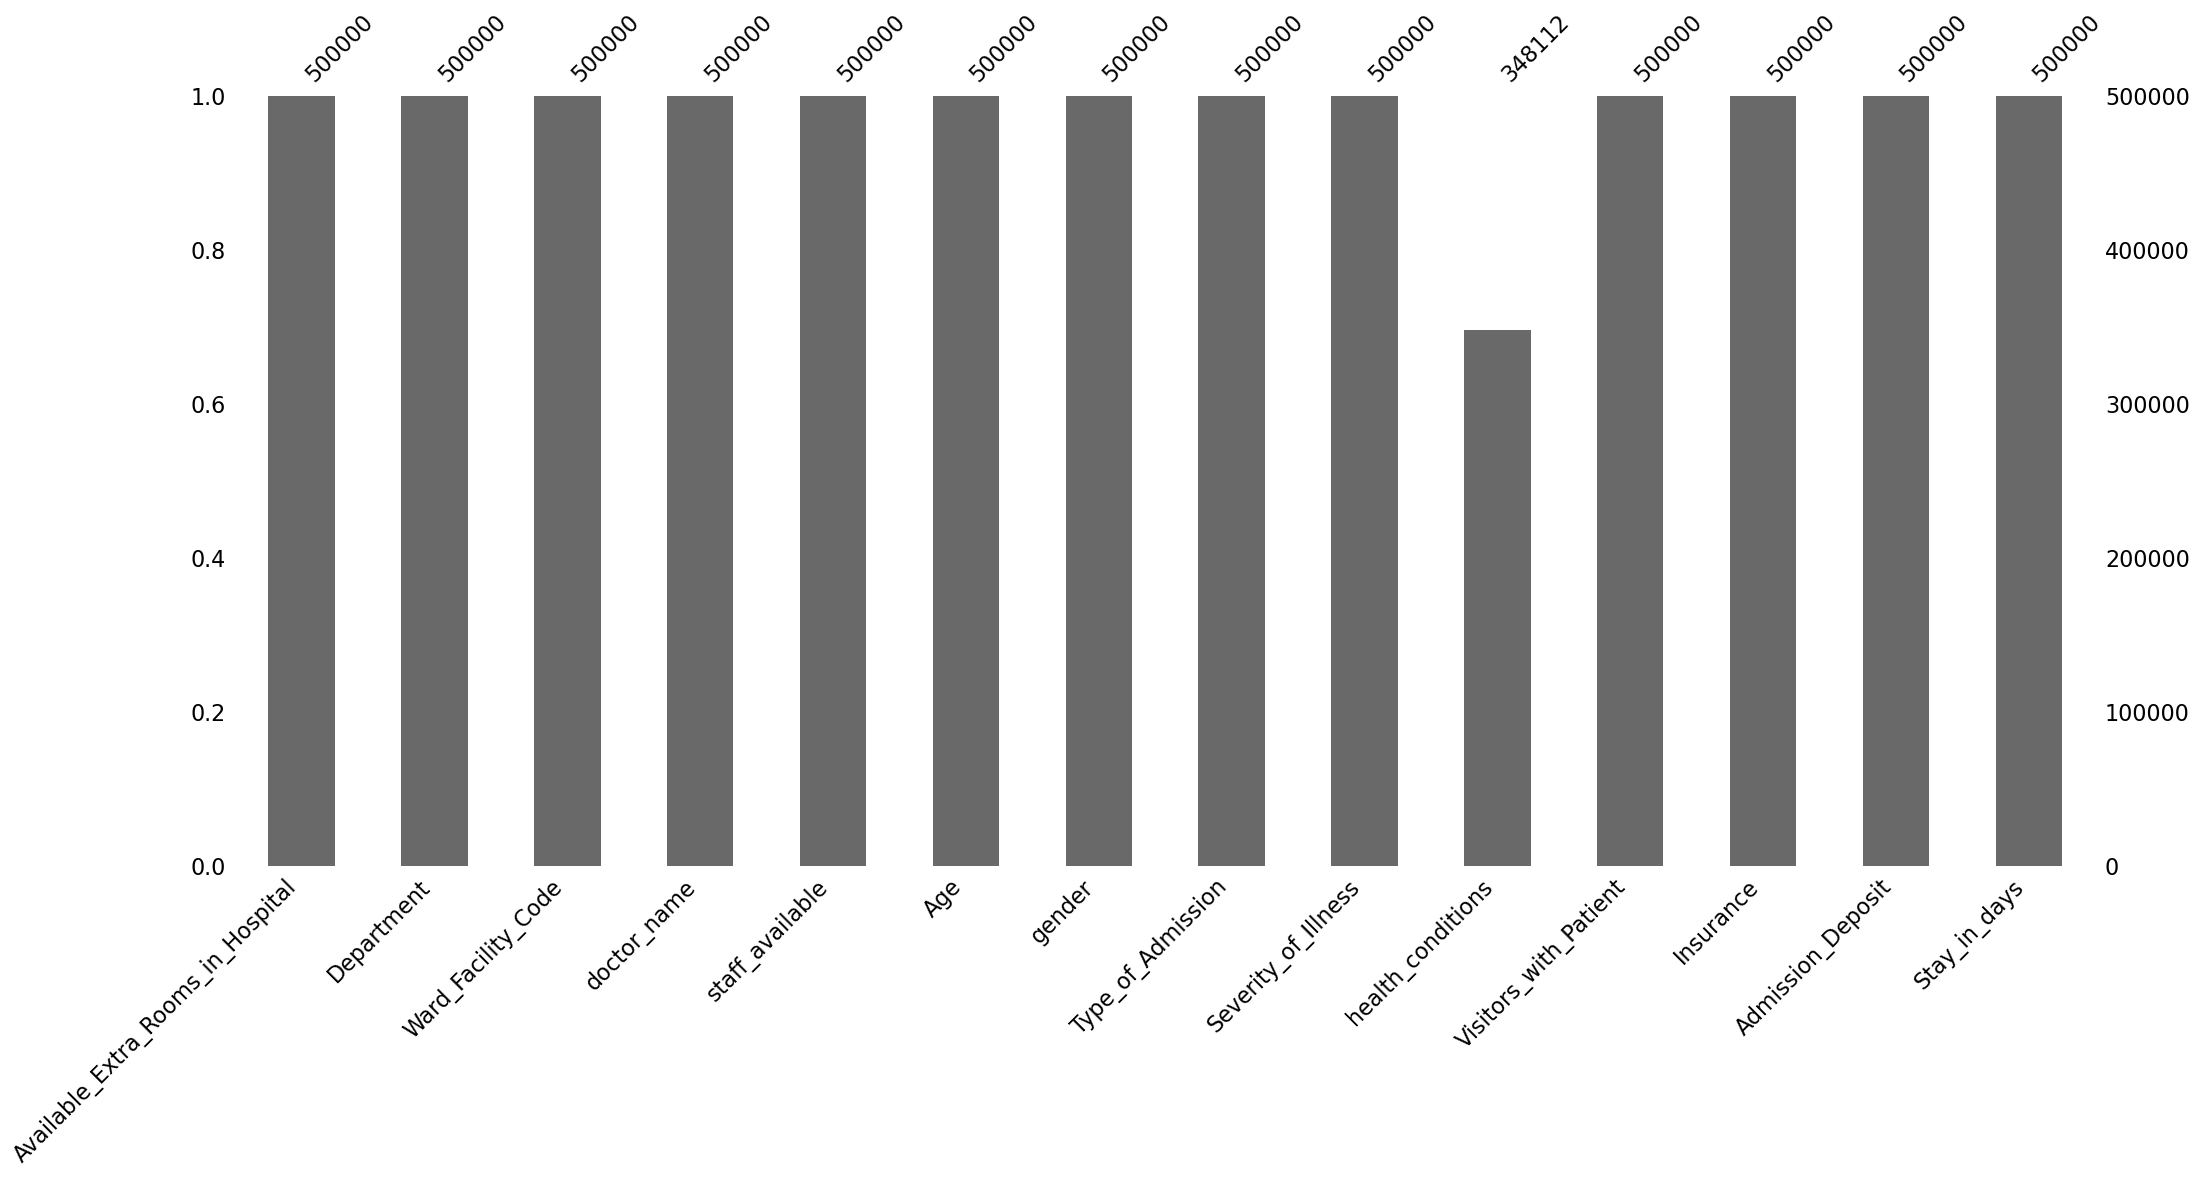

In [37]:
import missingno as msno
msno.bar(df)
plt.show()

In [38]:
(df.isnull().sum()/len(df))*100

Available_Extra_Rooms_in_Hospital     0.0000
Department                            0.0000
Ward_Facility_Code                    0.0000
doctor_name                           0.0000
staff_available                       0.0000
Age                                   0.0000
gender                                0.0000
Type_of_Admission                     0.0000
Severity_of_Illness                   0.0000
health_conditions                    30.3776
Visitors_with_Patient                 0.0000
Insurance                             0.0000
Admission_Deposit                     0.0000
Stay_in_days                          0.0000
dtype: float64

**Inference**
* As previously noted, the "health_conditions" column contains approximately 30% null values. If we choose to impute these missing values using the mode, it could introduce bias into the model. Therefore, further analysis is necessary to determine whether we should remove this column altogether or drop the rows with null values.

## Outlier Treatment

In [39]:
def outlier_bounds(df, column):
  """
  Calculates the lower and upper bounds for outlier detection using the IQR method.

  Args:
    df: The pandas DataFrame containing the numerical column.
    column: The name of the numerical column to analyze.

  Returns:
    A tuple containing the lower and upper bounds.
  """

  q1 = df[column].quantile(0.25)
  q3 = df[column].quantile(0.75)
  iqr = q3 - q1
  ll = q1 - 1.5 * iqr
  ul = q3 + 1.5 * iqr

  return ll, ul

In [40]:
ll, ul = outlier_bounds(df, num)
print("Lower bound:", ll)
print("Upper bound:", ul)

Lower bound: Available_Extra_Rooms_in_Hospital      -1.000000
staff_available                        -7.000000
Visitors_with_Patient                  -1.000000
Admission_Deposit                    2541.867254
Stay_in_days                            3.500000
dtype: float64
Upper bound: Available_Extra_Rooms_in_Hospital       7.000000
staff_available                        17.000000
Visitors_with_Patient                   7.000000
Admission_Deposit                    6621.459994
Stay_in_days                           15.500000
dtype: float64


In [41]:
df[((df[num]<ll)|(df[num]>ul)).any(axis=1)].shape

(172260, 14)

In [42]:
(df[((df[num]<ll)|(df[num]>ul)).any(axis=1)].shape[0]/df.shape[0])*100

34.452

**Inference**
* The dataset contains approximately 34% outliers, which is a significant proportion. However, due to the nature of the healthcare domain, where every piece of data is crucial for analysis, we cannot remove or cap these outliers. Therefore, we will proceed to the next steps in our analysis while retaining the outliers as they may provide valuable insights.

### Null value imputation

##### health_conditions

In [43]:
df = df.dropna(axis=0)

**Inference**
* As previously mentioned, every data point is important in the healthcare context. Removing the entire "health_conditions" column would result in the loss of valuable information. Therefore, we opted to drop only the null values from this column, preserving the remaining data for analysis.

## Univariate Analysis

#### Numeric columns

In [44]:
df[num].skew()

Available_Extra_Rooms_in_Hospital    4.684799
staff_available                     -0.009045
Visitors_with_Patient                3.721570
Admission_Deposit                    0.909478
Stay_in_days                         1.758216
dtype: float64

**Inference**
* The "Available_Extra_Rooms_in_Hospital" and "Visitors_with_Patient" columns show high positive skewness values of 4.68 and 3.72, respectively, indicating that most values are clustered toward the lower end, with a few larger values extending the distribution to the right.
* The "Stay_in_days" column has a moderate positive skewness of 1.76, suggesting that while the majority of stays are relatively short, there are some significantly longer hospital stays that skew the distribution.
* The "staff_available" column shows very low skewness (-0.009), indicating a near-symmetrical distribution, meaning values are fairly evenly distributed on both sides of the mean.

In [45]:
df[num].kurt()

Available_Extra_Rooms_in_Hospital    28.146133
staff_available                      -1.214119
Visitors_with_Patient                23.792375
Admission_Deposit                     1.454571
Stay_in_days                          2.129805
dtype: float64

**Inference**
* The "Available_Extra_Rooms_in_Hospital" and "Visitors_with_Patient" columns exhibit high kurtosis values of 28.15 and 23.79, respectively, indicating leptokurtic distributions. This suggests that these variables have heavy tails and a higher likelihood of extreme values, with most observations clustered near the mean.
* The "Stay_in_days" column has a kurtosis of 2.13, which is slightly above normal and also leptokurtic, suggesting a distribution with more pronounced peaks and heavier tails than a normal distribution, indicating some potential for outliers.
* The "staff_available" and "patientid" columns display negative kurtosis values (-1.21 and -1.38, respectively), indicating platykurtic distributions. This means these columns have lighter tails and are more evenly spread around the mean, with fewer extreme values compared to a normal distribution.

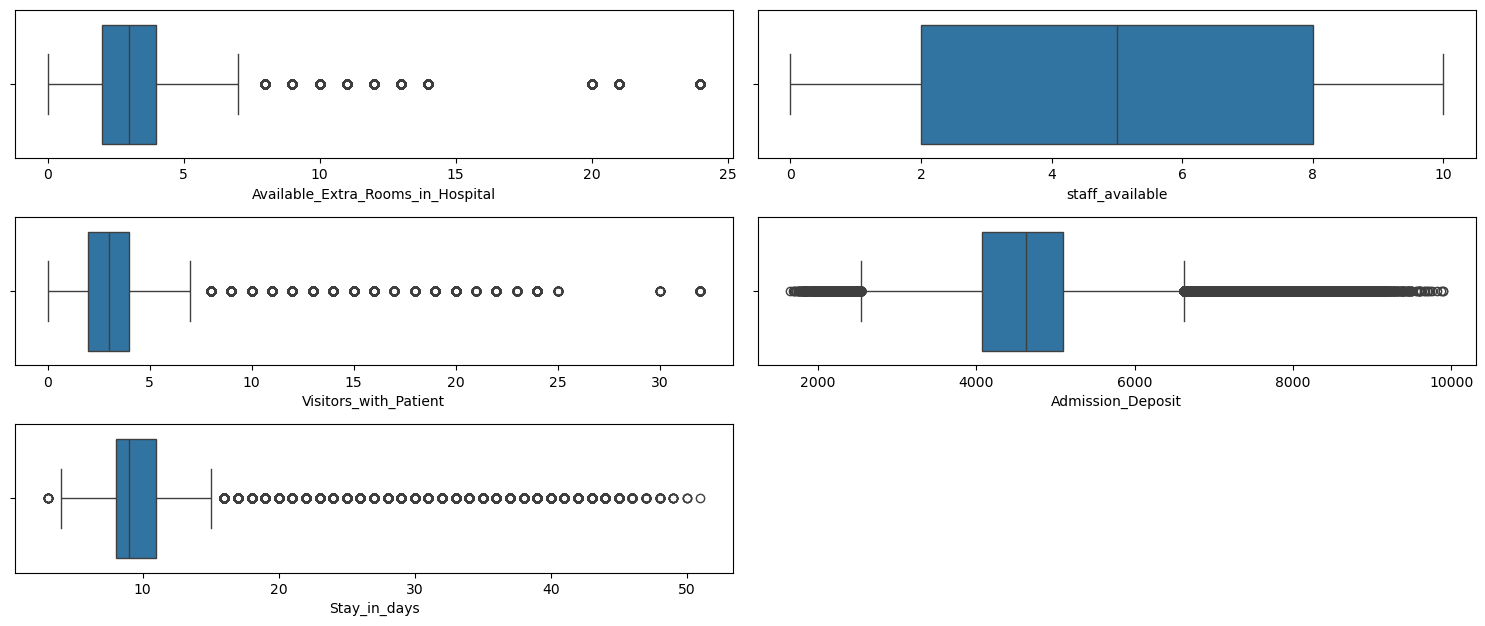

In [46]:
t=1
for i in num:
    plt.subplot(4,2,t)
    sns.boxplot(x= df[i])
    t+=1
plt.tight_layout()
plt.show()

#### Lets now visualize the skew and the distribution of data

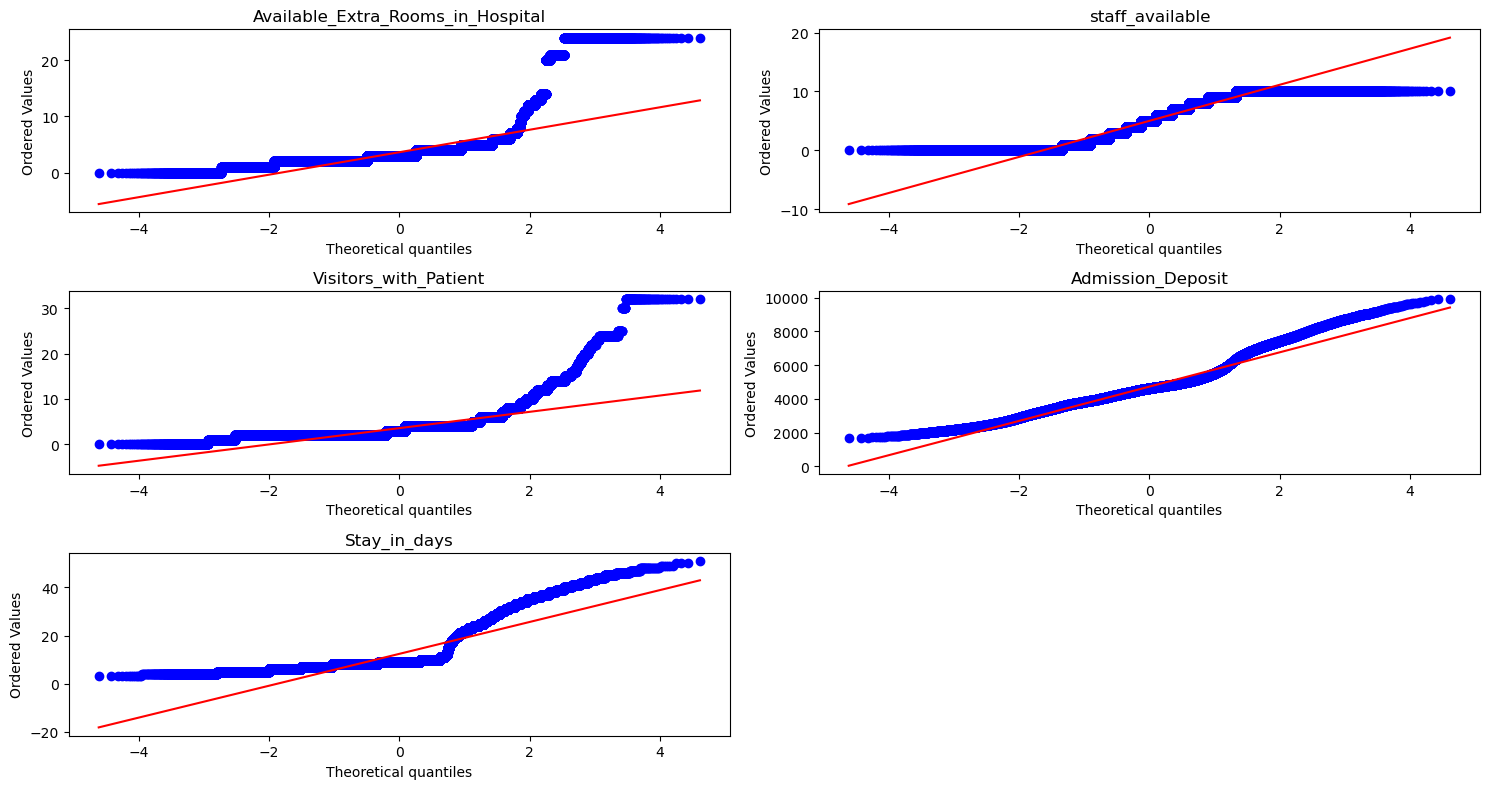

In [47]:
t=1
for i in num:
    plt.subplot(3,2,t)
    probplot(df[i], dist='norm', plot=plt)
    plt.title(i)
    t+=1
plt.tight_layout()
plt.show()

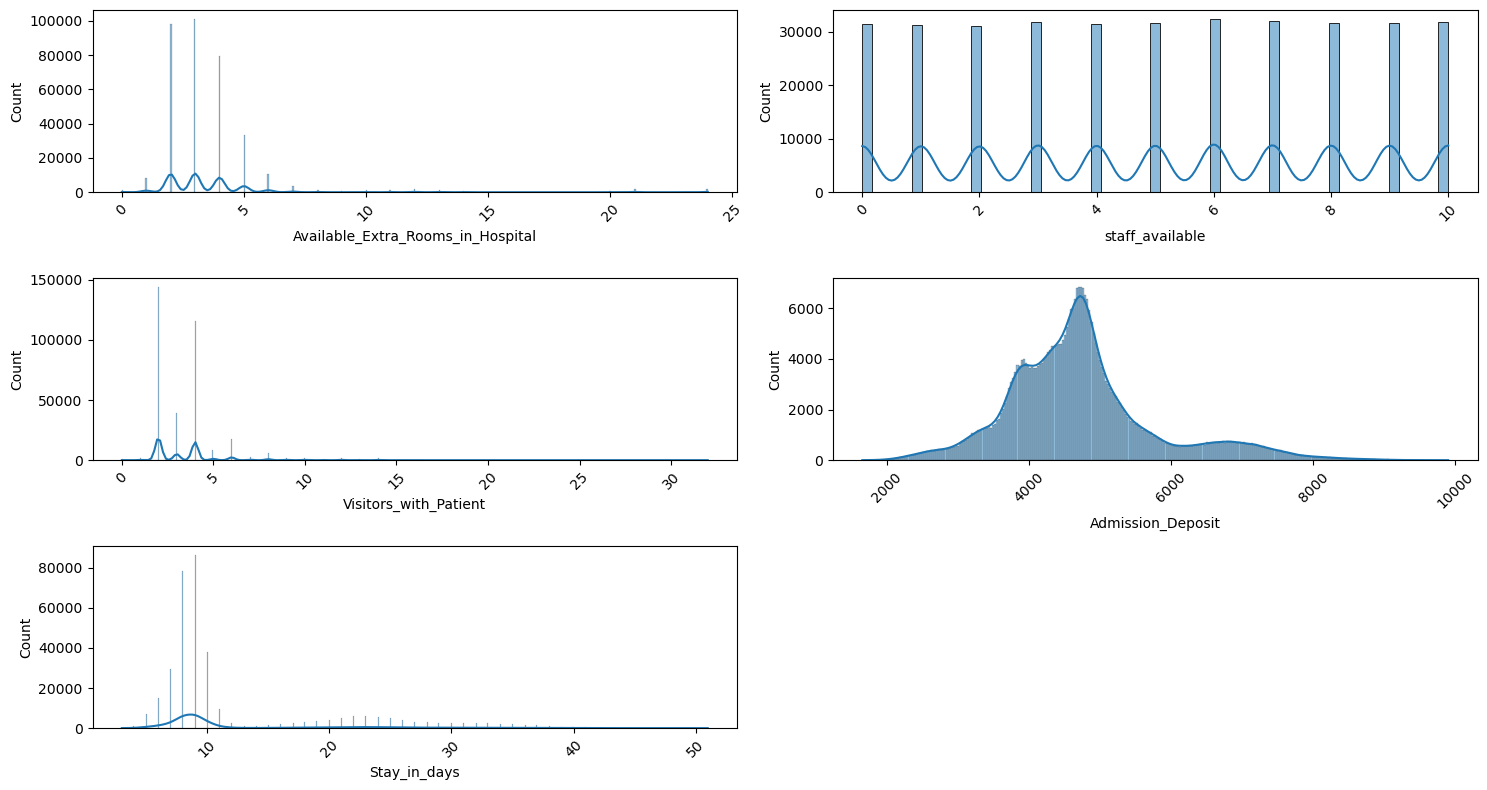

In [48]:
t=1
for i in num:
    plt.subplot(3,2,t)
    sns.histplot(df[i],kde= True)
    plt.xticks(rotation=45,fontsize = 10)
    t+=1
plt.tight_layout()
plt.show()

#### Categorical columns

In [49]:
for i in cat:
    print(i, df[i].unique())
    print("---------------------------")
    print()

Department ['gynecology' 'anesthesia' 'TB & Chest disease' 'radiotherapy' 'surgery']
---------------------------

Ward_Facility_Code ['D' 'B' 'E' 'F' 'A' 'C']
---------------------------

doctor_name ['Dr Sophia' 'Dr Mark' 'Dr Olivia' 'Dr John' 'Dr Sarah' 'Dr Sam'
 'Dr Nathan' 'Dr Simon' 'Dr Isaac']
---------------------------

Age ['41-50' '31-40' '21-30' '71-80' '11-20' '51-60' '61-70' '81-90' '91-100'
 '0-10']
---------------------------

gender ['Female' 'Male' 'Other']
---------------------------

Type_of_Admission ['Trauma' 'Emergency' 'Urgent']
---------------------------

Severity_of_Illness ['Extreme' 'Minor' 'Moderate']
---------------------------

health_conditions ['Diabetes' 'Heart disease' 'Other' 'Asthama' 'High Blood Pressure']
---------------------------

Insurance ['Yes' 'No']
---------------------------



In [50]:
for i in cat:
    print((df[i].value_counts(normalize=True))*100)
    print()

Department
gynecology            68.721561
radiotherapy          16.795169
anesthesia             8.857494
TB & Chest disease     4.585019
surgery                1.040757
Name: proportion, dtype: float64

Ward_Facility_Code
F    24.096555
D    23.831123
B    20.793882
E    19.066278
A     9.298731
C     2.913430
Name: proportion, dtype: float64

doctor_name
Dr Sarah     28.610332
Dr Sophia    21.473836
Dr Sam       11.092694
Dr Olivia    10.841913
Dr John      10.269683
Dr Mark       8.875304
Dr Nathan     7.795480
Dr Isaac      0.675070
Dr Simon      0.365687
Name: proportion, dtype: float64

Age
31-40     27.622432
21-30     26.872386
41-50     16.151124
11-20     13.368111
61-70      5.298582
51-60      4.353197
71-80      3.735867
81-90      1.647746
0-10       0.679379
91-100     0.271177
Name: proportion, dtype: float64

gender
Female    74.210886
Male      20.643069
Other      5.146045
Name: proportion, dtype: float64

Type_of_Admission
Trauma       62.071977
Emergency    27.208

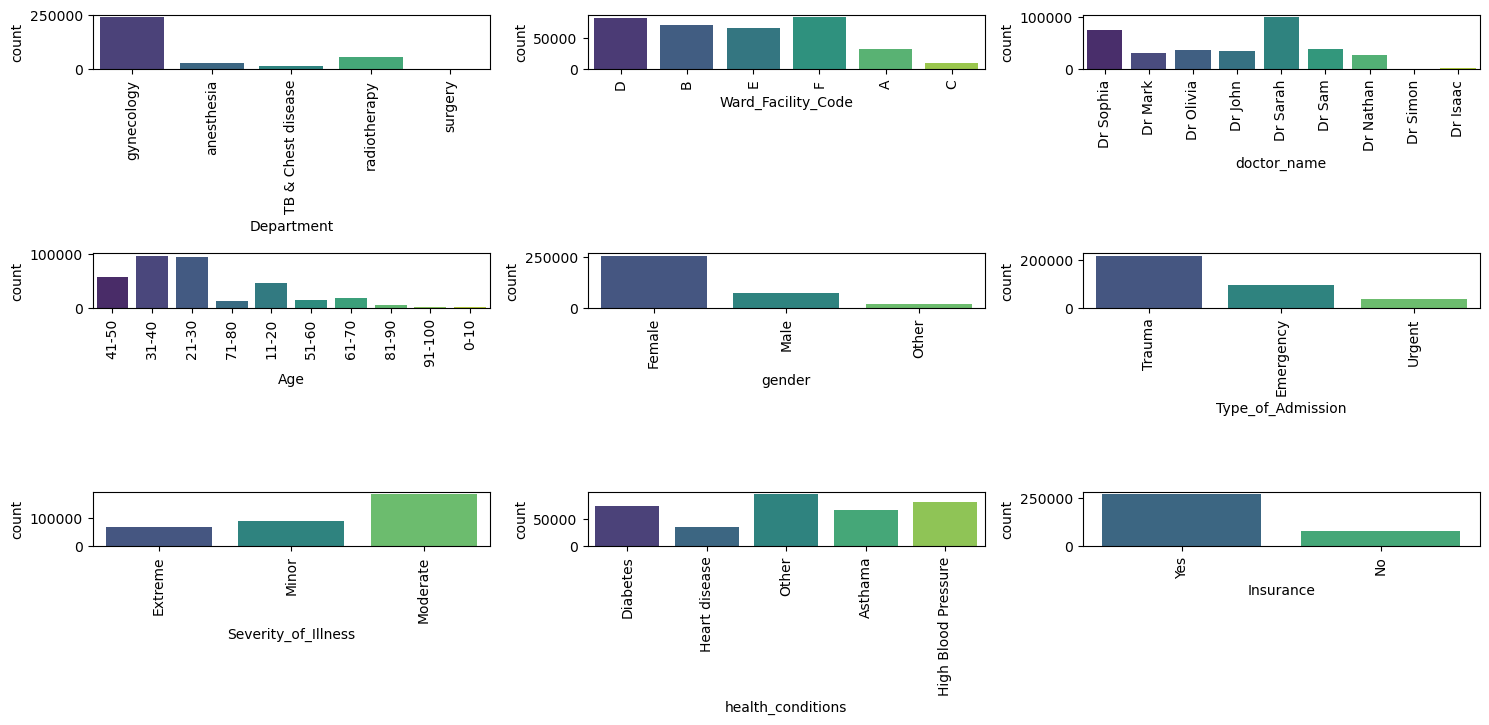

In [51]:
t = 1

for i in cat:
    plt.subplot(4,3,t)
    sns.countplot(x=df[i], palette='viridis')
    plt.xticks(rotation= 90)
    t+=1

plt.tight_layout()
plt.show()

## Bivariate Analysis

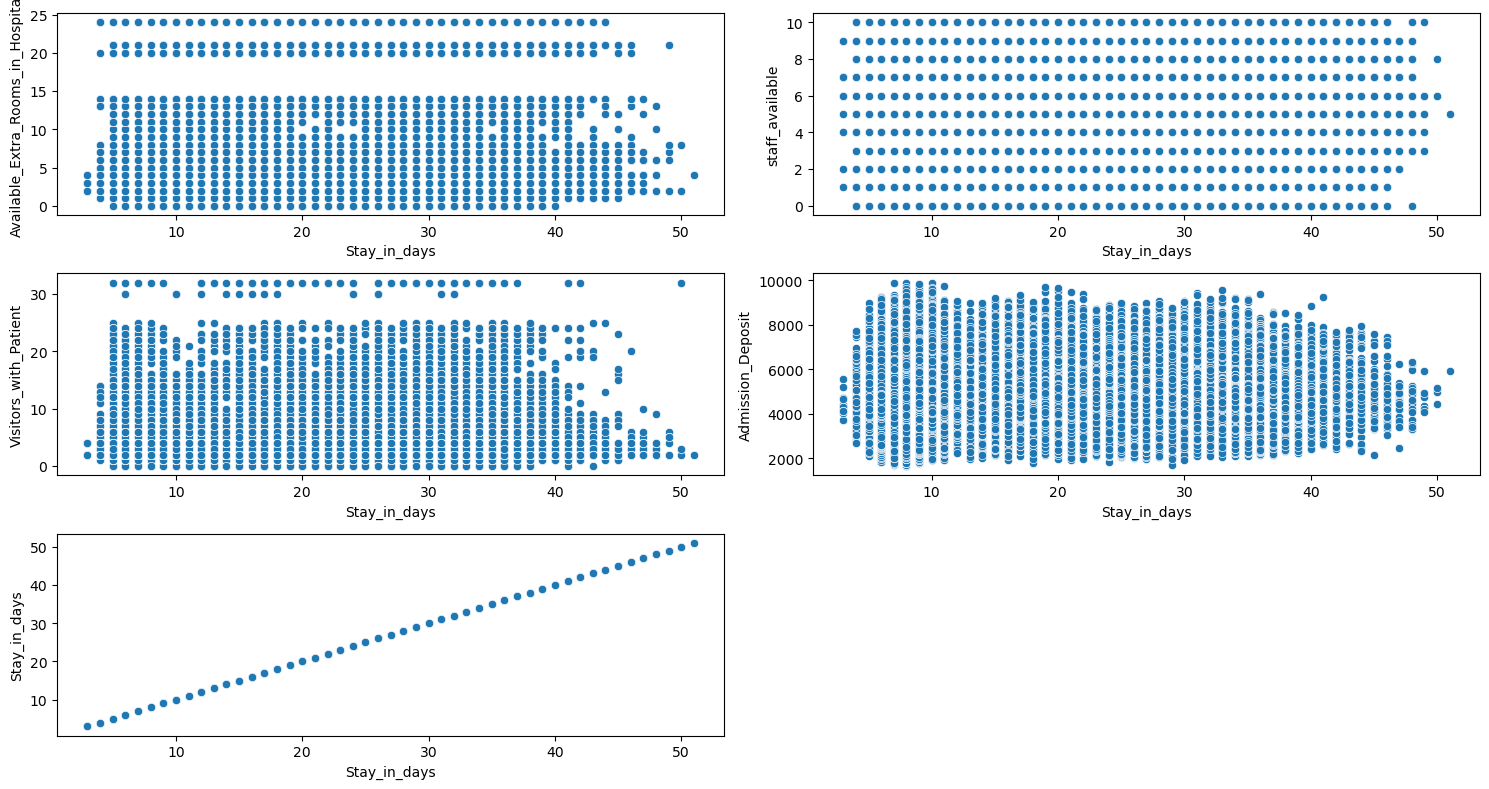

In [52]:
t=1
for i in num:
        plt.subplot(3,2,t)
        sns.scatterplot(y=df[i],x= df['Stay_in_days'])
        t+=1
plt.tight_layout()
plt.show()

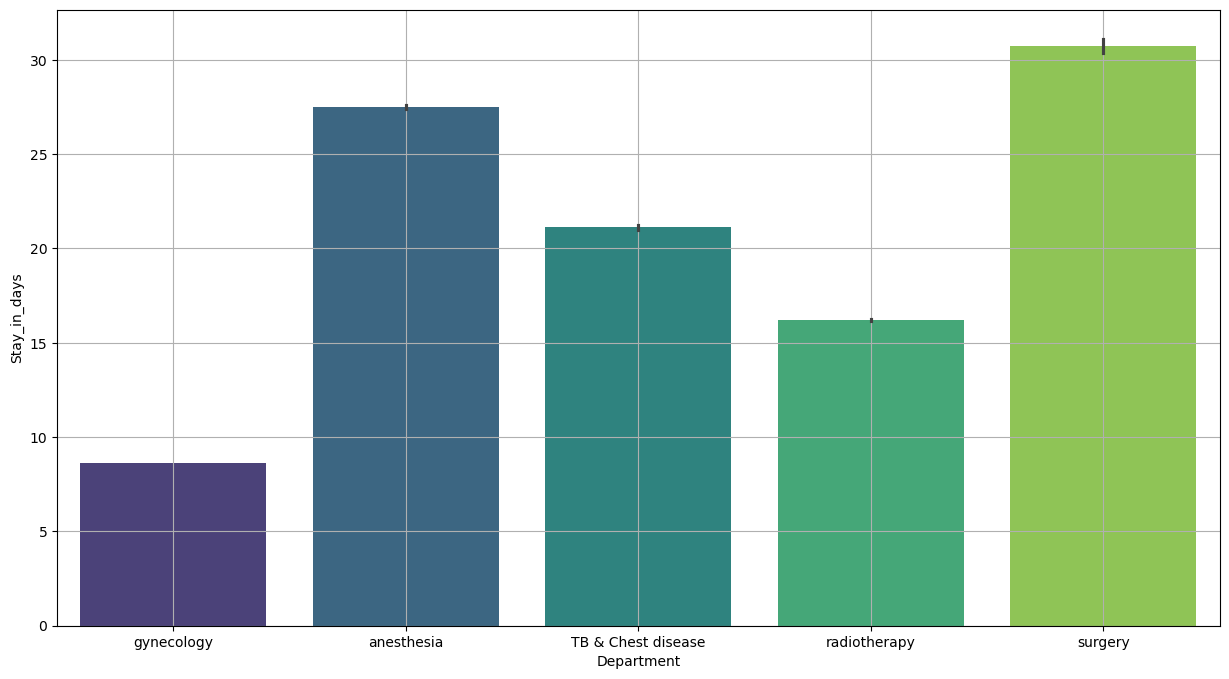

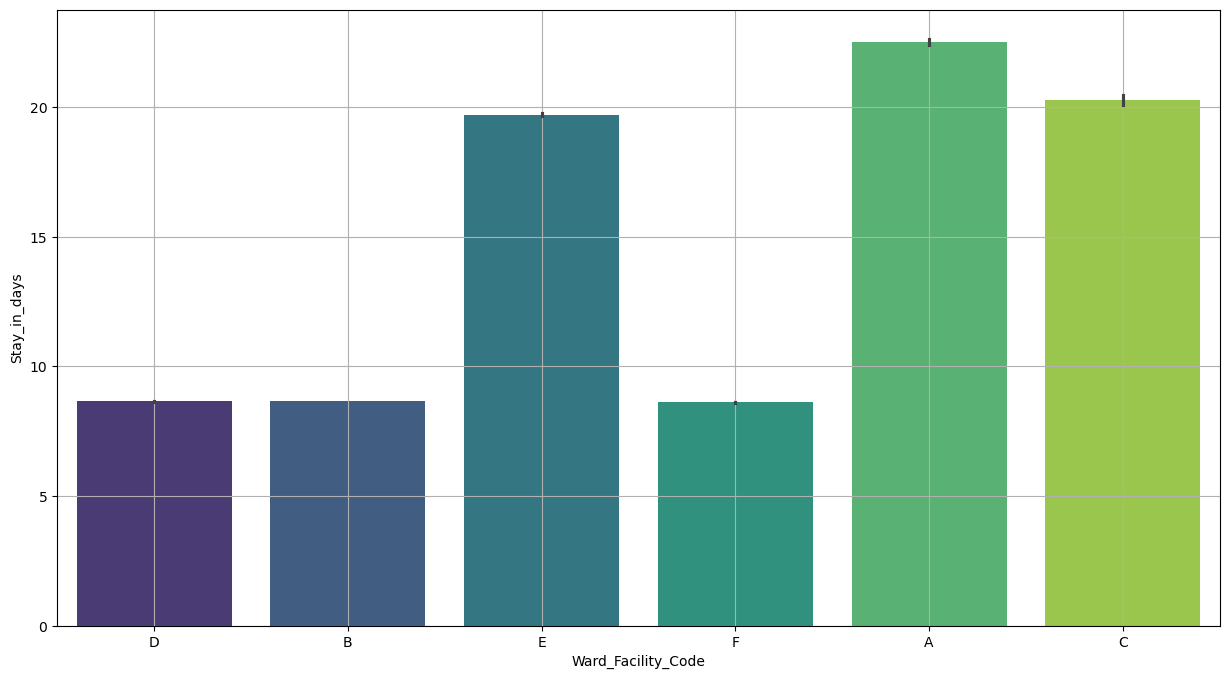

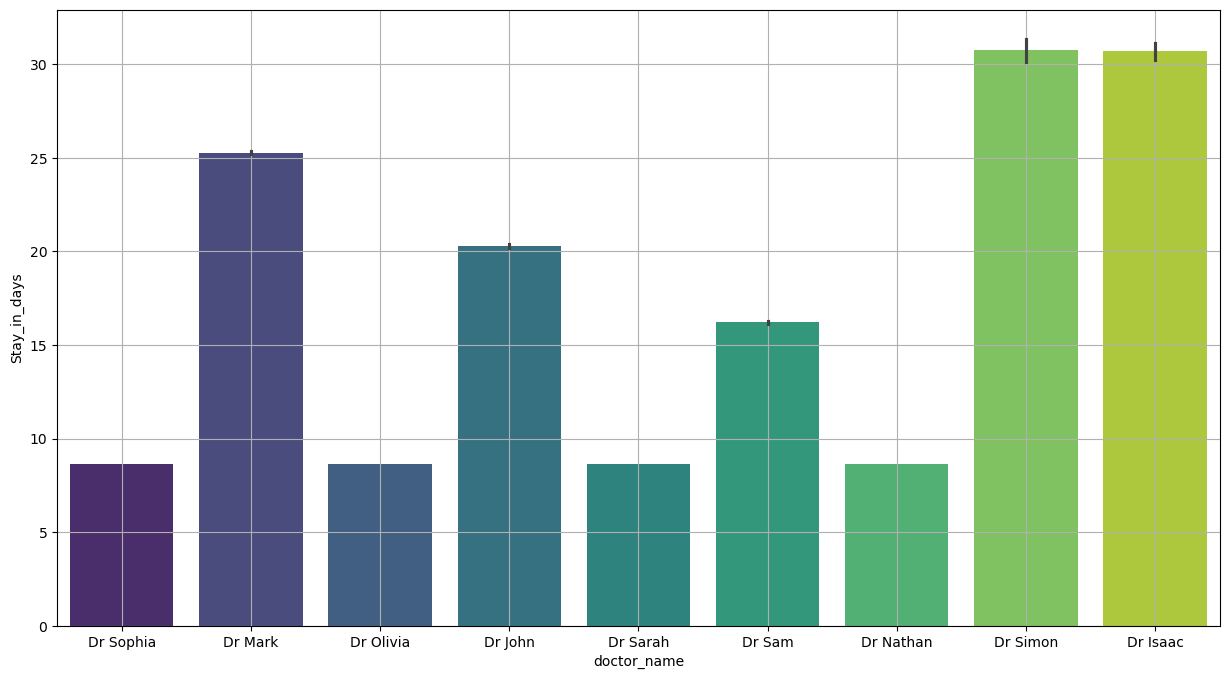

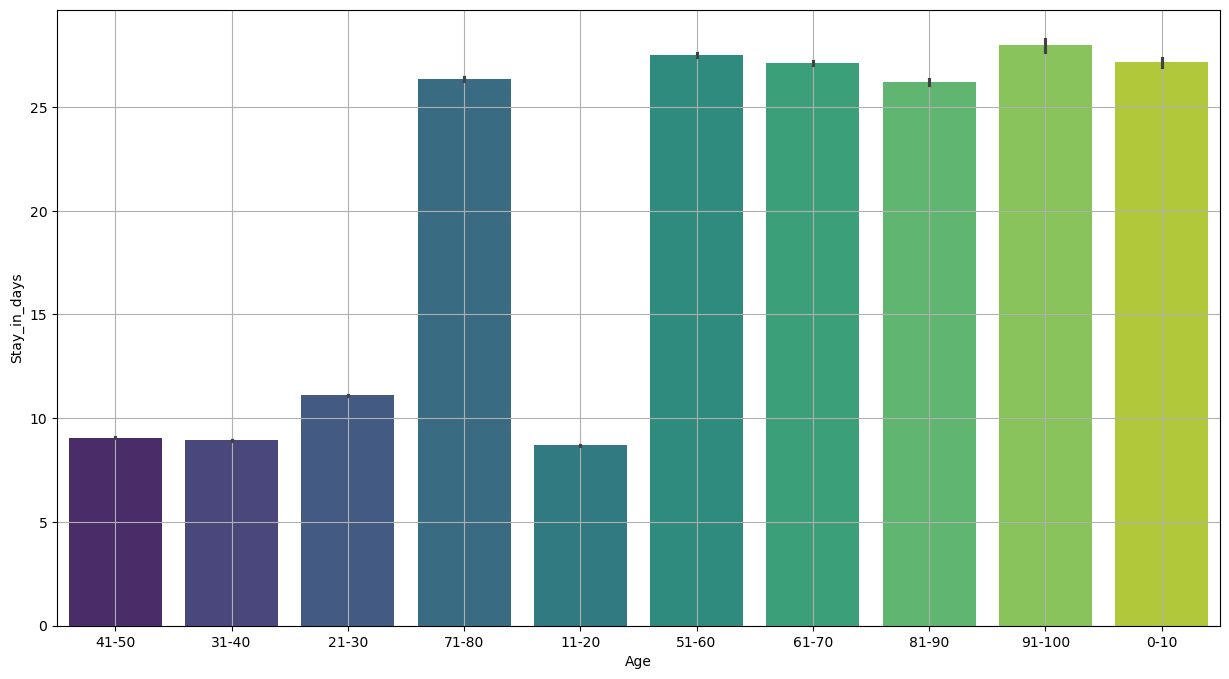

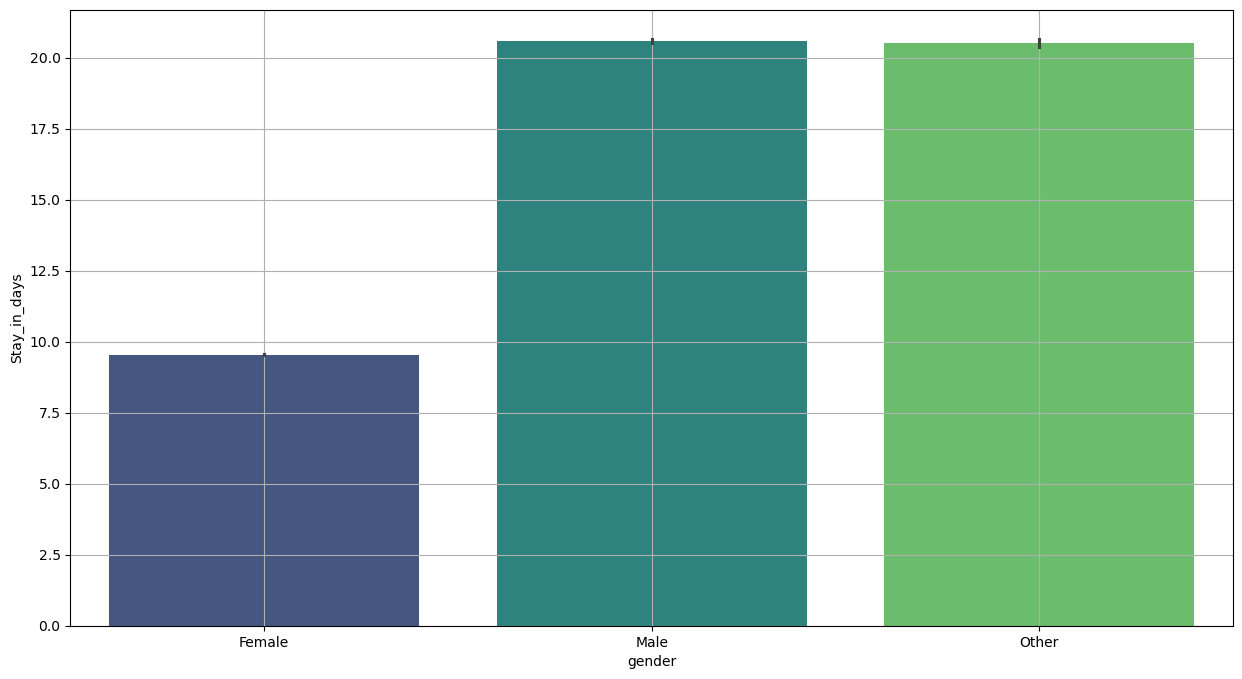

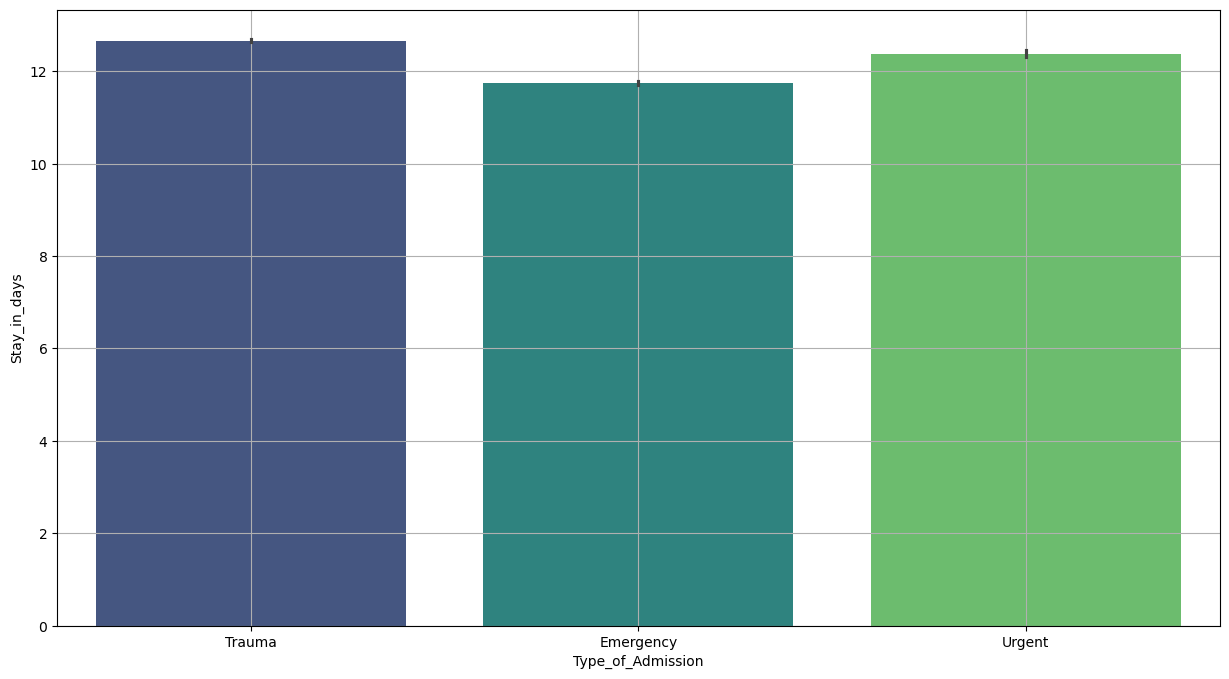

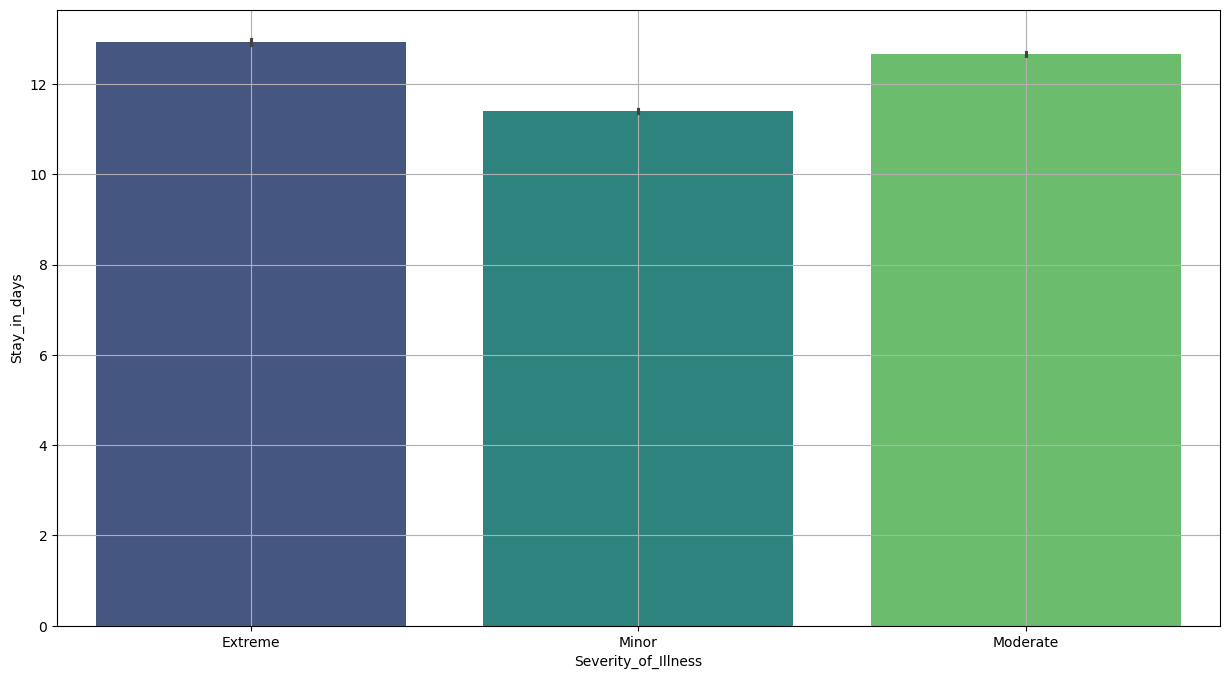

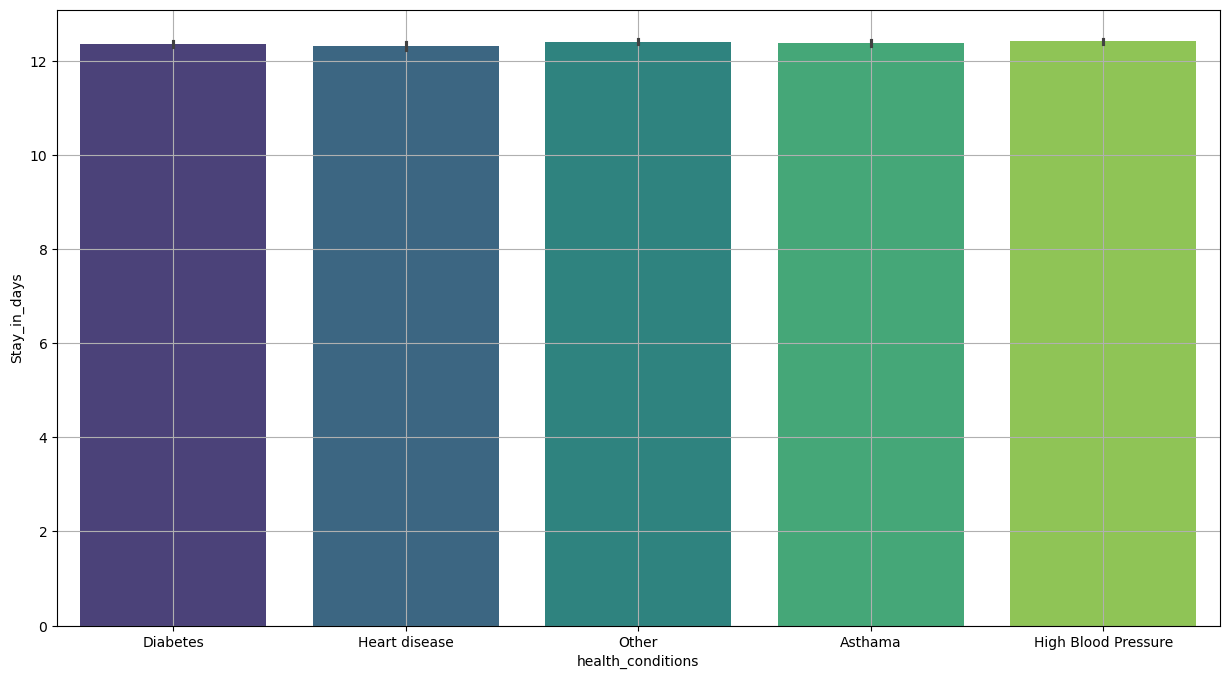

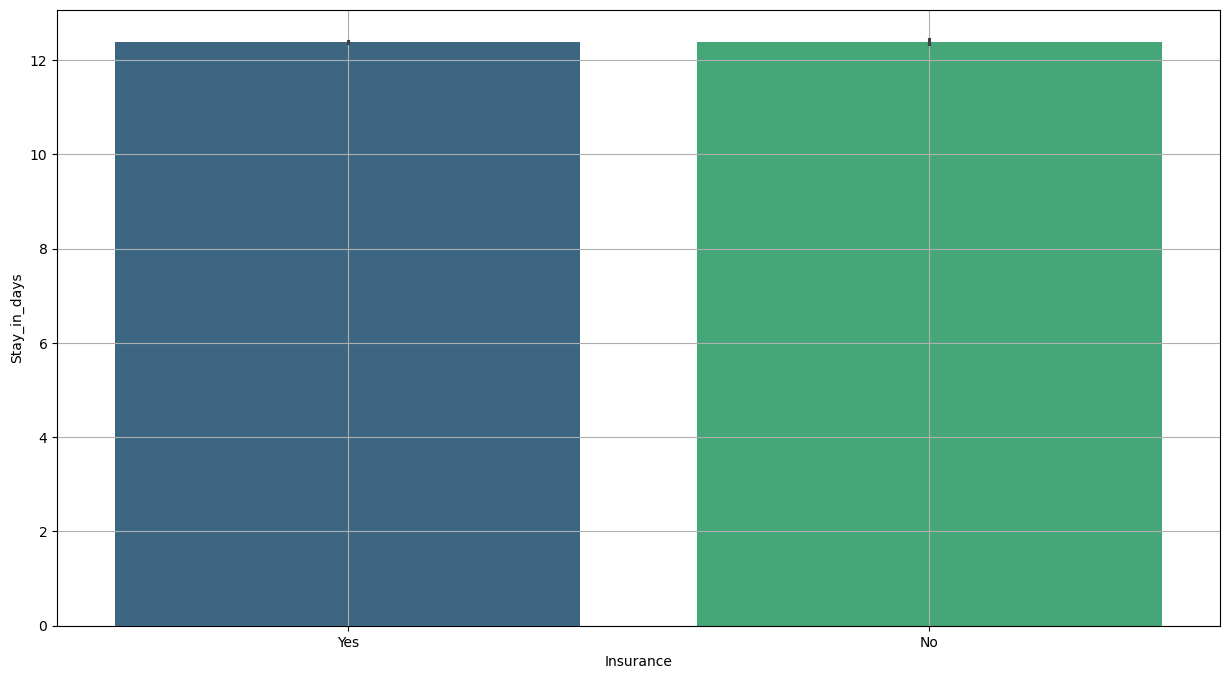

In [53]:
for i in cat:
    sns.barplot(data=df,x= df[i],y=df['Stay_in_days'], palette='viridis')
    plt.grid()
    plt.show()

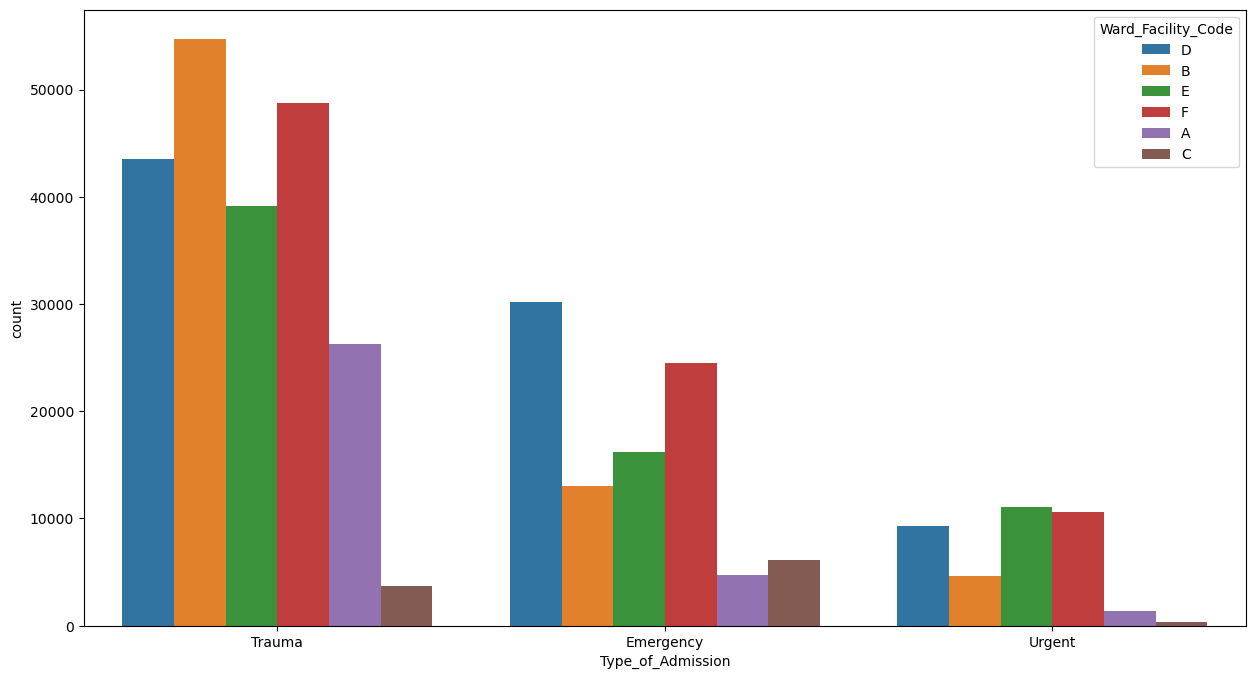

In [54]:
sns.countplot(x=df['Type_of_Admission'],hue= df['Ward_Facility_Code'])
plt.show()


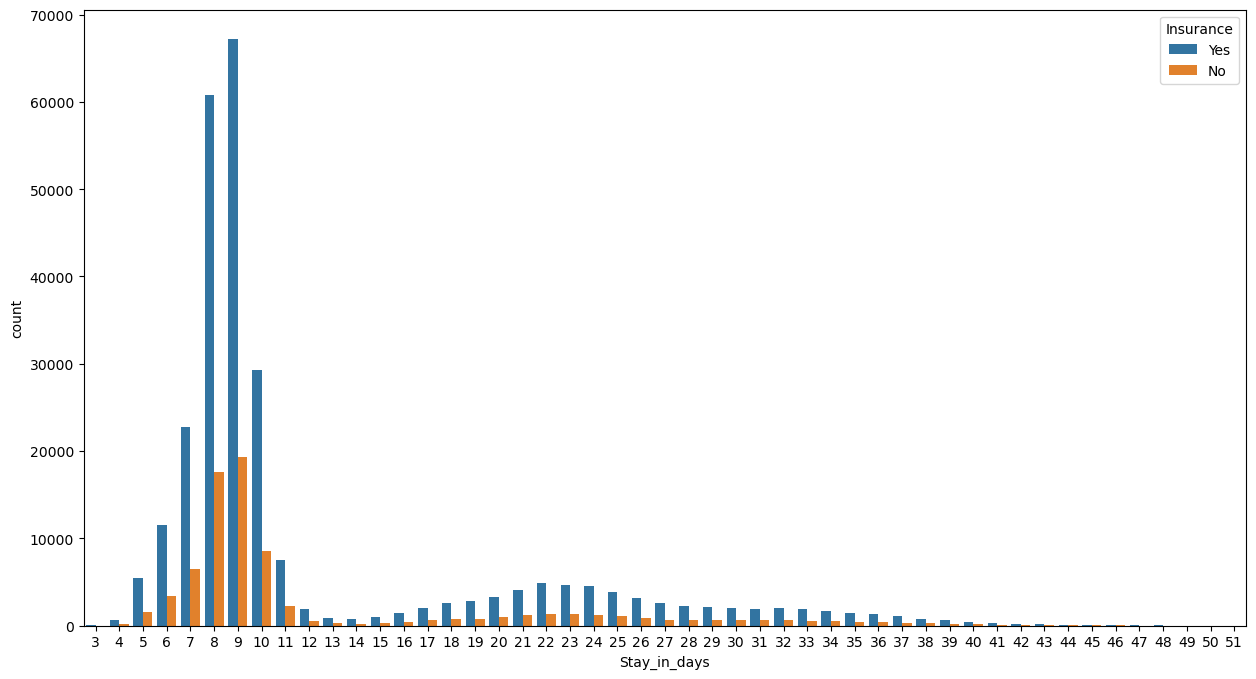

In [55]:
sns.countplot(x=df['Stay_in_days'],hue= df['Insurance'])
plt.show()

## Multivariate Analysis

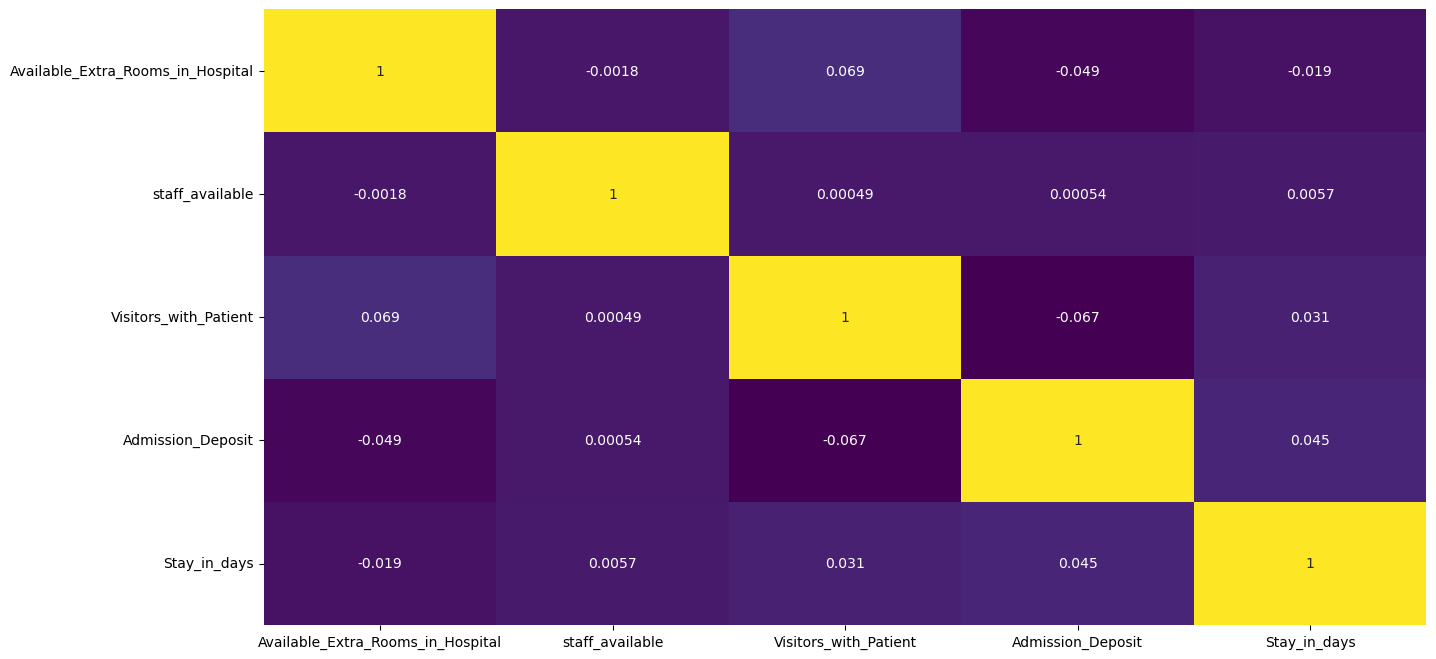

In [56]:
sns.heatmap(df[num].corr(), annot=True, cmap='viridis', cbar=False)
plt.show()

**Inference**
* Most features show very low correlation with the target variable "Stay_in_days." The highest correlation with "Stay_in_days" is observed in "Admission_Deposit" (0.0445) and "Visitors_with_Patient" (0.0308), suggesting that these features have only minimal linear relationships with the length of hospital stay.
* "Available_Extra_Rooms_in_Hospital" and "Visitors_with_Patient" have a positive correlation of 0.0693, indicating a weak association. However, this correlation is still minimal, implying limited dependency between the two variables.
* "Admission_Deposit" has a weak negative correlation with "Visitors_with_Patient" (-0.0672) and "Available_Extra_Rooms_in_Hospital" (-0.0495), suggesting that as the deposit amount changes, it is minimally associated with variations in room availability and visitor numbers.
* Overall, the correlation matrix indicates that most features have low correlation values with each other and with the target variable, meaning that these variables may contribute independently in the model without strong multicollinearity issues.

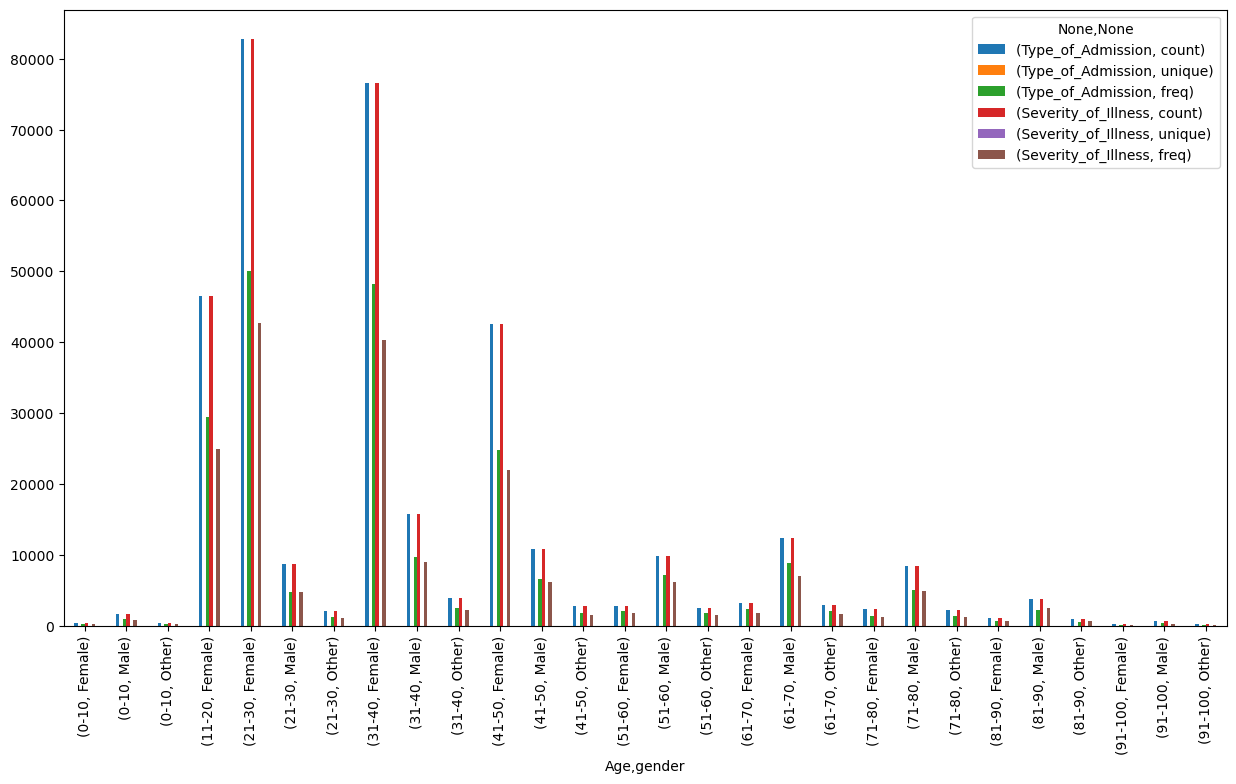

In [57]:
df.groupby(['Age','gender'])[['Type_of_Admission','Severity_of_Illness']].describe().plot(kind='bar')
plt.show()

## Advanced Analysis

In [58]:
cat

['Department',
 'Ward_Facility_Code',
 'doctor_name',
 'Age',
 'gender',
 'Type_of_Admission',
 'Severity_of_Illness',
 'health_conditions',
 'Insurance']

In [59]:
df.groupby('Age')['gender'].describe()

count unique     top   freq
Age                                
0-10     2365      3    Male   1573
11-20   46536      1  Female  46536
21-30   93546      3  Female  82801
31-40   96157      3  Female  76573
41-50   56224      3  Female  42564
51-60   15154      3    Male   9883
61-70   18445      3    Male  12294
71-80   13005      3    Male   8477
81-90    5736      3    Male   3791
91-100    944      3    Male    612

In [60]:
df.groupby(['Age','gender'])['health_conditions'].describe()

count unique                  top   freq
Age    gender                                          
0-10   Female    415      5                Other    111
       Male     1573      5                Other    451
       Other     377      5                Other     98
11-20  Female  46536      2  High Blood Pressure  25536
21-30  Female  82801      5                Other  38108
       Male     8652      5                Other   2431
       Other    2093      5                Other    530
31-40  Female  76573      5        Heart disease  17905
       Male    15730      5                Other   4202
       Other    3854      5                Other   1049
41-50  Female  42564      5                Other  11490
       Male    10849      5                Other   2965
       Other    2811      5                Other    729
51-60  Female   2804      5                Other    793
       Male     9883      5                Other   2663
       Other    2467      5                Other    667
61-70  Female   3178      5                Other    885
       Male    12294      5                Other   3395
       Other    2973      5                Other    808
71-80  Female   2293      5                Other    599
       Male     8477      5                Other   2329
       Other    2235      5                Other    616
81-90  Female   1002      5                Other    261
       Male     3791      5                Other   1036
       Other     943      5                Other    247
91-100 Female    171      5                Other     48
       Male      612      5                Other    161
       Other     161      5  High Blood Pressure     43

In [61]:
df.groupby(['Age','gender'])['Department'].describe()

count unique                 top   freq
Age    gender                                         
0-10   Female    415      4        radiotherapy    171
       Male     1573      4        radiotherapy    718
       Other     377      4        radiotherapy    167
11-20  Female  46536      1          gynecology  46536
21-30  Female  82801      5          gynecology  80522
       Male     8652      4        radiotherapy   5193
       Other    2093      4        radiotherapy   1222
31-40  Female  76573      5          gynecology  72395
       Male    15730      4        radiotherapy   9055
       Other    3854      4        radiotherapy   2197
41-50  Female  42564      5          gynecology  39775
       Male    10849      4        radiotherapy   5761
       Other    2811      4        radiotherapy   1547
51-60  Female   2804      4        radiotherapy   1276
       Male     9883      4        radiotherapy   4775
       Other    2467      4        radiotherapy   1190
61-70  Female   3178      4        radiotherapy   1462
       Male    12294      4        radiotherapy   5558
       Other    2973      4        radiotherapy   1375
71-80  Female   2293      4        radiotherapy   1336
       Male     8477      4        radiotherapy   4952
       Other    2235      4        radiotherapy   1353
81-90  Female   1002      4        radiotherapy    647
       Male     3791      4        radiotherapy   2462
       Other     943      4        radiotherapy    598
91-100 Female    171      4  TB & Chest disease     72
       Male      612      4  TB & Chest disease    299
       Other     161      3  TB & Chest disease     85

In [62]:
df.groupby('Age')['Severity_of_Illness'].describe()

count unique       top   freq
Age                                  
0-10     2365      3  Moderate   1197
11-20   46536      3  Moderate  24855
21-30   93546      3  Moderate  48552
31-40   96157      3  Moderate  51476
41-50   56224      3  Moderate  29658
51-60   15154      3  Moderate   9429
61-70   18445      3  Moderate  10442
71-80   13005      3  Moderate   7360
81-90    5736      3  Moderate   3630
91-100    944      3  Moderate    432

In [63]:
df.groupby('Severity_of_Illness')['Visitors_with_Patient'].describe()

count      mean       std  min  25%  50%  75%   max
Severity_of_Illness                                                        
Extreme               69584.0  3.356576  2.063946  0.0  2.0  3.0  4.0  32.0
Minor                 91497.0  3.517930  2.122059  0.0  2.0  3.0  4.0  32.0
Moderate             187031.0  3.610696  2.361936  0.0  2.0  3.0  4.0  32.0

In [64]:
df.groupby('Severity_of_Illness')[['Visitors_with_Patient','Stay_in_days']].describe()

Visitors_with_Patient                                     \
                                    count      mean       std  min  25%  50%   
Severity_of_Illness                                                            
Extreme                           69584.0  3.356576  2.063946  0.0  2.0  3.0   
Minor                             91497.0  3.517930  2.122059  0.0  2.0  3.0   
Moderate                         187031.0  3.610696  2.361936  0.0  2.0  3.0   

                               Stay_in_days                                 \
                     75%   max        count       mean       std  min  25%   
Severity_of_Illness                                                          
Extreme              4.0  32.0      69584.0  12.936307  8.417804  3.0  8.0   
Minor                4.0  32.0      91497.0  11.395237  6.921492  3.0  8.0   
Moderate             4.0  32.0     187031.0  12.661553  8.120139  3.0  8.0   

                                      
                     50%   75%   max  
Severity_of_Illness                   
Extreme              9.0  16.0  50.0  
Minor                9.0  10.0  50.0  
Moderate             9.0  12.0  51.0

In [65]:
df.groupby('doctor_name')['Department'].describe().reset_index()

doctor_name  count unique           top   freq
0    Dr Isaac   2350      1       surgery   2350
1     Dr John  35750      3  radiotherapy  19851
2     Dr Mark  30896      2    anesthesia  20324
3   Dr Nathan  27137      1    gynecology  27137
4   Dr Olivia  37742      1    gynecology  37742
5      Dr Sam  38615      1  radiotherapy  38615
6    Dr Sarah  99596      1    gynecology  99596
7    Dr Simon   1273      1       surgery   1273
8   Dr Sophia  74753      1    gynecology  74753

In [66]:
df.groupby('doctor_name')[['Department','Stay_in_days']].describe().reset_index()

doctor_name Stay_in_days                                                   
                     count       mean        std  min   25%   50%   75%   max
0    Dr Isaac       2350.0  30.696596  11.179801  8.0  17.0  35.0  39.0  51.0
1     Dr John      35750.0  20.280308   9.738053  3.0  12.0  22.0  27.0  48.0
2     Dr Mark      30896.0  25.286930   8.777211  4.0  18.0  27.0  32.0  49.0
3   Dr Nathan      27137.0   8.625345   1.098950  4.0   8.0   9.0   9.0  13.0
4   Dr Olivia      37742.0   8.644534   1.015331  4.0   8.0   9.0   9.0  13.0
5      Dr Sam      38615.0  16.203574   8.467412  3.0   6.0  20.0  23.0  32.0
6    Dr Sarah      99596.0   8.658089   1.084408  3.0   8.0   9.0   9.0  13.0
7    Dr Simon       1273.0  30.749411  11.347812  9.0  17.0  35.0  39.0  50.0
8   Dr Sophia      74753.0   8.628229   1.062482  4.0   8.0   9.0   9.0  14.0

In [67]:
df.groupby('doctor_name')['health_conditions'].describe()

count unique                  top   freq
doctor_name                                          
Dr Isaac      2350      5                Other    695
Dr John      35750      5                Other   9592
Dr Mark      30896      5                Other   8466
Dr Nathan    27137      1                Other  27137
Dr Olivia    37742      1                Other  37742
Dr Sam       38615      5                Other  10472
Dr Sarah     99596      2  High Blood Pressure  54562
Dr Simon      1273      5             Diabetes    309
Dr Sophia    74753      2             Diabetes  50473

In [68]:
df.groupby(['Department','Ward_Facility_Code'])['health_conditions'].describe()

count unique    top   freq
Department         Ward_Facility_Code                            
TB & Chest disease A                    3306      5  Other    948
                   C                     930      5  Other    246
                   E                   11725      5  Other   3206
anesthesia         A                   10902      5  Other   2932
                   C                    2945      5  Other    764
                   E                   16987      5  Other   4633
gynecology         B                   72386      5  Other  19579
                   D                   82959      5  Other  22537
                   F                   83883      5  Other  22763
radiotherapy       A                   14539      5  Other   4025
                   C                    6267      5  Other   1739
                   E                   37660      5  Other  10037
surgery            A                    3623      5  Other   1002

In [69]:
df.groupby(['Department','Ward_Facility_Code'])['Stay_in_days'].describe()

count       mean        std   min  \
Department         Ward_Facility_Code                                        
TB & Chest disease A                    3306.0  21.344223   8.528537   5.0   
                   C                     930.0  20.420430   8.003270   7.0   
                   E                   11725.0  21.110448   8.621549   4.0   
anesthesia         A                   10902.0  27.433774   7.808480   9.0   
                   C                    2945.0  27.812564   9.119872  11.0   
                   E                   16987.0  27.482840   8.016885  10.0   
gynecology         B                   72386.0   8.669867   1.032817   3.0   
                   D                   82959.0   8.650225   1.038377   4.0   
                   F                   83883.0   8.612401   1.126429   3.0   
radiotherapy       A                   14539.0  17.068024   8.062154   3.0   
                   C                    6267.0  16.706079   8.824788   4.0   
                   E                   37660.0  15.778571   8.526911   3.0   
surgery            A                    3623.0  30.715153  11.237583   8.0   

                                        25%   50%   75%   max  
Department         Ward_Facility_Code                          
TB & Chest disease A                   12.0  25.0  28.0  38.0  
                   C                   12.0  23.5  27.0  35.0  
                   E                   12.0  24.0  28.0  41.0  
anesthesia         A                   19.0  30.0  34.0  47.0  
                   C                   18.0  30.0  35.0  49.0  
                   E                   19.0  30.0  34.0  49.0  
gynecology         B                    8.0   9.0   9.0  13.0  
                   D                    8.0   9.0   9.0  14.0  
                   F                    8.0   9.0   9.0  13.0  
radiotherapy       A                    6.0  21.0  23.0  31.0  
                   C                    6.0  21.0  24.0  32.0  
                   E                    6.0  20.0  23.0  32.0  
surgery            A                   17.0  35.0  39.0  51.0

## Statistical Test

In [70]:
from scipy import stats
import statistics
from scipy.stats import stats,shapiro,levene

In [71]:
df2['Type of Admission'].unique()

array(['Trauma', 'Urgent', 'Emergency'], dtype=object)

In [72]:
#H0: ALL MEANS ARE EQUAL
#Ha: ATLEAST ONE MEAN IS NOT EQUAL

In [73]:
# sIGNIFICANCE VALUE: 0.95

In [74]:
trauma = df2[df2['Type of Admission']== 'Trauma']['Stay (in days)']
Urgent= df2[df2['Type of Admission']== 'Urgent']['Stay (in days)']
Emergency= df2[df2['Type of Admission']== 'Emergency']['Stay (in days)']

In [75]:
import scipy.stats as stats

print(stats.shapiro(trauma))
print(stats.shapiro(Urgent))
print(stats.shapiro(Emergency))

ShapiroResult(statistic=0.7107059498997179, pvalue=6.536274084354167e-170)
ShapiroResult(statistic=0.7209502169892428, pvalue=2.196325736541461e-126)
ShapiroResult(statistic=0.6766870731698884, pvalue=1.683128529848396e-154)


In [76]:
print(stats.levene(trauma,Urgent,Emergency))

LeveneResult(statistic=700.5049657672507, pvalue=1.5848556529566841e-304)


In [77]:
stats.f_oneway(trauma,Urgent,Emergency)

F_onewayResult(statistic=644.0660020291162, pvalue=4.419598387929925e-280)

In [78]:
# Since pval is lesser than sig_val we reject null hypothesis
#At least one mean is not equal

In [79]:
# Letsfind the column which has unequal mean

In [80]:
import statsmodels.stats.multicomp as mc

In [81]:
mc.pairwise_tukeyhsd(df2['Stay (in days)'],df2['Type of Admission'],alpha= 0.95).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [82]:
df2['Severity of Illness'].unique()

array(['Extreme', 'Minor', 'Moderate'], dtype=object)

In [83]:
Extreme = df2[df2['Severity of Illness']=='Extreme']['Stay (in days)']
Minor= df2[df2['Severity of Illness']=='Minor']['Stay (in days)']
Moderate= df2[df2['Severity of Illness']=='Moderate']['Stay (in days)']

In [84]:
print(stats.shapiro(Extreme))
print(stats.shapiro(Minor))
print(stats.shapiro(Moderate))

ShapiroResult(statistic=0.7128379749631994, pvalue=5.68939538205286e-140)
ShapiroResult(statistic=0.6525028462340619, pvalue=4.747192409605749e-156)
ShapiroResult(statistic=0.7213663450348098, pvalue=1.9783613775838948e-166)


In [85]:
print(stats.levene(Extreme,Minor,Moderate))

LeveneResult(statistic=1335.4520773222225, pvalue=0.0)


In [86]:
stats.f_oneway(Extreme,Minor,Moderate)

F_onewayResult(statistic=1229.300992790863, pvalue=0.0)

In [87]:
mc.pairwise_tukeyhsd(df2['Stay (in days)'],df2['Severity of Illness'],alpha=0.95).summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [88]:
#Inferance
# - Since since the severity of illness is prone to have different mean on the basis of sickness

### Encoding

#### Label Encoding

##### Ward_Facility_Code

In [89]:
le= LabelEncoder()

In [90]:
df['Ward_Facility_Code']= le.fit_transform(df[['Ward_Facility_Code']])

**Inference**
* The "Ward_Facility_Code" column, which contains six unique categories ('D', 'B', 'E', 'F', 'A', 'C'), has been transformed using label encoding to convert these categorical codes into numeric labels, facilitating their use in model training. This encoding preserves the distinct identities of each ward while making the data more suitable for machine learning algorithms.

#### Frequency Encoding

##### doctor_name

In [91]:
a= df['doctor_name'].value_counts(normalize=True)

In [92]:
df['doctor_name']= df['doctor_name'].map(a)

#### Department

In [93]:
dept = df['Department'].value_counts(normalize=True)
df['Department'] = df['Department'].map(dept)

#### Type of admission

In [94]:
adm = df['Type_of_Admission'].value_counts(normalize=True)
df['Type_of_Admission'] = df['Type_of_Admission'].map(adm)

#### Health conditions

In [95]:
helt = df['health_conditions'].value_counts(normalize=True)
df['health_conditions'] = df['health_conditions'].map(helt)

**Inference**
* The "doctor_name" column, containing nine unique doctors, has been transformed using frequency encoding, which assigns values based on the occurrence count of each doctor. This encoding captures the relative frequency of each doctor's presence in the dataset, allowing the model to consider the impact of doctor frequency on outcomes without assigning arbitrary numerical values.


* The "health_conditions" column, which captures various health statuses of patients, has been transformed using frequency encoding. This method assigns values based on the occurrence count of each health condition in the dataset. By using frequency encoding, the model can understand the relative prevalence of each health condition and its potential influence on the outcomes, without imposing arbitrary numerical relationships between different health conditions.


* The "Type_of_Admission" column, representing the category of admission (e.g., emergency, urgent, elective), has been transformed using frequency encoding. This approach assigns values according to the occurrence frequency of each admission type, allowing the model to leverage the relative frequency of each category to better predict outcomes, while avoiding the pitfalls of introducing an artificial ordinal relationship.


* The "Department" column, which indicates the department where the patient was admitted, has been transformed using frequency encoding. By assigning values based on the occurrence count of each department, the model can capture the relative importance or impact of departments in the dataset. This encoding ensures that the model interprets the department's frequency appropriately without assuming any ordinal or continuous relationship between departments.

#### Binary Encoding

##### gender

In [96]:
df['gender'].replace({'Female':0,'Male':1,'Other':2},inplace = True)

##### Severity_of_Illness

In [97]:
df['Severity_of_Illness'].replace({'Minor':0,'Moderate':1,'Extreme':2},inplace = True)

##### Insurance

In [98]:
df['Insurance'].replace({'Yes':1,'No':2},inplace = True)

**Inference**
* The "gender" column has been encoded with numerical values, where 'Female' is represented as 0, 'Male' as 1, and 'Other' as 2. This transformation enables the model to process gender as a numerical feature.
* The "Severity_of_Illness" column has been transformed to numerical labels, with 'Minor' as 0, 'Moderate' as 1, and 'Extreme' as 2, allowing the model to understand the varying levels of illness severity in a structured way.
* The "Insurance" column has been encoded such that 'Yes' is represented by 1 and 'No' by 2, making it easier for the model to differentiate between insured and uninsured patients in a binary format.

##### Age

In [99]:
age_group_mapping = {
    '0-10': 'Young', '11-20': 'Young', '21-30': 'Young',
    '31-40': 'Middle-aged', '41-50': 'Middle-aged', '51-60': 'Middle-aged',
    '61-70': 'Old', '71-80': 'Old', '81-90': 'Old', '91-100': 'Old'
}

df['Age_Group'] = df['Age'].replace(age_group_mapping)


In [100]:
df['Age_Group'].unique()

array(['Middle-aged', 'Young', 'Old'], dtype=object)

In [101]:
df['Age_Group'].replace({'Young':0,'Middle-aged':1,'Old':2},inplace = True)

In [102]:
df.drop('Age', axis=1, inplace=True)

**Inference**
* Age Group Mapping: The "Age" column has been categorized into age groups based on predefined ranges: 'Young' (0-30), 'Middle-aged' (31-60), and 'Old' (61-100). This grouping simplifies age-related patterns and makes it easier to analyze trends across life stages.
* Ordinal Encoding of Age Groups: The new "Age_Group" column has been ordinally encoded with numeric values, where 'Young' is represented as 0, 'Middle-aged' as 1, and 'Old' as 2. This encoding maintains the natural progression of age groups, allowing the model to interpret age categories in a meaningful order.

In [103]:
df.head()

Available_Extra_Rooms_in_Hospital  Department  Ward_Facility_Code  \
0                                  4    0.687216                   3   
1                                  4    0.687216                   1   
2                                  2    0.687216                   1   
4                                  2    0.088575                   4   
5                                  2    0.687216                   5   

   doctor_name  staff_available  gender  Type_of_Admission  \
0     0.214738                0       0            0.62072   
1     0.214738                2       0            0.62072   
2     0.214738                8       0            0.62072   
4     0.088753               10       1            0.62072   
5     0.108419                2       0            0.62072   

   Severity_of_Illness  health_conditions  Visitors_with_Patient  Insurance  \
0                    2           0.211553                      4          1   
1                    0           0.100947                      2          2   
2                    2           0.211553                      2          1   
4                    1           0.211553                      2          2   
5                    1           0.271209                      2          1   

   Admission_Deposit  Stay_in_days  Age_Group  
0        2966.408696             8          1  
1        3554.835677             9          1  
2        5624.733654             7          0  
4        5169.269637            34          2  
5        4539.268397            11          0

## Split the independent and dependent data.

In [104]:
x = df.drop('Stay_in_days', axis=1)
y = df['Stay_in_days']

## Train and Test Split

In [105]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=.20,random_state=1999)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(278489, 13)
(69623, 13)
(278489,)
(69623,)


## Inferential Statistics

In [106]:
import statsmodels.api as sma

In [107]:
# add_constant

xtrain_c = sma.add_constant(xtrain)

In [108]:
model1 = sma.OLS(ytrain, xtrain_c).fit()

In [109]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Stay_in_days   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                 2.530e+04
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        19:49:09   Log-Likelihood:            -8.6249e+05
No. Observations:              278489   AIC:                         1.725e+06
Df Residuals:                  278475   BIC:                         1.725e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                22.3593      0.109    205.702      0.000      22.146      22.572
Available_Extra_Rooms_in_Hospital     0.0469      0.004     12.368      0.000       0.039       0.054
Department                          -21.8258      0.078   -281.318      0.000     -21.978     -21.674
Ward_Facility_Code                   -0.1793      0.006    -28.155      0.000      -0.192      -0.167
doctor_name                          -0.5311      0.174     -3.055      0.002      -0.872      -0.190
staff_available                       0.0021      0.003      0.654      0.513      -0.004       0.008
gender                               -0.9067      0.031    -29.547      0.000      -0.967      -0.847
Type_of_Admission                     0.7838      0.052     14.954      0.000       0.681       0.886
Severity_of_Illness                   0.0276      0.016      1.768      0.077      -0.003       0.058
health_conditions                     1.6334      0.235      6.941      0.000       1.172       2.095
Visitors_with_Patient                -0.0474      0.005    -10.355      0.000      -0.056      -0.038
Insurance                             0.0230      0.024      0.941      0.347      -0.025       0.071
Admission_Deposit                     0.0001   9.73e-06     11.749      0.000    9.53e-05       0.000
Age_Group                             1.0533      0.018     57.105      0.000       1.017       1.089
==============================================================================
Omnibus:                    24899.602   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           119254.826
Skew:                          -0.316   Prob(JB):                         0.00
Kurtosis:                       6.143   Cond. No.                     1.26e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Hypothesis testing for normality

- H0: Data/Residual are normally distributed
- H1: Data/Residual are not normally Distributed

In [110]:
## test of normality:

st.jarque_bera(model1.resid)

SignificanceResult(statistic=119254.82637156475, pvalue=0.0)

- Test of Normality:
  - pval is less than siglvl, so reject H0
  - Data are not normally distributed

#### Hypothesis testing for Linearity

- H0: Data has linear relationship with the target
- H1: Data has no linear relationship with the target

In [111]:
## test of linearity

sma.stats.linear_rainbow(model1)

(1.0146574257640582, 0.003315686614158103)

- Test of Linearity:
  - pval is less than siglvl, so reject H0
  - Data has no linear relationship with the target

#### Hypothesis testing for Heteroscedasticity

- H0: There is equal variance present in the data
- H1: There is unequal variance in the data

In [112]:
## Heteroscedasticity

import statsmodels.stats.api as ssa

ssa.het_breuschpagan(model1.resid, model1.model.exog)

(110591.29798925543, 0.0, 14109.741705232405, 0.0)

- Heteroscedasticity:
  - pval is less than siglvl, so reject H0
  - There is unequal variance in the data

### VIF to check multicollinearity

In [113]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [114]:
vif_list=[]

for i in range(xtrain.shape[1]):
    vif_list.append(variance_inflation_factor(xtrain.values, i))

pd.DataFrame({"Feature": xtrain.columns, "VIF" : vif_list}).sort_values(by='VIF', ascending=False)

Feature        VIF
1                          Department  17.849753
8                   health_conditions  17.586249
11                  Admission_Deposit  17.162190
3                         doctor_name   9.904708
10                          Insurance   8.746539
6                   Type_of_Admission   6.570302
2                  Ward_Facility_Code   4.342294
4                     staff_available   3.443682
9               Visitors_with_Patient   3.439182
5                              gender   3.353357
7                 Severity_of_Illness   3.040349
0   Available_Extra_Rooms_in_Hospital   2.817735
12                          Age_Group   2.718437

##### Assumption of Linear regression

- Test of Normality: The results indicate a rejection of the null hypothesis (H0), suggesting that the data are not normally distributed.
- Test of Linearity: The results indicate a rejection of the null hypothesis (H0), indicating that there is no linear relationship between the predictors and the target variable.
- Multicollinearity Analysis: The Variance Inflation Factor (VIF) analysis revealed the presence of multicollinearity. Further analysis is needed to determine whether to remove multicollinear variables or to apply feature selection techniques.
- Durbin-Watson Test: The Durbin-Watson statistic is greater than 2, suggesting the presence of autocorrelation in the residuals.
- Heteroscedasticity: The results of the heteroscedasticity test led to a rejection of the null hypothesis (H0), indicating that there is unequal variance in the data.

~ Assumptions of Linear Regression: The assumptions required for linear regression have not been met, as tests for normality, linearity, heteroscedasticity, multicollinearity, and autocorrelation did not pass. It is generally recommended that each assumption be satisfied for optimal results.

~ Implementation of Linear Regression: Despite these unmet assumptions, a linear regression model has been applied for demonstration purposes.

In [115]:
x = df.drop(['Stay_in_days','Department'], axis=1)
y = df['Stay_in_days']

In [116]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=.20,random_state=1999)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(278489, 12)
(69623, 12)
(278489,)
(69623,)


In [117]:
vif_list=[]

for i in range(xtrain.shape[1]):
    vif_list.append(variance_inflation_factor(xtrain.values, i))

pd.DataFrame({"Feature": xtrain.columns, "VIF" : vif_list}).sort_values(by='VIF', ascending=False)

Feature        VIF
10                  Admission_Deposit  16.955672
7                   health_conditions  14.903263
9                           Insurance   8.662204
2                         doctor_name   6.542195
5                   Type_of_Admission   6.540497
1                  Ward_Facility_Code   4.291134
8               Visitors_with_Patient   3.438844
3                     staff_available   3.437757
6                 Severity_of_Illness   3.035523
0   Available_Extra_Rooms_in_Hospital   2.808254
11                          Age_Group   2.610949
4                              gender   1.920059

### REDUNDANCY 
* When two or more features are highly correlated with each other.
* Sometimes, a subset of features conveys the same information.


#### Forward feature selection to find the features which are impacting greater in predictions using OLS method

In [118]:
import statsmodels.api as sm
import pandas as pd

def forward_selection(x, y, significance_level=0.05):
    initial_features = []
    remaining_features = list(x.columns)
    best_features = []
    
    while remaining_features:
        p_values = []
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(x[initial_features + [feature]])).fit()
            p_values.append((feature, model.pvalues[feature]))
        
        
        p_values = pd.DataFrame(p_values, columns=['feature', 'p_value'])
        p_values = p_values.sort_values(by='p_value')
        
        if p_values.iloc[0]['p_value'] < significance_level:
            best_feature = p_values.iloc[0]['feature']
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_features = initial_features[:]
        else:
            break
    
    return best_features


selected_features = forward_selection(x, y)
print("Selected Features:", selected_features)


Selected Features: ['Ward_Facility_Code', 'doctor_name', 'gender', 'health_conditions', 'Age_Group', 'Admission_Deposit', 'Type_of_Admission', 'Available_Extra_Rooms_in_Hospital', 'Severity_of_Illness']


## Model Building

### Linear regression

In [119]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [120]:
x=df[ ['Department', 'Ward_Facility_Code', 'Age_Group', 'gender', 'Type_of_Admission', 'Admission_Deposit', 'Available_Extra_Rooms_in_Hospital', 'Visitors_with_Patient', 'health_conditions', 'doctor_name']]
y= df['Stay_in_days']

In [121]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=.20,random_state=1999)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(278489, 10)
(69623, 10)
(278489,)
(69623,)


In [122]:
linear = lr.fit(xtrain, ytrain)

pred_lr_train = linear.predict(xtrain)
pred_lr_test = linear.predict(xtest)

In [123]:
## MSE

print("MSE Train :", (mean_squared_error(ytrain, pred_lr_train)))
print("MSE Test :", (mean_squared_error(ytest, pred_lr_test)))

MSE Train : 28.681206410405053
MSE Test : 28.459977106227665


In [124]:
## RMSE

print("RMSE Train :", np.sqrt(mean_squared_error(ytrain, pred_lr_train)))
print("RMSE Test :", np.sqrt(mean_squared_error(ytest, pred_lr_test)))

RMSE Train : 5.355483769969344
RMSE Test : 5.334789321634704


In [125]:
## MAE

print("MAE Train :", mean_absolute_error(ytrain, pred_lr_train))
print("MAE Test :", mean_absolute_error(ytest, pred_lr_test))

MAE Train : 3.1302597421130396
MAE Test : 3.123672239635833


In [126]:
## MAPE

print("MAPE Train :", mean_absolute_percentage_error(ytrain, pred_lr_train))
print("MAPE Test :", mean_absolute_percentage_error(ytest, pred_lr_test))

MAPE Train : 0.30600016847887246
MAPE Test : 0.3036843387273962


In [127]:
# r2_score (actual, predicted)

r2_train = r2_score(ytrain, pred_lr_train)
r2_test = r2_score(ytest, pred_lr_test)

print("R2 Train :", r2_train)
print("R2 Test :", r2_test)

R2 Train : 0.5415008495152853
R2 Test : 0.5445294394971116


**Inference**
* Model Performance and Consistency: The model shows consistent performance between the training and test datasets, with nearly identical MSE, RMSE, MAE, and MAPE values. This suggests that the model generalizes well without overfitting. The R² values (~0.636 for training and ~0.638 for testing) indicate that the model explains around 63% of the variance in hospital stay duration, capturing a moderate amount of variability but potentially leaving room for improvement.
* Assumption Violations Impacting Model Suitability: Despite these performance metrics, several key assumptions for linear regression are not met. The tests indicate issues such as non-normal data distribution, lack of linear relationships, multicollinearity, autocorrelation, and heteroscedasticity. These assumption violations suggest that linear regression may not be the ideal model for this dataset, as they could limit its reliability and interpretability. Addressing these issues through transformations, feature selection, or alternative modeling approaches (e.g., tree-based models) could potentially improve model fit and robustness.

### Regularization

In [128]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

#### Ridge

In [129]:
ridge_1a = Ridge(alpha=1, max_iter=500)

ridge_1a.fit(xtrain, ytrain)

Ridge(alpha=1, max_iter=500)

In [130]:
# predict on train
pred_train_r = ridge_1a.predict(xtrain)

# predict on test
pred_test_r  = ridge_1a.predict(xtest)


print("RMSE Train :", np.sqrt(mean_squared_error(ytrain,
                                                 pred_train_r)))

print("RMSE Test  :", np.sqrt(mean_squared_error(ytest,
                                                 pred_test_r)))

RMSE Train : 5.355483806040663
RMSE Test  : 5.334790670920178


In [131]:
# r2_score (actual, predicted)

r2_train = r2_score(ytrain, pred_train_r)
r2_test = r2_score(ytest, pred_test_r)

print("R2 Train :", r2_train)
print("R2 Test :", r2_test)

R2 Train : 0.5415008433389359
R2 Test : 0.5445292091000512


<Axes: >

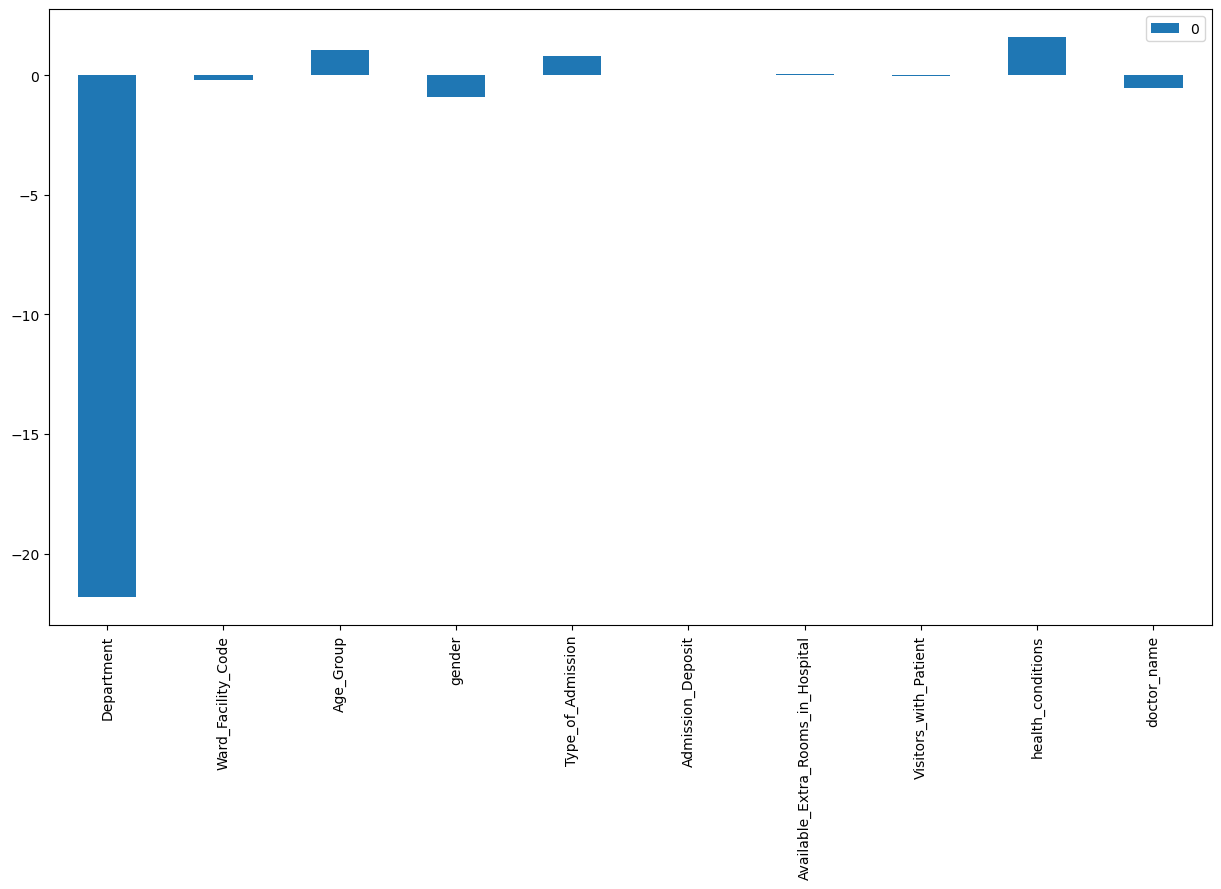

In [132]:
pd.DataFrame(ridge_1a.coef_,xtrain.columns).plot(kind='bar')

#### Lasso

In [133]:
lasso = Lasso(alpha = 0.01, max_iter = 500)
lasso.fit(xtrain, ytrain)

Lasso(alpha=0.01, max_iter=500)

In [134]:
# predict on train
pred_train_l = lasso.predict(xtrain)

# predict on test
pred_test_l  = lasso.predict(xtest)


print("RMSE Train :", np.sqrt(mean_squared_error(ytrain,
                                                 pred_train_l)))

print("RMSE Test  :", np.sqrt(mean_squared_error(ytest,
                                                 pred_test_l)))

RMSE Train : 5.357375294059509
RMSE Test  : 5.336736116860083


In [135]:
# r2_score (actual, predicted)

r2_train = r2_score(ytrain, pred_train_l)
r2_test = r2_score(ytest, pred_test_l)

print("R2 Train :", r2_train)
print("R2 Test :", r2_test)

R2 Train : 0.5411769141318283
R2 Test : 0.5441969541261886


<Axes: >

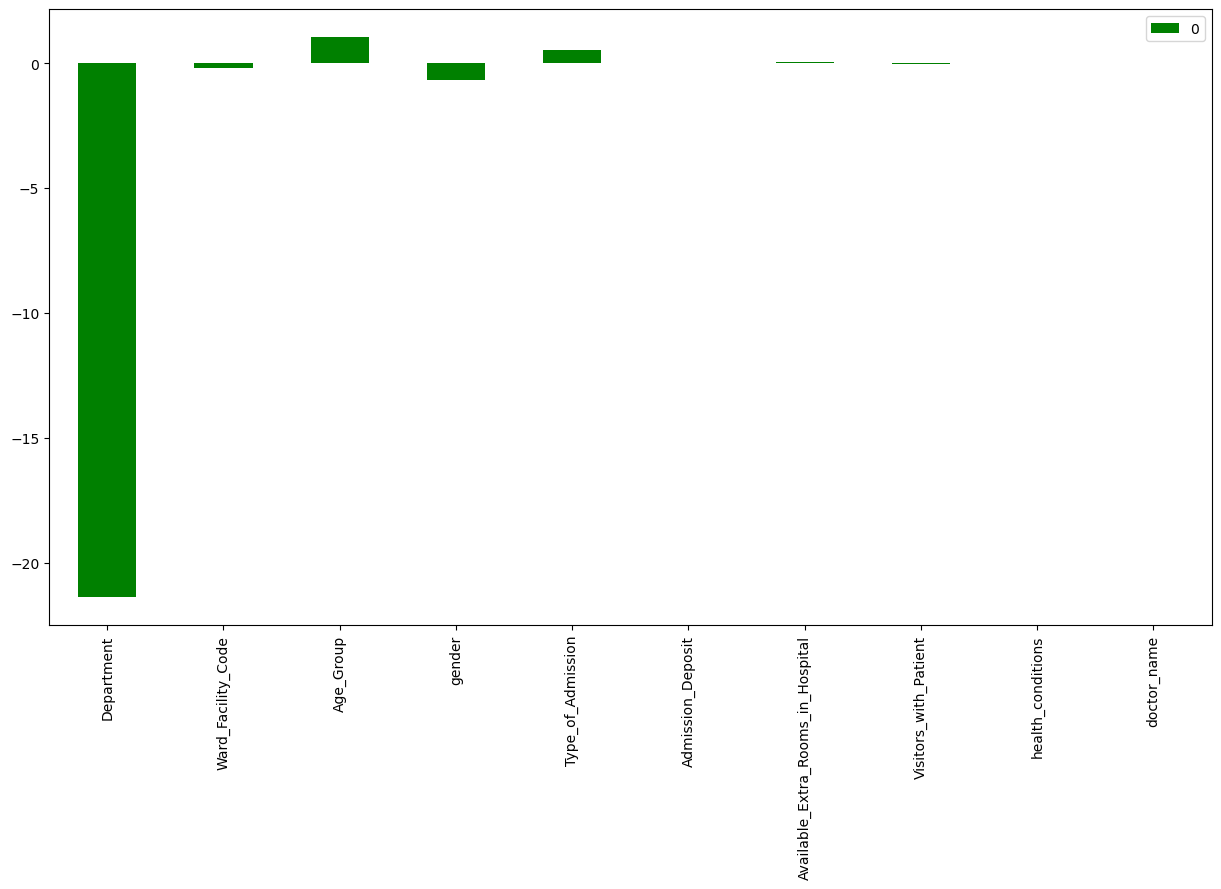

In [136]:
pd.DataFrame(lasso.coef_,xtrain.columns).plot(kind='bar', color='green')

#### Elastic net

In [137]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=500)

enet.fit(xtrain,ytrain)

ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=500)

In [138]:
# predict on train
pred_train_e = enet.predict(xtrain)

# predict on test
pred_test_e  = enet.predict(xtest)


print("RMSE Train :", np.sqrt(mean_squared_error(ytrain,
                                                 pred_train_e)))

print("RMSE Test  :", np.sqrt(mean_squared_error(ytest,
                                                 pred_test_e)))

RMSE Train : 5.921939101357638
RMSE Test  : 5.908611623369315


In [139]:
# r2_score (actual, predicted)

r2_train = r2_score(ytrain, pred_train_e)
r2_test = r2_score(ytest, pred_test_e)

print("R2 Train :", r2_train)
print("R2 Test :", r2_test)

R2 Train : 0.4393794743092303
R2 Test : 0.4412768656711771


<Axes: >

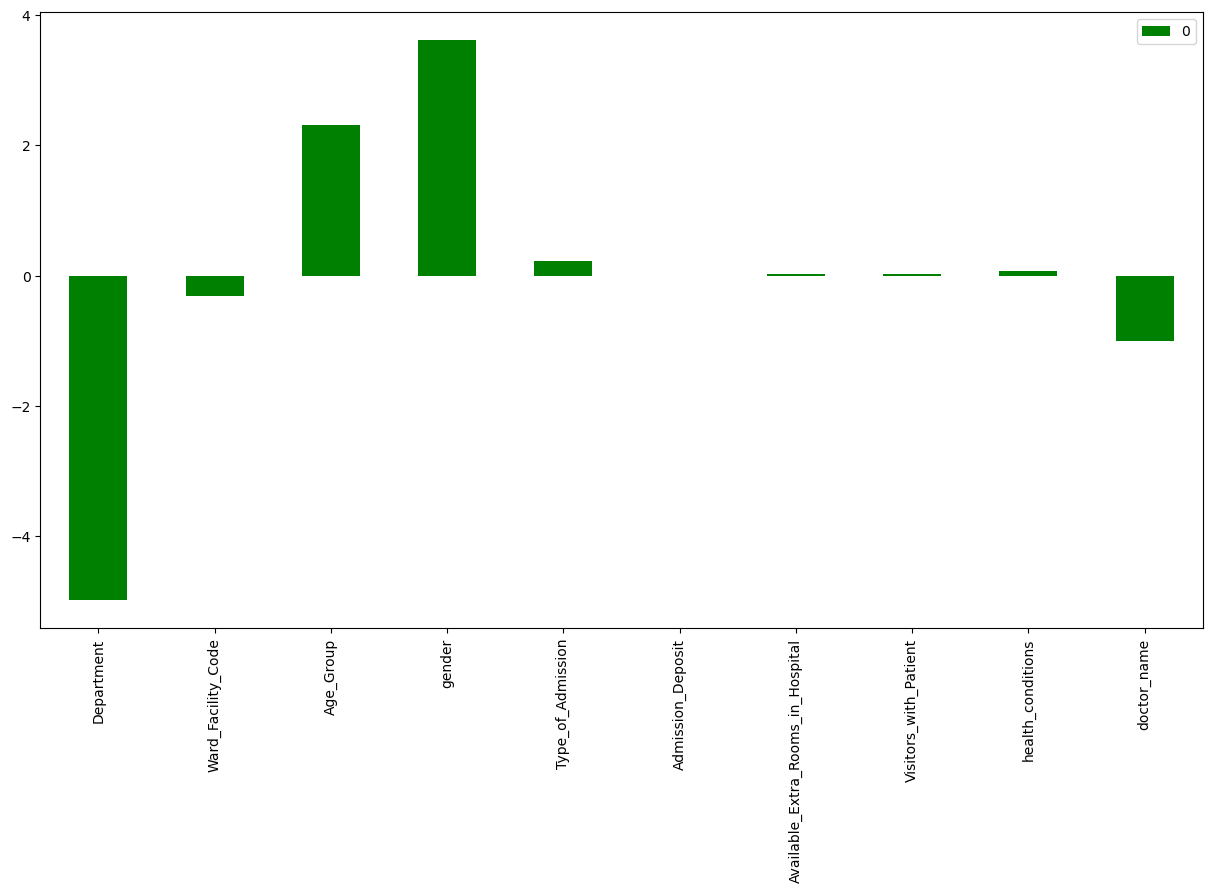

In [140]:
pd.DataFrame(enet.coef_,xtrain.columns).plot(kind='bar', color='green')

## Decision Tree Regressor

In [141]:
from sklearn.tree import DecisionTreeRegressor

dt=DecisionTreeRegressor(random_state=10)

In [142]:
dt.fit(xtrain, ytrain)
ypred_dt = dt.predict(xtest)

In [143]:
mse = mean_squared_error(ytest, ypred_dt)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 4.535386324504884


In [144]:
r2 = r2_score(ytest, ypred_dt)
print("R2 Score :", r2)

R2 Score : 0.6708041607589512


##### Feature Importance - Decision Tree regressor

In [145]:
feature_df = pd.DataFrame()
feature_df['Feature'] = xtrain.columns
feature_df['Importances'] = dt.feature_importances_
feature_df = feature_df.sort_values(by='Importances', ascending=False)
feature_df

Feature  Importances
0                         Department     0.633318
2                          Age_Group     0.179854
5                  Admission_Deposit     0.112977
8                  health_conditions     0.018960
6  Available_Extra_Rooms_in_Hospital     0.015792
7              Visitors_with_Patient     0.015123
4                  Type_of_Admission     0.006705
3                             gender     0.006690
1                 Ward_Facility_Code     0.005836
9                        doctor_name     0.004745

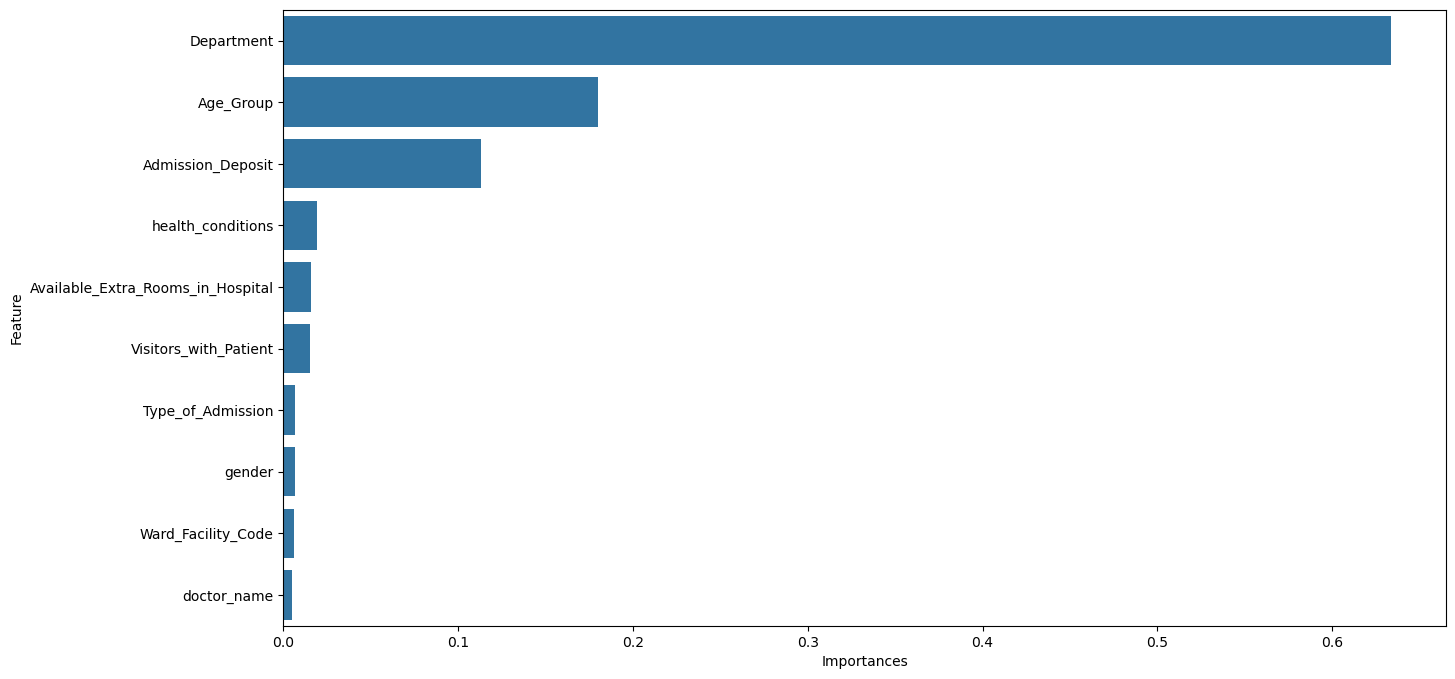

In [146]:
sns.barplot(x='Importances', y='Feature', data=feature_df)
plt.show()

### Decision Tree Regressor - Tunned

In [147]:
# Parameters to build the model on 
'''parameters = {
    'max_depth': [5, 10, 15, 20],  # Exploring various depths for flexibility and potential overfitting control
    'min_samples_split': [10, 20, 30],  # To ensure minimum samples for splits, improving stability
    'min_samples_leaf': [5, 10, 15],  # To manage leaves with enough samples for reducing overfitting
    'max_features': ['auto', 'sqrt', 'log2']  # To assess the optimal feature subset size
}

dt11 = DecisionTreeRegressor(random_state=10)'''

"parameters = {\n    'max_depth': [5, 10, 15, 20],  # Exploring various depths for flexibility and potential overfitting control\n    'min_samples_split': [10, 20, 30],  # To ensure minimum samples for splits, improving stability\n    'min_samples_leaf': [5, 10, 15],  # To manage leaves with enough samples for reducing overfitting\n    'max_features': ['auto', 'sqrt', 'log2']  # To assess the optimal feature subset size\n}\n\ndt11 = DecisionTreeRegressor(random_state=10)"

In [148]:
'''dtcv = GridSearchCV(dt11, parameters, cv=5, scoring="r2")
dtcv.fit(xtrain, ytrain)
print(dtcv.best_params_)
print(dtcv.best_score_)'''

'dtcv = GridSearchCV(dt11, parameters, cv=5, scoring="r2")\ndtcv.fit(xtrain, ytrain)\nprint(dtcv.best_params_)\nprint(dtcv.best_score_)'

In [149]:
dt1=DecisionTreeRegressor(max_depth = 10, max_features = 'sqrt', min_samples_leaf = 10, 
                          min_samples_split = 30, random_state=10)
dt1.fit(xtrain, ytrain)
ypred_dt1 = dt1.predict(xtest)

In [150]:
mse = mean_squared_error(ytest, ypred_dt1)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.3993944687654705


In [151]:
r2 = r2_score(ytest, ypred_dt1)
print("R2 Score :", r2)

R2 Score : 0.8150608352371875


### Ensemble Learning - Bagging

### Random Forest Regressor

In [152]:
from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor(random_state=10)

In [153]:
rf.fit(xtrain, ytrain)
ypred_rf = rf.predict(xtest)

In [154]:
mse = mean_squared_error(ytest, ypred_rf)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.423412765046269


In [155]:
r2 = r2_score(ytest, ypred_rf)
print("R2 Score :", r2)

R2 Score : 0.8124382412322542


##### Feature Importance - Random Forest regressor

In [156]:
feature_rf = pd.DataFrame()
feature_rf['Feature'] = xtrain.columns
feature_rf['Importances'] = rf.feature_importances_
feature_rf = feature_rf.sort_values(by='Importances', ascending=False)
feature_rf

Feature  Importances
0                         Department     0.629417
2                          Age_Group     0.179927
5                  Admission_Deposit     0.110690
8                  health_conditions     0.018601
6  Available_Extra_Rooms_in_Hospital     0.016545
7              Visitors_with_Patient     0.015426
9                        doctor_name     0.008667
3                             gender     0.007146
1                 Ward_Facility_Code     0.006817
4                  Type_of_Admission     0.006763

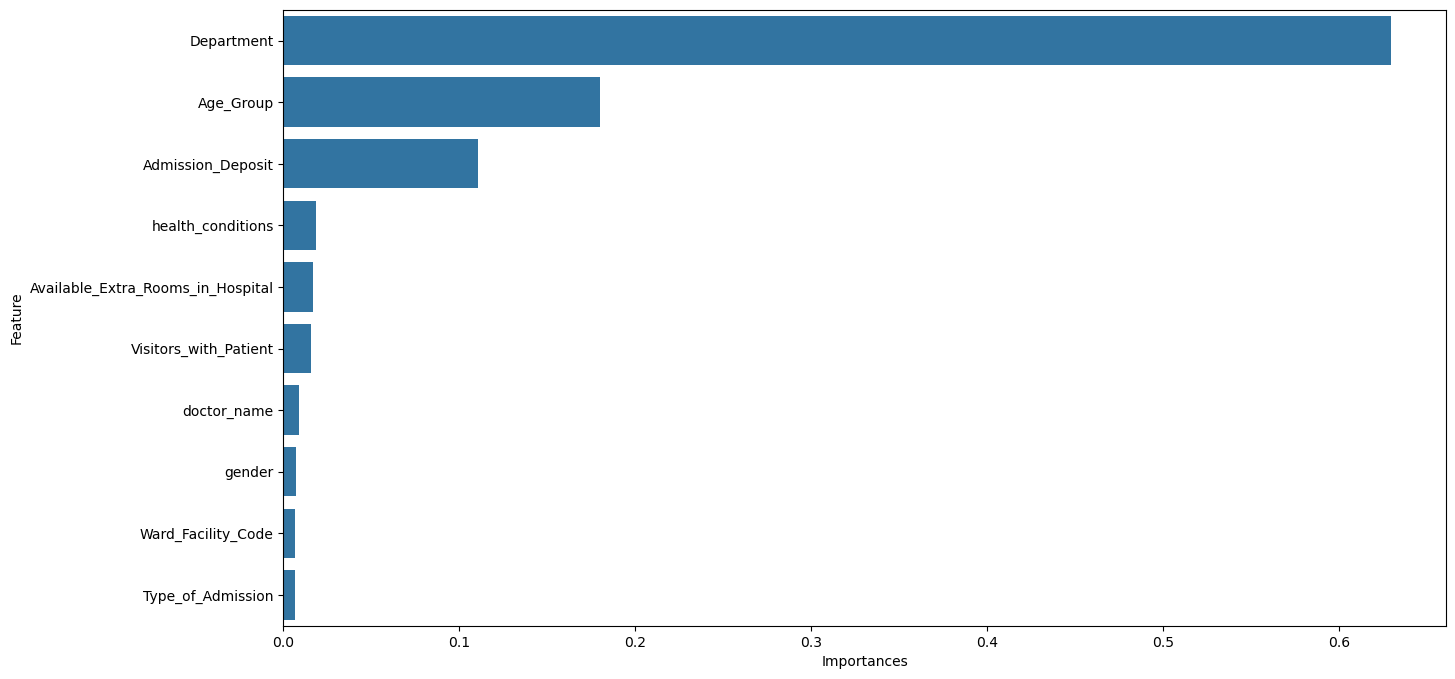

In [157]:
sns.barplot(x='Importances', y='Feature', data=feature_rf)
plt.show()

### Random Forest Regressor - Tunned

In [158]:
parameters = {
    'n_estimators': [50, 100, 200],  # A range to explore model complexity; higher values often improve stability
    'max_depth': [10, 15, 20, None],  # Deeper trees can capture more patterns but may overfit
    'min_samples_split': [2, 5, 10],  # Controls splits to ensure each split has sufficient data
    'min_samples_leaf': [1, 2, 4],  # Leaf nodes with enough samples reduce overfitting
    'max_features': ['sqrt', 'log2', None]  # Helps find the optimal subset size of features at each split
}

In [159]:
'''rf11 = RandomForestRegressor(random_state=10)

rfcv = GridSearchCV(rf11, parameters, cv=5, scoring="r2")
rfcv.fit(xtrain, ytrain)
print(rfcv.best_params_)
print(rfcv.best_score_)'''

'rf11 = RandomForestRegressor(random_state=10)\n\nrfcv = GridSearchCV(rf11, parameters, cv=5, scoring="r2")\nrfcv.fit(xtrain, ytrain)\nprint(rfcv.best_params_)\nprint(rfcv.best_score_)'

In [160]:
rf1=RandomForestRegressor(n_estimators = 200, max_depth = None, min_samples_split = 10, min_samples_leaf = 4,
                          max_features = 'sqrt', random_state=10)
rf1.fit(xtrain, ytrain)
ypred_rf1 = rf1.predict(xtest)

In [161]:
mse = mean_squared_error(ytest, ypred_rf1)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.310235255556546


In [162]:
r2 = r2_score(ytest, ypred_rf1)
print("R2 Score :", r2)

R2 Score : 0.8246347718195947


### Bagging Regressor

In [163]:
from sklearn.ensemble import BaggingRegressor

br=BaggingRegressor(random_state=10)

In [164]:
br.fit(xtrain, ytrain)
ypred_br = br.predict(xtest)

In [165]:
mse = mean_squared_error(ytest, ypred_br)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.5347004829412976


In [166]:
r2 = r2_score(ytest, ypred_br)
print("R2 Score :", r2)

R2 Score : 0.8000455823756443


### Bagging Regressor - Tunned

In [167]:
'''parameters = {
    'n_estimators': [10, 50, 100],  # Number of base estimators; higher values increase stability but require more computation
    'max_samples': [0.5, 0.7, 1.0],  # Proportion of samples drawn for each base estimator; values <1.0 apply subsampling
    'max_features': [0.5, 0.7, 1.0],  # Proportion of features to consider; values <1.0 apply feature sampling
    'bootstrap': [True, False],  # Whether to bootstrap samples; "True" uses replacement, "False" uses subsampling without replacement
    'bootstrap_features': [True, False]  # Whether to bootstrap features
}'''

'parameters = {\n    \'n_estimators\': [10, 50, 100],  # Number of base estimators; higher values increase stability but require more computation\n    \'max_samples\': [0.5, 0.7, 1.0],  # Proportion of samples drawn for each base estimator; values <1.0 apply subsampling\n    \'max_features\': [0.5, 0.7, 1.0],  # Proportion of features to consider; values <1.0 apply feature sampling\n    \'bootstrap\': [True, False],  # Whether to bootstrap samples; "True" uses replacement, "False" uses subsampling without replacement\n    \'bootstrap_features\': [True, False]  # Whether to bootstrap features\n}'

In [168]:
'''br11 = BaggingRegressor(random_state=10)

brcv = GridSearchCV(br11, parameters, cv=5, scoring="r2")
brcv.fit(xtrain, ytrain)
print(brcv.best_params_)
print(brcv.best_score_)'''

'br11 = BaggingRegressor(random_state=10)\n\nbrcv = GridSearchCV(br11, parameters, cv=5, scoring="r2")\nbrcv.fit(xtrain, ytrain)\nprint(brcv.best_params_)\nprint(brcv.best_score_)'

In [169]:
br1=BaggingRegressor(n_estimators = 100,max_samples = 0.5,max_features = 1.0,bootstrap = False,bootstrap_features = False,
                     random_state=10)
br1.fit(xtrain, ytrain)
ypred_br1 = br1.predict(xtest)

In [170]:
mse = mean_squared_error(ytest, ypred_br1)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.377185846092064


In [171]:
r2 = r2_score(ytest, ypred_br1)
print("R2 Score :", r2)

R2 Score : 0.8174693980701868


### Ensemble Learning - Boosting

### Adaboost Regressor

In [172]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor()

In [173]:
ada.fit(xtrain, ytrain)

ypred_ada = ada.predict(xtest)

In [174]:
mse = mean_squared_error(ytest, ypred_ada)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 4.122749435637886


In [175]:
r2 = r2_score(ytest, ypred_ada)
print("R2 Score :", r2)

R2 Score : 0.7279807449881976


### Adaboost Regressor - Tunned

In [176]:
'''parameters = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds; more estimators generally improve accuracy up to a point
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Controls contribution of each regressor; lower values increase stability
    'loss': ['linear', 'square', 'exponential']  # Different loss functions to explore impact on performance
}'''

"parameters = {\n    'n_estimators': [50, 100, 200],  # Number of boosting rounds; more estimators generally improve accuracy up to a point\n    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Controls contribution of each regressor; lower values increase stability\n    'loss': ['linear', 'square', 'exponential']  # Different loss functions to explore impact on performance\n}"

In [177]:
'''abr11=AdaBoostRegressor(random_state=10)

abrcv = GridSearchCV(abr11, parameters, cv=5, scoring="r2")
abrcv.fit(xtrain, ytrain)
print(abrcv.best_params_)
print(abrcv.best_score_)'''

'abr11=AdaBoostRegressor(random_state=10)\n\nabrcv = GridSearchCV(abr11, parameters, cv=5, scoring="r2")\nabrcv.fit(xtrain, ytrain)\nprint(abrcv.best_params_)\nprint(abrcv.best_score_)'

In [178]:
abr1=AdaBoostRegressor(n_estimators = 50,learning_rate = 0.1,loss = 'linear',random_state=10)
abr1.fit(xtrain, ytrain)
ypred_abr1 = abr1.predict(xtest)

In [179]:
mse = mean_squared_error(ytest, ypred_abr1)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 4.154879103254939


In [180]:
r2 = r2_score(ytest, ypred_abr1)
print("R2 Score :", r2)

R2 Score : 0.7237243891234526


### Gradient Boosting Regressor

In [181]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=10)

In [182]:
gbr.fit(xtrain, ytrain)
ypred_gbr = gbr.predict(xtest)

In [183]:
mse = mean_squared_error(ytest, ypred_gbr)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.4168047357626277


In [184]:
r2 = r2_score(ytest, ypred_gbr)
print("R2 Score :", r2)

R2 Score : 0.8131616231278972


### Gradient Boosting Regressor - Tunned

In [185]:
'''parameters = {
    'n_estimators': [50, 100, 200],          # Number of boosting stages; higher values can improve accuracy at a cost of computation time
    'learning_rate': [0.01, 0.1, 0.2],       # Shrinks contribution of each tree; lower values improve stability but require more estimators
    'max_depth': [3, 5, 7],                  # Limits tree depth to control overfitting
    'min_samples_split': [2, 5, 10],         # Minimum samples to split a node; higher values can prevent overfitting
    'min_samples_leaf': [1, 2, 4],           # Minimum samples in each leaf; higher values can smooth model
    'subsample': [0.8, 1.0]                  # Fraction of samples for training each tree; values <1.0 introduce randomness
}'''

"parameters = {\n    'n_estimators': [50, 100, 200],          # Number of boosting stages; higher values can improve accuracy at a cost of computation time\n    'learning_rate': [0.01, 0.1, 0.2],       # Shrinks contribution of each tree; lower values improve stability but require more estimators\n    'max_depth': [3, 5, 7],                  # Limits tree depth to control overfitting\n    'min_samples_split': [2, 5, 10],         # Minimum samples to split a node; higher values can prevent overfitting\n    'min_samples_leaf': [1, 2, 4],           # Minimum samples in each leaf; higher values can smooth model\n    'subsample': [0.8, 1.0]                  # Fraction of samples for training each tree; values <1.0 introduce randomness\n}"

In [186]:
'''gbr11=GradientBoostingRegressor(random_state=10)

gbrcv = GridSearchCV(gbr11, parameters, cv=5, scoring="r2")
gbrcv.fit(xtrain, ytrain)
print(gbrcv.best_params_)
print(gbrcv.best_score_)'''

'gbr11=GradientBoostingRegressor(random_state=10)\n\ngbrcv = GridSearchCV(gbr11, parameters, cv=5, scoring="r2")\ngbrcv.fit(xtrain, ytrain)\nprint(gbrcv.best_params_)\nprint(gbrcv.best_score_)'

In [187]:
gbr1 = GradientBoostingRegressor(n_estimators = 50,learning_rate = 0.1,max_depth = 5,min_samples_split = 2,
                                min_samples_leaf = 4,subsample = 1.0,random_state=10)
gbr1.fit(xtrain, ytrain)
ypred_gbr1 = gbr1.predict(xtest)

In [188]:
mse = mean_squared_error(ytest, ypred_gbr1)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.3539610567685694


In [189]:
r2 = r2_score(ytest, ypred_gbr1)
print("R2 Score :", r2)

R2 Score : 0.8199712788860872


### XGBoost Regressor

In [190]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=10)

In [191]:
xgb.fit(xtrain, ytrain)
ypred_xgb = xgb.predict(xtest)

In [192]:
mse = mean_squared_error(ytest, ypred_xgb)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.290132938615168


In [193]:
r2 = r2_score(ytest, ypred_xgb)
print("R2 Score :", r2)

R2 Score : 0.8267582120631428


### XG Boost Regressor - Tunned

In [194]:
'''parameters = {
    'n_estimators': [50, 100, 200],           # Number of boosting rounds; higher values improve accuracy but increase training time
    'learning_rate': [0.01, 0.1, 0.2],        # Shrinks contribution of each tree; lower values increase stability
    'max_depth': [3, 5, 7],                   # Controls tree depth, balancing model complexity
    'min_child_weight': [1, 3, 5],            # Minimum sum of instance weight needed in a child; helps prevent overfitting
    'subsample': [0.8, 1.0],                  # Fraction of samples per tree; values <1.0 add randomness
    'colsample_bytree': [0.8, 1.0],           # Fraction of features used for each tree; values <1.0 improve generalization
    'gamma': [0, 0.1, 0.2]                    # Minimum loss reduction for node splitting; higher values make model more conservative
}'''

"parameters = {\n    'n_estimators': [50, 100, 200],           # Number of boosting rounds; higher values improve accuracy but increase training time\n    'learning_rate': [0.01, 0.1, 0.2],        # Shrinks contribution of each tree; lower values increase stability\n    'max_depth': [3, 5, 7],                   # Controls tree depth, balancing model complexity\n    'min_child_weight': [1, 3, 5],            # Minimum sum of instance weight needed in a child; helps prevent overfitting\n    'subsample': [0.8, 1.0],                  # Fraction of samples per tree; values <1.0 add randomness\n    'colsample_bytree': [0.8, 1.0],           # Fraction of features used for each tree; values <1.0 improve generalization\n    'gamma': [0, 0.1, 0.2]                    # Minimum loss reduction for node splitting; higher values make model more conservative\n}"

In [195]:
'''xgb11=XGBRegressor(random_state=10)

xgbcv = GridSearchCV(xgb11, parameters, cv=5, scoring="r2")
xgbcv.fit(xtrain, ytrain)
print(xgbcv.best_params_)
print(xgbcv.best_score_)'''

'xgb11=XGBRegressor(random_state=10)\n\nxgbcv = GridSearchCV(xgb11, parameters, cv=5, scoring="r2")\nxgbcv.fit(xtrain, ytrain)\nprint(xgbcv.best_params_)\nprint(xgbcv.best_score_)'

In [196]:
xgb1 = XGBRegressor(n_estimators = 50,learning_rate = 0.1,max_depth = 5,min_child_weight = 5,
                    subsample = 1.0,colsample_bytree = 1.0,gamma = 0,random_state=10)
xgb1.fit(xtrain, ytrain)
ypred_xgb1 = xgb1.predict(xtest)

In [197]:
mse = mean_squared_error(ytest, ypred_xgb1)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.3528081284225


In [198]:
r2 = r2_score(ytest, ypred_xgb1)
print("R2 Score :", r2)

R2 Score : 0.8200950278131757


## Cat Boost Regressor

In [199]:
from catboost import CatBoostRegressor

In [200]:
catboost = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, verbose=0)

# Fit model
catboost.fit(xtrain, ytrain)

# Make predictions
ypred_catboost = catboost.predict(xtest)

In [201]:
mse = mean_squared_error(ytest, ypred_catboost)
rmse = math.sqrt(mse)

print("RMSE :", rmse)

RMSE : 3.4213344242042583


In [203]:
r2 = r2_score(ytest, ypred_catboost)
print("R2 Score :", r2)

R2 Score : 0.8126659081611958


#### Scorecard

In [218]:
mod = []
r_squared_train = []
r_squared_test = []
mse = []
rmse = []
mae = []
mape = []

def model_validation(model, xtrain, ytrain, xtest, ytest):
    global scorecard
    
    # Fit the model
    m = model
    m.fit(xtrain, ytrain)
    
    # Predict values
    y_pred_train = m.predict(xtrain)
    y_pred_test = m.predict(xtest)

    # Calculate metrics
    print('R-Squared Train: ', r2_score(ytrain, y_pred_train))
    print('R-Squared Test: ', r2_score(ytest, y_pred_test))
    print('Mean squared error: ', mean_squared_error(ytest, y_pred_test))
    print('Root mean squared error: ', mean_squared_error(ytest, y_pred_test)**0.5)
    print('Mean absolute error: ', mean_absolute_error(ytest, y_pred_test))
    print('Mean absolute percentage error: ', mean_absolute_percentage_error(ytest, y_pred_test))
    
    # Residuals plot
    residuals = ytest - y_pred_test
    plt.scatter(y_pred_test, residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f'Residuals Plot')
    plt.show()
    
    # Save results
    ans = input('Do you want to save the result? Y/N: ')
    if ans.lower() == 'y':
        mod.append(str(model))
        r_squared_train.append(r2_score(ytrain, y_pred_train))
        r_squared_test.append(r2_score(ytest, y_pred_test))
        mse.append(mean_squared_error(ytest, y_pred_test))
        rmse.append(mean_squared_error(ytest, y_pred_test)**0.5)
        mae.append(mean_absolute_error(ytest, y_pred_test))
        mape.append(mean_absolute_percentage_error(ytest, y_pred_test))
        scorecard = pd.DataFrame({
            'Model': mod,
            'R-squared Train': r_squared_train,
            'R-squared Test': r_squared_test,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
        })
    else:
        return

R-Squared Train:  0.5415008495152853
R-Squared Test:  0.5445294394971116
Mean squared error:  28.459977106227665
Root mean squared error:  5.334789321634704
Mean absolute error:  3.123672239635833
Mean absolute percentage error:  0.3036843387273962


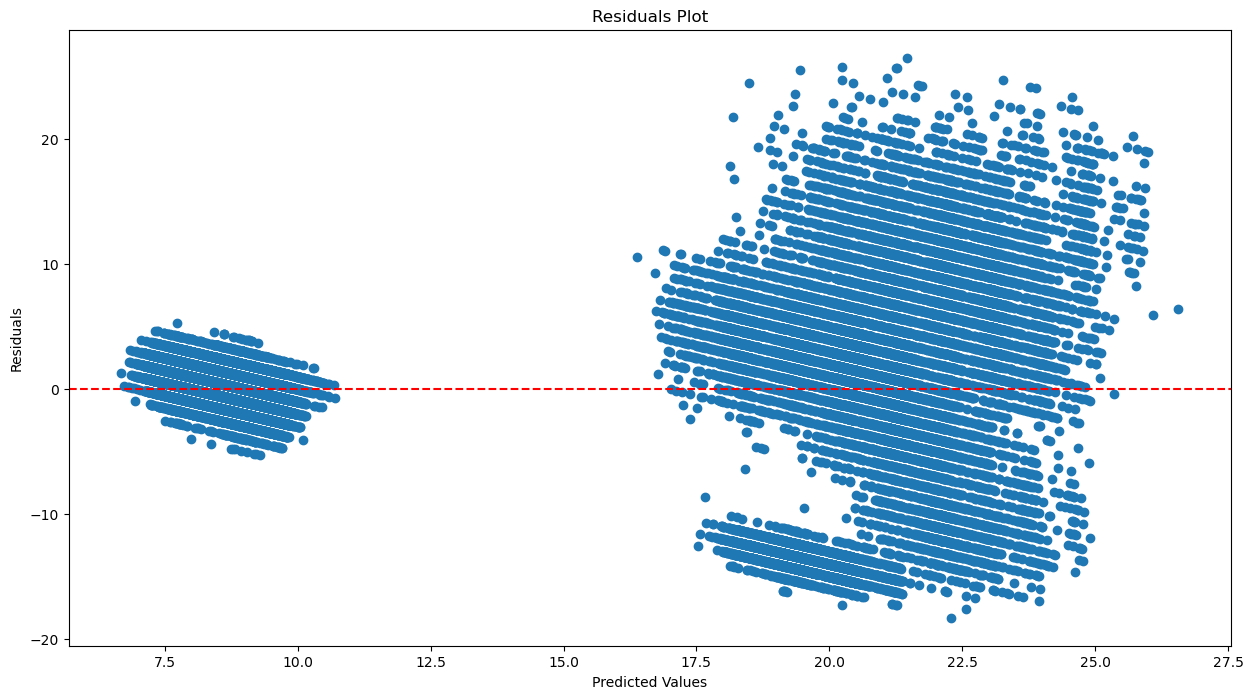

Do you want to save the result? Y/N:  y


In [219]:
model_validation(LinearRegression(), xtrain, ytrain, xtest, ytest)

In [220]:
scorecard

Model  R-squared Train  R-squared Test        MSE      RMSE  \
0  LinearRegression()         0.541501        0.544529  28.459977  5.334789   

        MAE      MAPE  
0  3.123672  0.303684

R-Squared Train:  0.5415008433389359
R-Squared Test:  0.5445292091000512
Mean squared error:  28.459991502536965
Root mean squared error:  5.334790670920178
Mean absolute error:  3.1237197035343125
Mean absolute percentage error:  0.303686365878069


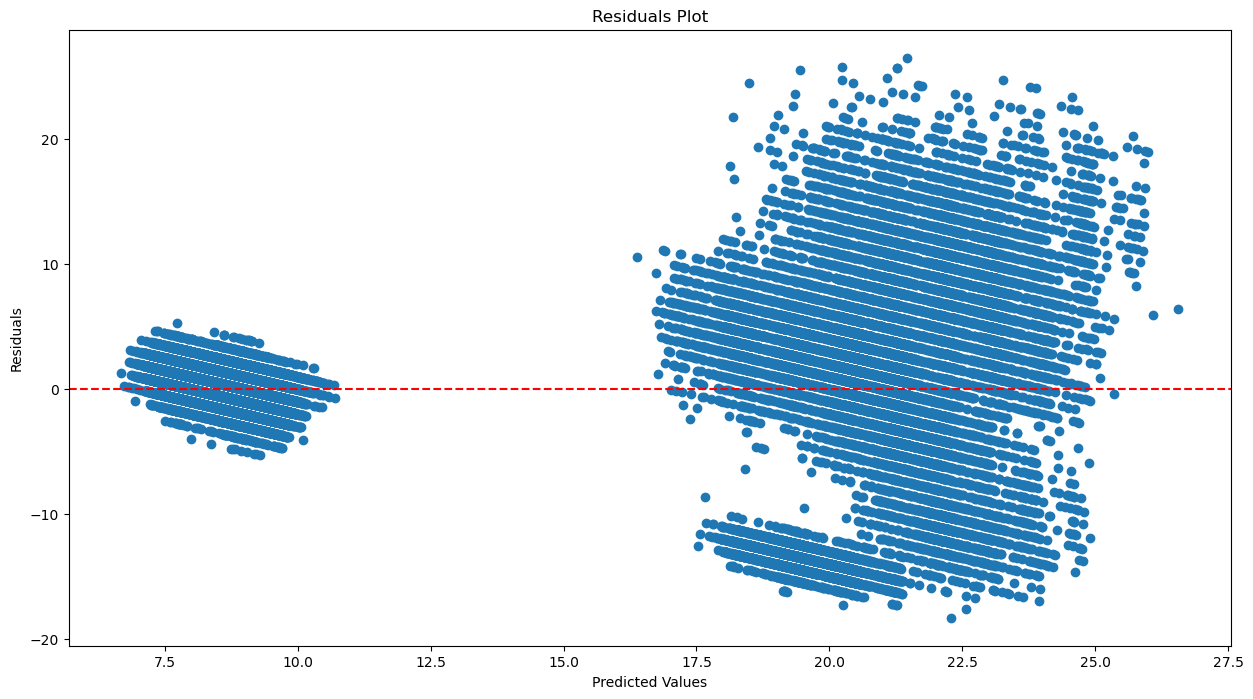

Do you want to save the result? Y/N:  y


In [221]:
model_validation(Ridge(alpha=1, max_iter=500), xtrain, ytrain, xtest, ytest)

In [222]:
scorecard

Model  R-squared Train  R-squared Test        MSE  \
0            LinearRegression()         0.541501        0.544529  28.459977   
1  Ridge(alpha=1, max_iter=500)         0.541501        0.544529  28.459992   

       RMSE       MAE      MAPE  
0  5.334789  3.123672  0.303684  
1  5.334791  3.123720  0.303686

R-Squared Train:  0.5411769141318283
R-Squared Test:  0.5441969541261886
Mean squared error:  28.48075238099883
Root mean squared error:  5.336736116860083
Mean absolute error:  3.1220362068003475
Mean absolute percentage error:  0.3030555996676457


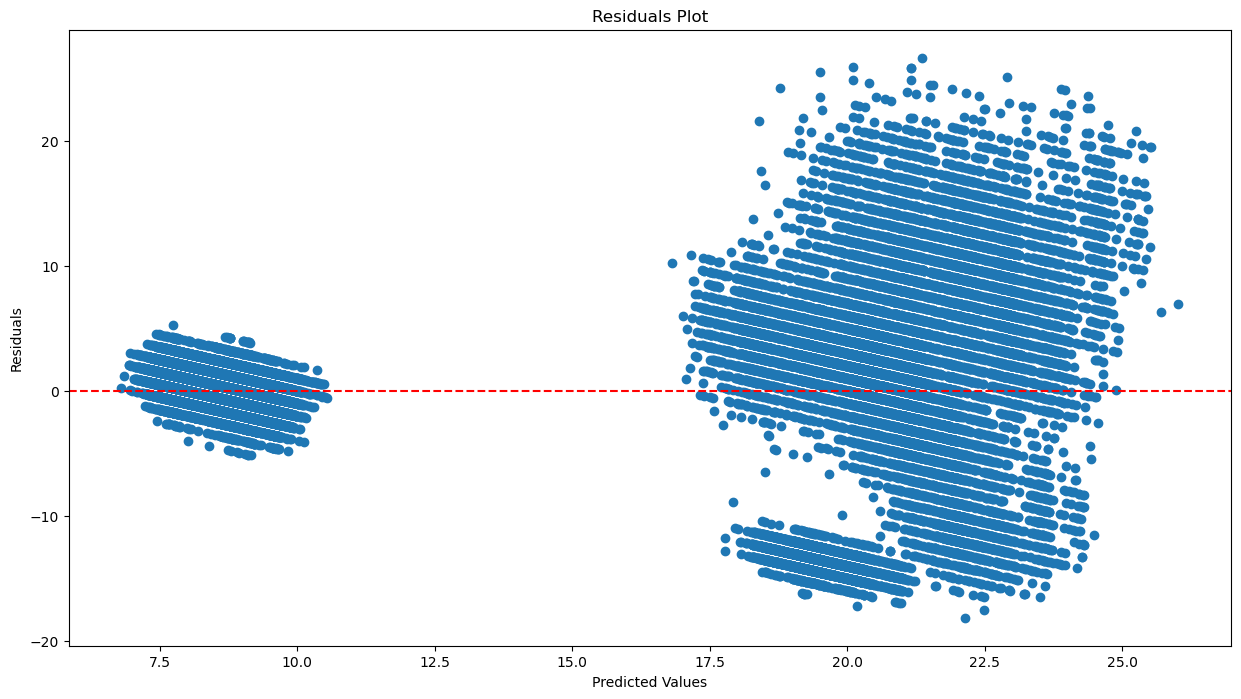

Do you want to save the result? Y/N:  y


In [223]:
model_validation(Lasso(alpha = 0.01, max_iter = 500), xtrain, ytrain, xtest, ytest)

In [224]:
scorecard

Model  R-squared Train  R-squared Test  \
0               LinearRegression()         0.541501        0.544529   
1     Ridge(alpha=1, max_iter=500)         0.541501        0.544529   
2  Lasso(alpha=0.01, max_iter=500)         0.541177        0.544197   

         MSE      RMSE       MAE      MAPE  
0  28.459977  5.334789  3.123672  0.303684  
1  28.459992  5.334791  3.123720  0.303686  
2  28.480752  5.336736  3.122036  0.303056

R-Squared Train:  0.4393794743092303
R-Squared Test:  0.4412768656711771
Mean squared error:  34.91169131581497
Root mean squared error:  5.908611623369315
Mean absolute error:  3.77858092616464
Mean absolute percentage error:  0.3424586877089373


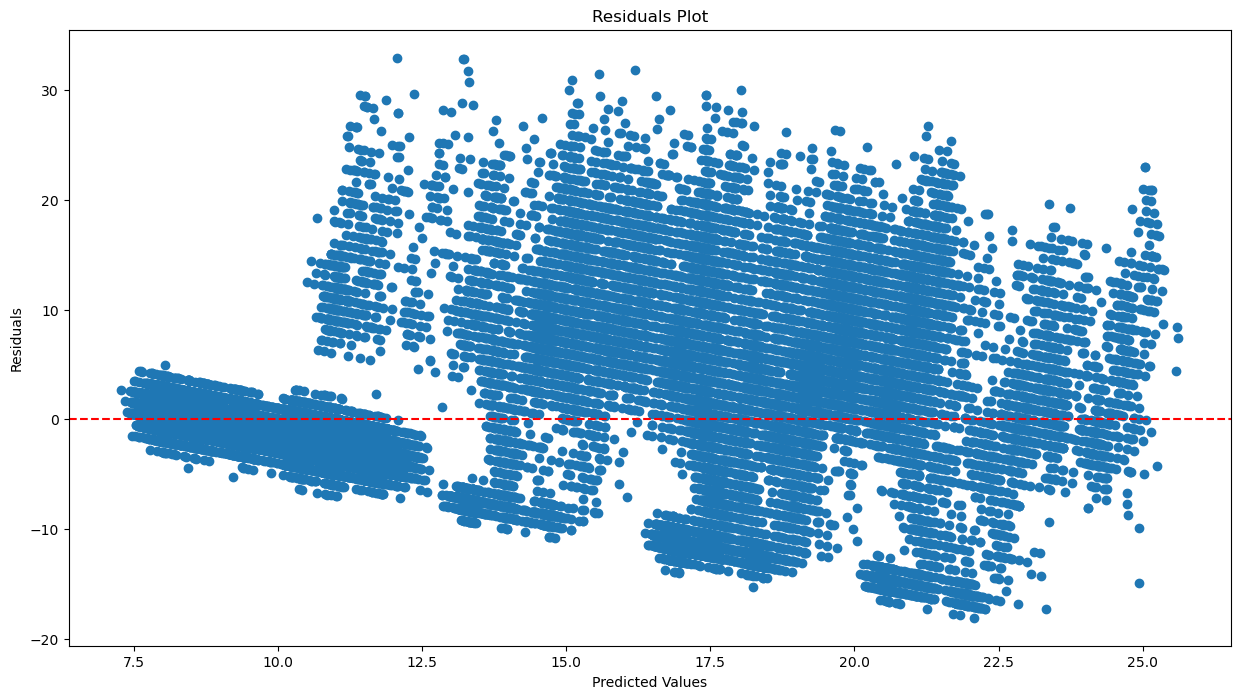

Do you want to save the result? Y/N:  y


In [225]:
model_validation(ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=500), xtrain, ytrain, xtest, ytest)

In [226]:
scorecard

Model  R-squared Train  \
0                                 LinearRegression()         0.541501   
1                       Ridge(alpha=1, max_iter=500)         0.541501   
2                    Lasso(alpha=0.01, max_iter=500)         0.541177   
3  ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   

   R-squared Test        MSE      RMSE       MAE      MAPE  
0        0.544529  28.459977  5.334789  3.123672  0.303684  
1        0.544529  28.459992  5.334791  3.123720  0.303686  
2        0.544197  28.480752  5.336736  3.122036  0.303056  
3        0.441277  34.911691  5.908612  3.778581  0.342459

R-Squared Train:  0.9999993972706033
R-Squared Test:  0.6708041607589512
Mean squared error:  20.569729112505925
Root mean squared error:  4.535386324504884
Mean absolute error:  2.1293322608907976
Mean absolute percentage error:  0.17896546978636782


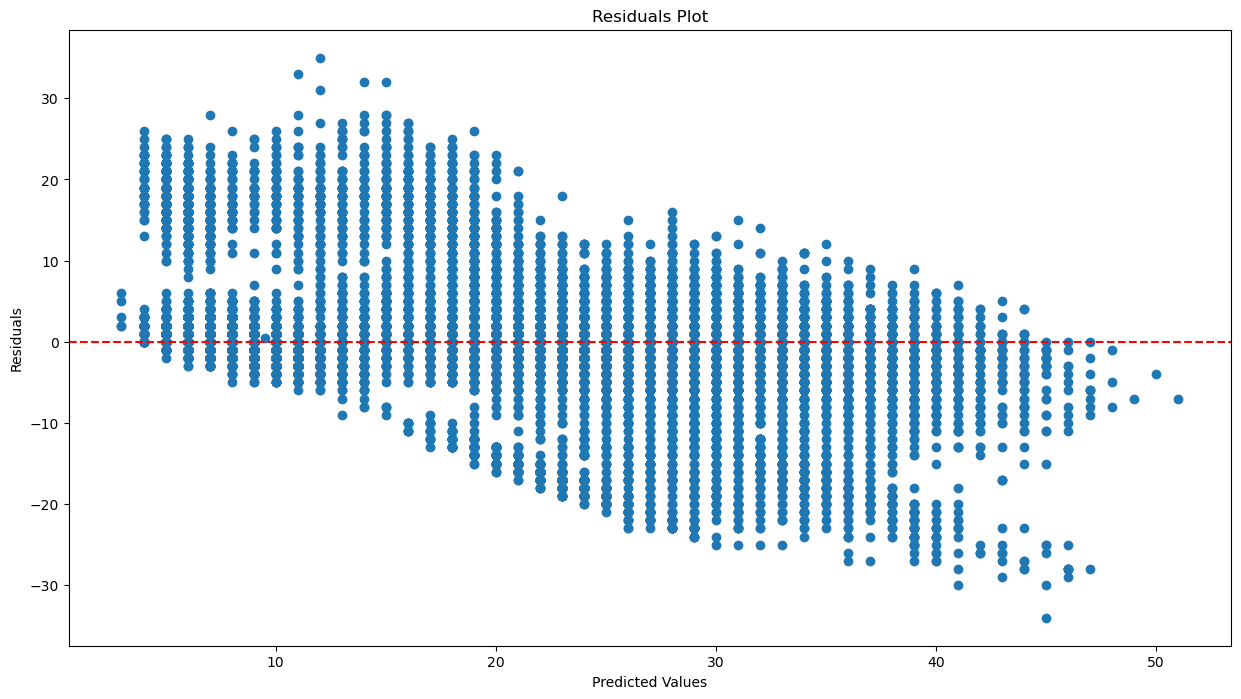

Do you want to save the result? Y/N:  y


In [227]:
model_validation(DecisionTreeRegressor(random_state=10), xtrain, ytrain, xtest, ytest)

In [228]:
scorecard

Model  R-squared Train  \
0                                 LinearRegression()         0.541501   
1                       Ridge(alpha=1, max_iter=500)         0.541501   
2                    Lasso(alpha=0.01, max_iter=500)         0.541177   
3  ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4             DecisionTreeRegressor(random_state=10)         0.999999   

   R-squared Test        MSE      RMSE       MAE      MAPE  
0        0.544529  28.459977  5.334789  3.123672  0.303684  
1        0.544529  28.459992  5.334791  3.123720  0.303686  
2        0.544197  28.480752  5.336736  3.122036  0.303056  
3        0.441277  34.911691  5.908612  3.778581  0.342459  
4        0.670804  20.569729  4.535386  2.129332  0.178965

R-Squared Train:  0.8199048637898586
R-Squared Test:  0.8150608352371875
Mean squared error:  11.555882754273275
Root mean squared error:  3.3993944687654705
Mean absolute error:  1.949309871065789
Mean absolute percentage error:  0.16419754168370762


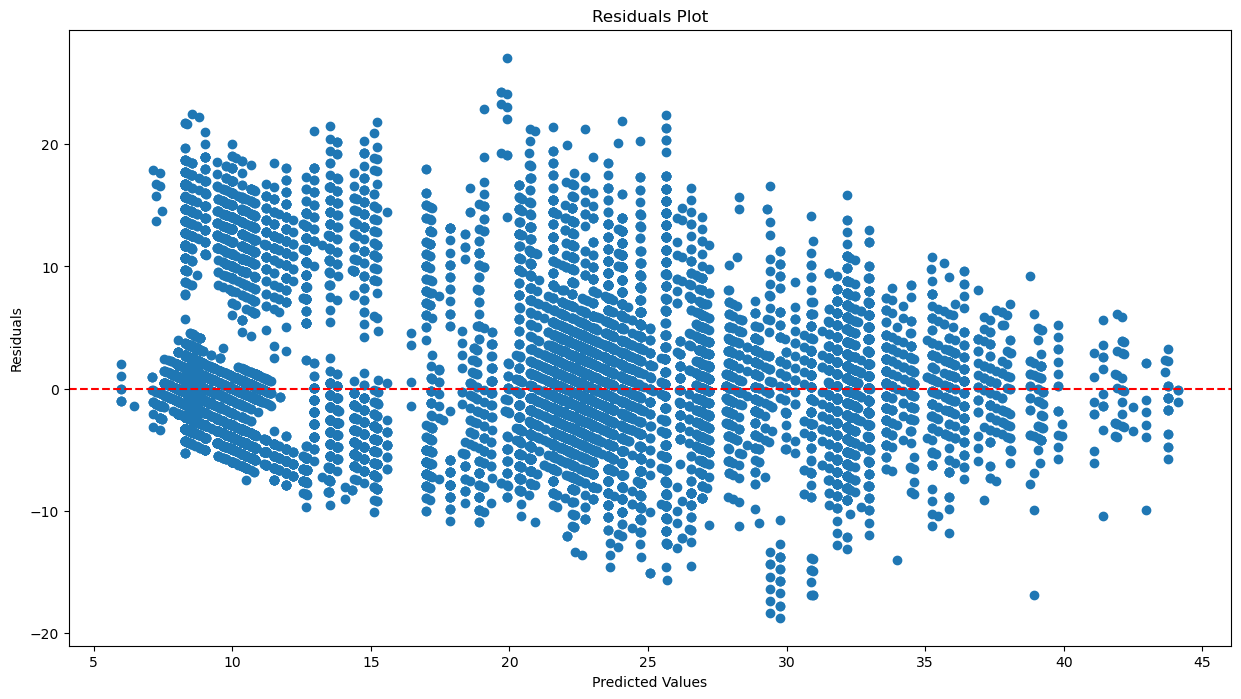

Do you want to save the result? Y/N:  y


In [229]:
model_validation(DecisionTreeRegressor(max_depth = 10, max_features = 'sqrt', min_samples_leaf = 10, 
                          min_samples_split = 30, random_state=10), xtrain, ytrain, xtest, ytest)

In [230]:
scorecard

Model  R-squared Train  \
0                                 LinearRegression()         0.541501   
1                       Ridge(alpha=1, max_iter=500)         0.541501   
2                    Lasso(alpha=0.01, max_iter=500)         0.541177   
3  ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4             DecisionTreeRegressor(random_state=10)         0.999999   
5  DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   

   R-squared Test        MSE      RMSE       MAE      MAPE  
0        0.544529  28.459977  5.334789  3.123672  0.303684  
1        0.544529  28.459992  5.334791  3.123720  0.303686  
2        0.544197  28.480752  5.336736  3.122036  0.303056  
3        0.441277  34.911691  5.908612  3.778581  0.342459  
4        0.670804  20.569729  4.535386  2.129332  0.178965  
5        0.815061  11.555883  3.399394  1.949310  0.164198

R-Squared Train:  0.9737686062952273
R-Squared Test:  0.8124382412322542
Mean squared error:  11.71975495988174
Root mean squared error:  3.423412765046269
Mean absolute error:  1.7897911189036464
Mean absolute percentage error:  0.15240734050356602


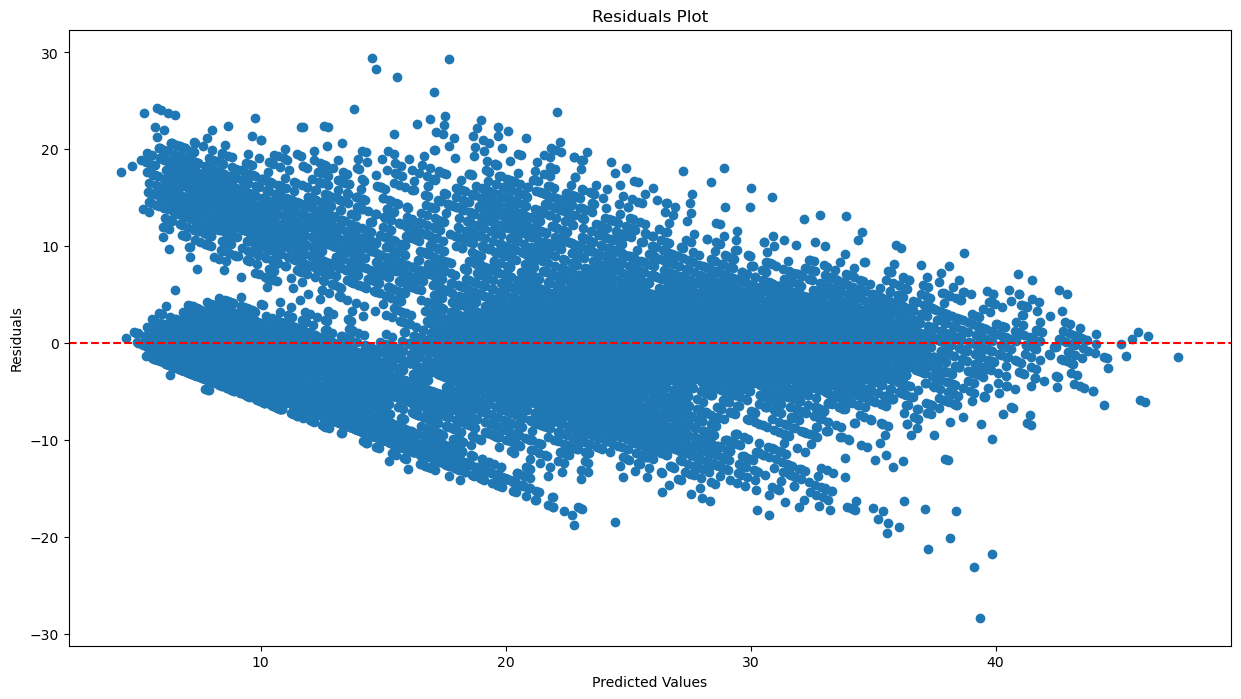

Do you want to save the result? Y/N:  y


In [231]:
model_validation(RandomForestRegressor(random_state=10), xtrain, ytrain, xtest, ytest)

In [232]:
scorecard

Model  R-squared Train  \
0                                 LinearRegression()         0.541501   
1                       Ridge(alpha=1, max_iter=500)         0.541501   
2                    Lasso(alpha=0.01, max_iter=500)         0.541177   
3  ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4             DecisionTreeRegressor(random_state=10)         0.999999   
5  DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6             RandomForestRegressor(random_state=10)         0.973769   

   R-squared Test        MSE      RMSE       MAE      MAPE  
0        0.544529  28.459977  5.334789  3.123672  0.303684  
1        0.544529  28.459992  5.334791  3.123720  0.303686  
2        0.544197  28.480752  5.336736  3.122036  0.303056  
3        0.441277  34.911691  5.908612  3.778581  0.342459  
4        0.670804  20.569729  4.535386  2.129332  0.178965  
5        0.815061  11.555883  3.399394  1.949310  0.164198  
6        0.812438  11.719755  3.423413  1.789791  0.152407

R-Squared Train:  0.8764716269935326
R-Squared Test:  0.8246347718195947
Mean squared error:  10.957657447129511
Root mean squared error:  3.310235255556546
Mean absolute error:  1.8175144995031698
Mean absolute percentage error:  0.15336204946596446


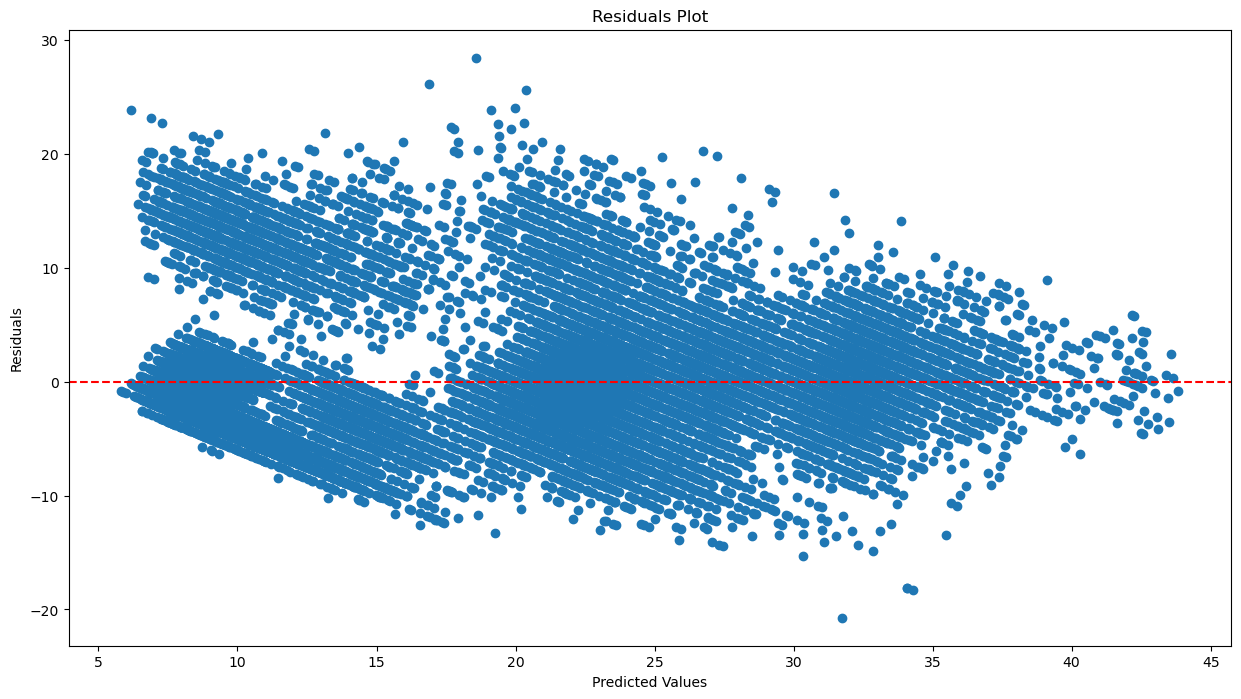

Do you want to save the result? Y/N:  y


In [233]:
model_validation(RandomForestRegressor(n_estimators = 200, max_depth = None, min_samples_split = 10, min_samples_leaf = 4,
                          max_features = 'sqrt', random_state=10), xtrain, ytrain, xtest, ytest)

In [234]:
scorecard

Model  R-squared Train  \
0                                 LinearRegression()         0.541501   
1                       Ridge(alpha=1, max_iter=500)         0.541501   
2                    Lasso(alpha=0.01, max_iter=500)         0.541177   
3  ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4             DecisionTreeRegressor(random_state=10)         0.999999   
5  DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6             RandomForestRegressor(random_state=10)         0.973769   
7  RandomForestRegressor(max_features='sqrt', min...         0.876472   

   R-squared Test        MSE      RMSE       MAE      MAPE  
0        0.544529  28.459977  5.334789  3.123672  0.303684  
1        0.544529  28.459992  5.334791  3.123720  0.303686  
2        0.544197  28.480752  5.336736  3.122036  0.303056  
3        0.441277  34.911691  5.908612  3.778581  0.342459  
4        0.670804  20.569729  4.535386  2.129332  0.178965  
5        0.815061  11.555883  3.399394  1.949310  0.164198  
6        0.812438  11.719755  3.423413  1.789791  0.152407  
7        0.824635  10.957657  3.310235  1.817514  0.153362

R-Squared Train:  0.9647957650031361
R-Squared Test:  0.8000455823756443
Mean squared error:  12.494107504105443
Root mean squared error:  3.5347004829412976
Mean absolute error:  1.831221363629835
Mean absolute percentage error:  0.15597813653643133


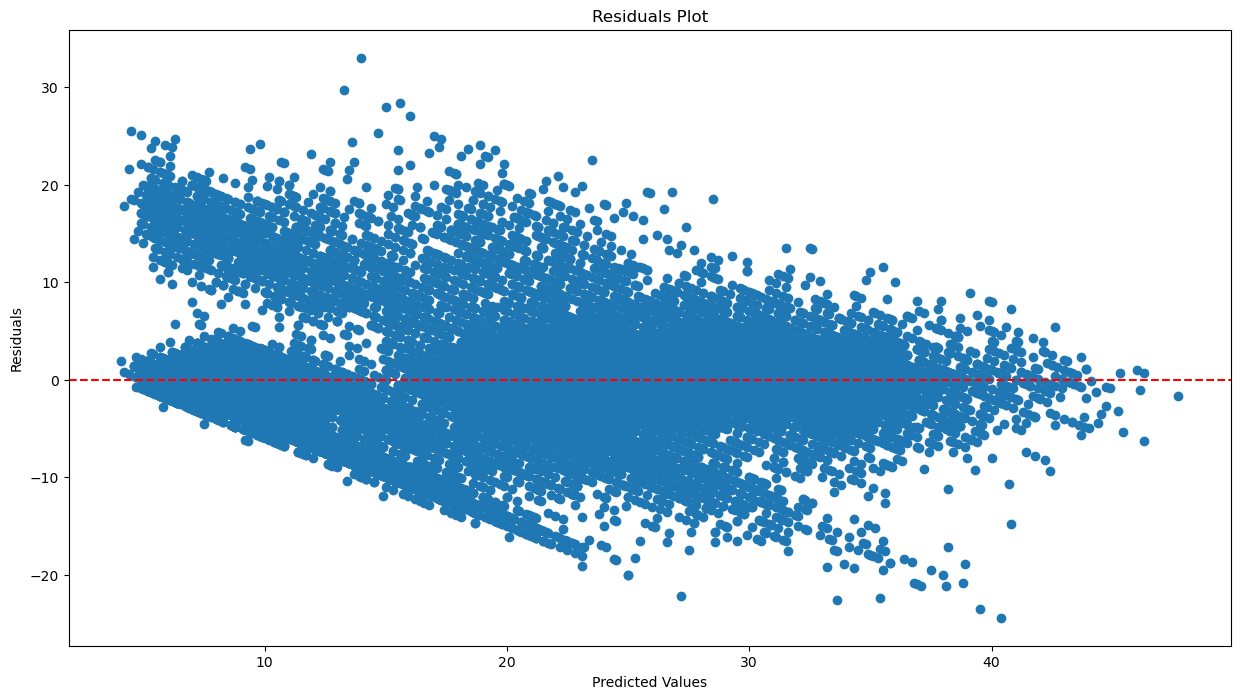

Do you want to save the result? Y/N:  y


In [235]:
model_validation(BaggingRegressor(random_state=10), xtrain, ytrain, xtest, ytest)

In [236]:
scorecard

Model  R-squared Train  \
0                                 LinearRegression()         0.541501   
1                       Ridge(alpha=1, max_iter=500)         0.541501   
2                    Lasso(alpha=0.01, max_iter=500)         0.541177   
3  ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4             DecisionTreeRegressor(random_state=10)         0.999999   
5  DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6             RandomForestRegressor(random_state=10)         0.973769   
7  RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                  BaggingRegressor(random_state=10)         0.964796   

   R-squared Test        MSE      RMSE       MAE      MAPE  
0        0.544529  28.459977  5.334789  3.123672  0.303684  
1        0.544529  28.459992  5.334791  3.123720  0.303686  
2        0.544197  28.480752  5.336736  3.122036  0.303056  
3        0.441277  34.911691  5.908612  3.778581  0.342459  
4        0.670804  20.569729  4.535386  2.129332  0.178965  
5        0.815061  11.555883  3.399394  1.949310  0.164198  
6        0.812438  11.719755  3.423413  1.789791  0.152407  
7        0.824635  10.957657  3.310235  1.817514  0.153362  
8        0.800046  12.494108  3.534700  1.831221  0.155978

R-Squared Train:  0.9533811801111937
R-Squared Test:  0.8174693980701868
Mean squared error:  11.405384239044569
Root mean squared error:  3.377185846092064
Mean absolute error:  1.7812947589158754
Mean absolute percentage error:  0.15179309672425279


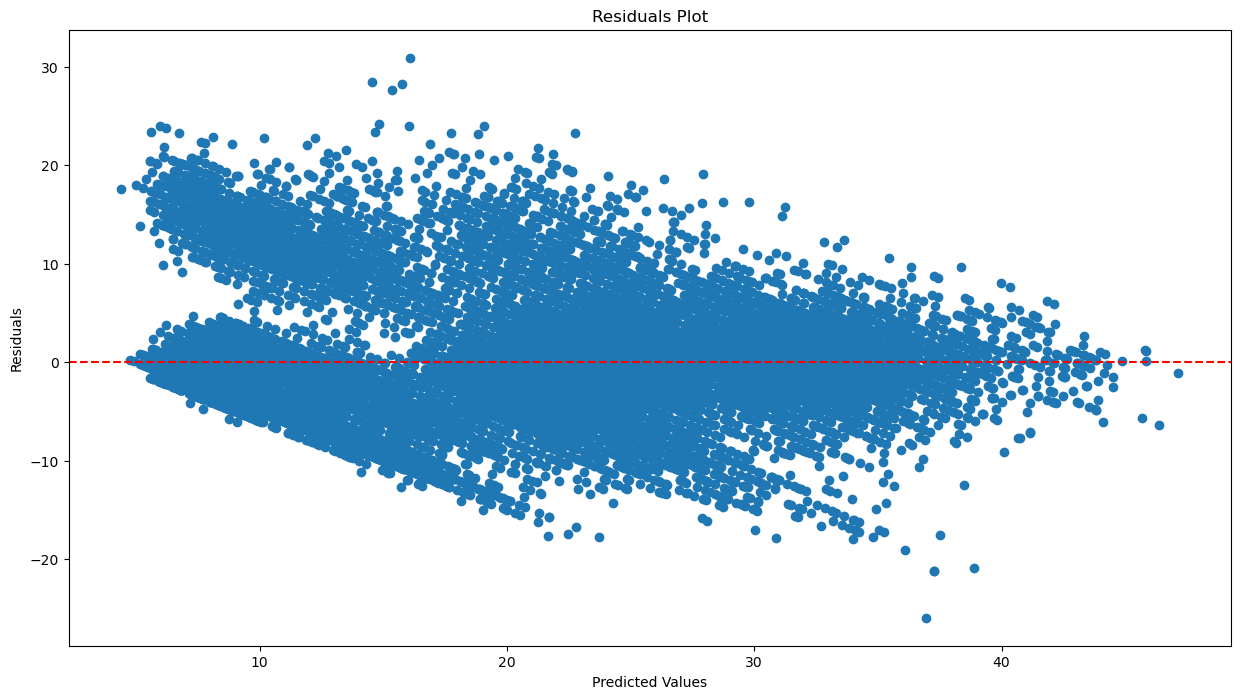

Do you want to save the result? Y/N:  y


In [237]:
model_validation(BaggingRegressor(n_estimators = 100,max_samples = 0.5,max_features = 1.0,bootstrap = False,bootstrap_features = False,
                     random_state=10), xtrain, ytrain, xtest, ytest)

In [238]:
scorecard

Model  R-squared Train  \
0                                 LinearRegression()         0.541501   
1                       Ridge(alpha=1, max_iter=500)         0.541501   
2                    Lasso(alpha=0.01, max_iter=500)         0.541177   
3  ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4             DecisionTreeRegressor(random_state=10)         0.999999   
5  DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6             RandomForestRegressor(random_state=10)         0.973769   
7  RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                  BaggingRegressor(random_state=10)         0.964796   
9  BaggingRegressor(bootstrap=False, max_samples=...         0.953381   

   R-squared Test        MSE      RMSE       MAE      MAPE  
0        0.544529  28.459977  5.334789  3.123672  0.303684  
1        0.544529  28.459992  5.334791  3.123720  0.303686  
2        0.544197  28.480752  5.336736  3.122036  0.303056  
3        0.441277  34.911691  5.908612  3.778581  0.342459  
4        0.670804  20.569729  4.535386  2.129332  0.178965  
5        0.815061  11.555883  3.399394  1.949310  0.164198  
6        0.812438  11.719755  3.423413  1.789791  0.152407  
7        0.824635  10.957657  3.310235  1.817514  0.153362  
8        0.800046  12.494108  3.534700  1.831221  0.155978  
9        0.817469  11.405384  3.377186  1.781295  0.151793

R-Squared Train:  0.7246715035882707
R-Squared Test:  0.7248031813265741
Mean squared error:  17.195612270757778
Root mean squared error:  4.146759249191804
Mean absolute error:  2.535948171421744
Mean absolute percentage error:  0.23585039581710815


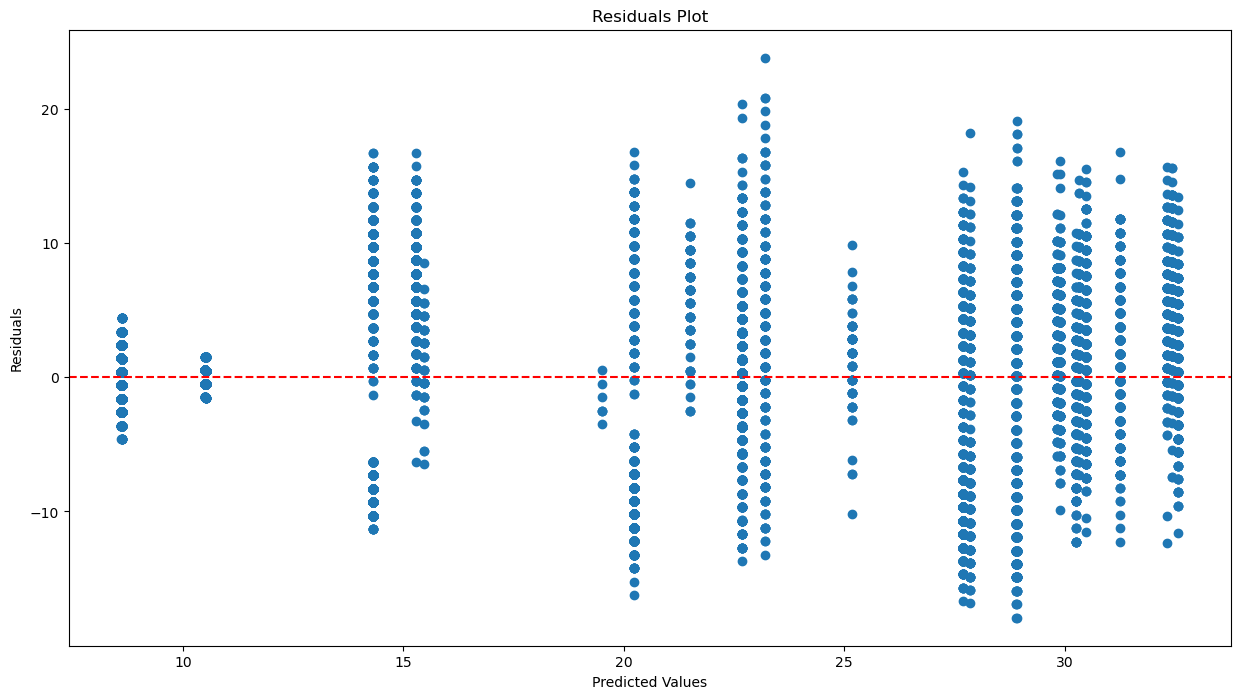

Do you want to save the result? Y/N:  y


In [239]:
model_validation(AdaBoostRegressor(), xtrain, ytrain, xtest, ytest)

In [240]:
scorecard

Model  R-squared Train  \
0                                  LinearRegression()         0.541501   
1                        Ridge(alpha=1, max_iter=500)         0.541501   
2                     Lasso(alpha=0.01, max_iter=500)         0.541177   
3   ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4              DecisionTreeRegressor(random_state=10)         0.999999   
5   DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6              RandomForestRegressor(random_state=10)         0.973769   
7   RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                   BaggingRegressor(random_state=10)         0.964796   
9   BaggingRegressor(bootstrap=False, max_samples=...         0.953381   
10                                AdaBoostRegressor()         0.724672   

    R-squared Test        MSE      RMSE       MAE      MAPE  
0         0.544529  28.459977  5.334789  3.123672  0.303684  
1         0.544529  28.459992  5.334791  3.123720  0.303686  
2         0.544197  28.480752  5.336736  3.122036  0.303056  
3         0.441277  34.911691  5.908612  3.778581  0.342459  
4         0.670804  20.569729  4.535386  2.129332  0.178965  
5         0.815061  11.555883  3.399394  1.949310  0.164198  
6         0.812438  11.719755  3.423413  1.789791  0.152407  
7         0.824635  10.957657  3.310235  1.817514  0.153362  
8         0.800046  12.494108  3.534700  1.831221  0.155978  
9         0.817469  11.405384  3.377186  1.781295  0.151793  
10        0.724803  17.195612  4.146759  2.535948  0.235850

R-Squared Train:  0.7237004140611019
R-Squared Test:  0.7237243891234526
Mean squared error:  17.263020362664566
Root mean squared error:  4.154879103254939
Mean absolute error:  2.5564732683560156
Mean absolute percentage error:  0.23167466174159526


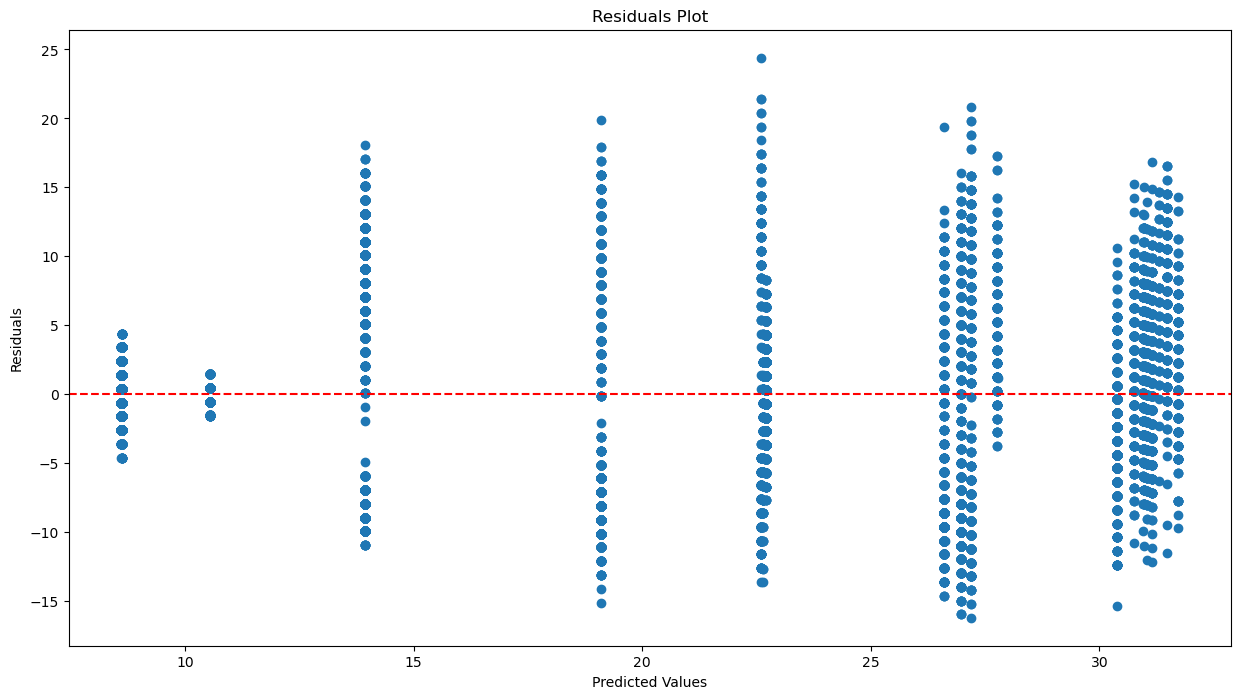

Do you want to save the result? Y/N:  y


In [241]:
model_validation(AdaBoostRegressor(n_estimators = 50,learning_rate = 0.1,loss = 'linear',random_state=10), xtrain, ytrain, xtest, ytest)

In [242]:
scorecard

Model  R-squared Train  \
0                                  LinearRegression()         0.541501   
1                        Ridge(alpha=1, max_iter=500)         0.541501   
2                     Lasso(alpha=0.01, max_iter=500)         0.541177   
3   ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4              DecisionTreeRegressor(random_state=10)         0.999999   
5   DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6              RandomForestRegressor(random_state=10)         0.973769   
7   RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                   BaggingRegressor(random_state=10)         0.964796   
9   BaggingRegressor(bootstrap=False, max_samples=...         0.953381   
10                                AdaBoostRegressor()         0.724672   
11  AdaBoostRegressor(learning_rate=0.1, random_st...         0.723700   

    R-squared Test        MSE      RMSE       MAE      MAPE  
0         0.544529  28.459977  5.334789  3.123672  0.303684  
1         0.544529  28.459992  5.334791  3.123720  0.303686  
2         0.544197  28.480752  5.336736  3.122036  0.303056  
3         0.441277  34.911691  5.908612  3.778581  0.342459  
4         0.670804  20.569729  4.535386  2.129332  0.178965  
5         0.815061  11.555883  3.399394  1.949310  0.164198  
6         0.812438  11.719755  3.423413  1.789791  0.152407  
7         0.824635  10.957657  3.310235  1.817514  0.153362  
8         0.800046  12.494108  3.534700  1.831221  0.155978  
9         0.817469  11.405384  3.377186  1.781295  0.151793  
10        0.724803  17.195612  4.146759  2.535948  0.235850  
11        0.723724  17.263020  4.154879  2.556473  0.231675

R-Squared Train:  0.8153930375574047
R-Squared Test:  0.8131616231278972
Mean squared error:  11.67455460232992
Root mean squared error:  3.4168047357626277
Mean absolute error:  2.023307381790943
Mean absolute percentage error:  0.17452764755011388


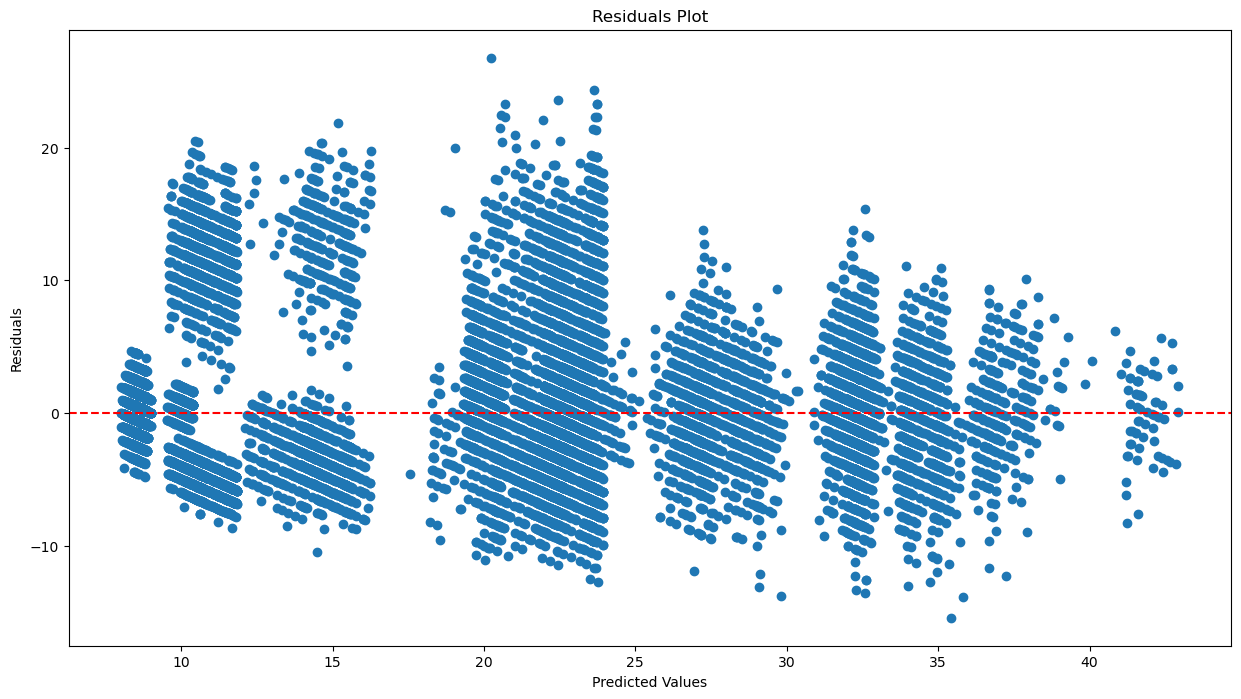

Do you want to save the result? Y/N:  y


In [243]:
model_validation(GradientBoostingRegressor(random_state=10), xtrain, ytrain, xtest, ytest)

In [244]:
scorecard

Model  R-squared Train  \
0                                  LinearRegression()         0.541501   
1                        Ridge(alpha=1, max_iter=500)         0.541501   
2                     Lasso(alpha=0.01, max_iter=500)         0.541177   
3   ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4              DecisionTreeRegressor(random_state=10)         0.999999   
5   DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6              RandomForestRegressor(random_state=10)         0.973769   
7   RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                   BaggingRegressor(random_state=10)         0.964796   
9   BaggingRegressor(bootstrap=False, max_samples=...         0.953381   
10                                AdaBoostRegressor()         0.724672   
11  AdaBoostRegressor(learning_rate=0.1, random_st...         0.723700   
12         GradientBoostingRegressor(random_state=10)         0.815393   

    R-squared Test        MSE      RMSE       MAE      MAPE  
0         0.544529  28.459977  5.334789  3.123672  0.303684  
1         0.544529  28.459992  5.334791  3.123720  0.303686  
2         0.544197  28.480752  5.336736  3.122036  0.303056  
3         0.441277  34.911691  5.908612  3.778581  0.342459  
4         0.670804  20.569729  4.535386  2.129332  0.178965  
5         0.815061  11.555883  3.399394  1.949310  0.164198  
6         0.812438  11.719755  3.423413  1.789791  0.152407  
7         0.824635  10.957657  3.310235  1.817514  0.153362  
8         0.800046  12.494108  3.534700  1.831221  0.155978  
9         0.817469  11.405384  3.377186  1.781295  0.151793  
10        0.724803  17.195612  4.146759  2.535948  0.235850  
11        0.723724  17.263020  4.154879  2.556473  0.231675  
12        0.813162  11.674555  3.416805  2.023307  0.174528

R-Squared Train:  0.8234251843641173
R-Squared Test:  0.8199712788860872
Mean squared error:  11.249054770320138
Root mean squared error:  3.3539610567685694
Mean absolute error:  1.940309695924932
Mean absolute percentage error:  0.16455811537542622


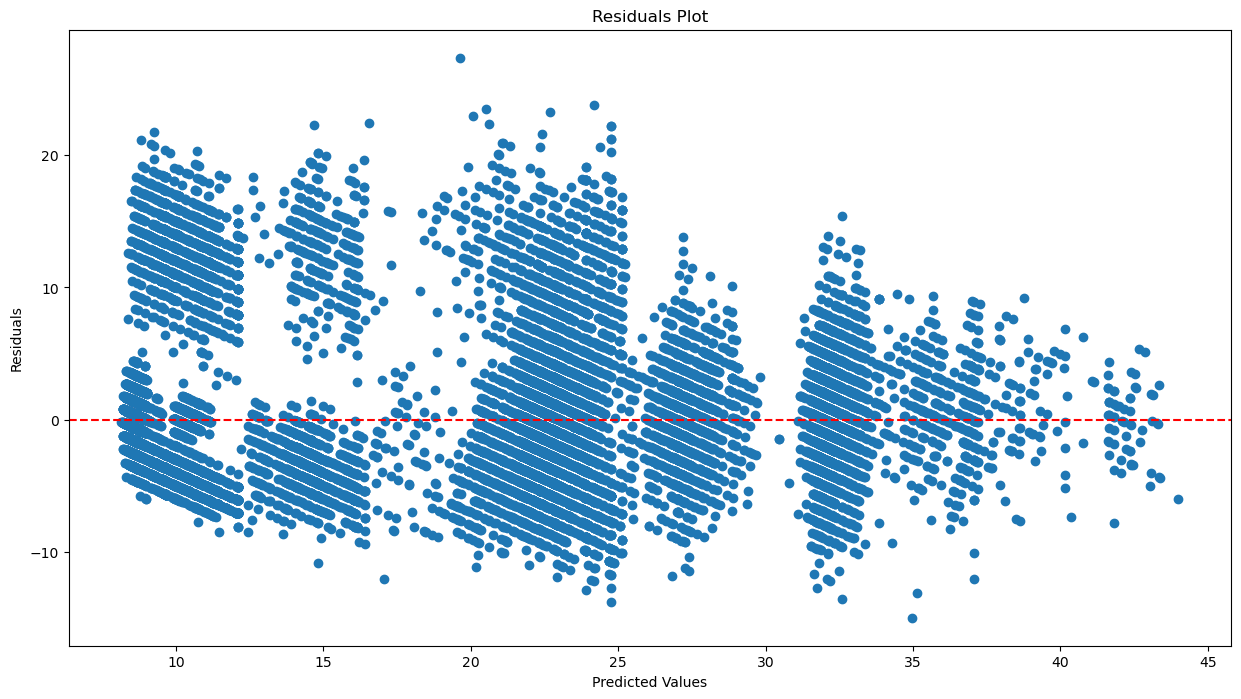

Do you want to save the result? Y/N:  y


In [245]:
model_validation(GradientBoostingRegressor(n_estimators = 50,learning_rate = 0.1,max_depth = 5,min_samples_split = 2,
                                min_samples_leaf = 4,subsample = 1.0,random_state=10), xtrain, ytrain, xtest, ytest)

In [246]:
scorecard

Model  R-squared Train  \
0                                  LinearRegression()         0.541501   
1                        Ridge(alpha=1, max_iter=500)         0.541501   
2                     Lasso(alpha=0.01, max_iter=500)         0.541177   
3   ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4              DecisionTreeRegressor(random_state=10)         0.999999   
5   DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6              RandomForestRegressor(random_state=10)         0.973769   
7   RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                   BaggingRegressor(random_state=10)         0.964796   
9   BaggingRegressor(bootstrap=False, max_samples=...         0.953381   
10                                AdaBoostRegressor()         0.724672   
11  AdaBoostRegressor(learning_rate=0.1, random_st...         0.723700   
12         GradientBoostingRegressor(random_state=10)         0.815393   
13  GradientBoostingRegressor(max_depth=5, min_sam...         0.823425   

    R-squared Test        MSE      RMSE       MAE      MAPE  
0         0.544529  28.459977  5.334789  3.123672  0.303684  
1         0.544529  28.459992  5.334791  3.123720  0.303686  
2         0.544197  28.480752  5.336736  3.122036  0.303056  
3         0.441277  34.911691  5.908612  3.778581  0.342459  
4         0.670804  20.569729  4.535386  2.129332  0.178965  
5         0.815061  11.555883  3.399394  1.949310  0.164198  
6         0.812438  11.719755  3.423413  1.789791  0.152407  
7         0.824635  10.957657  3.310235  1.817514  0.153362  
8         0.800046  12.494108  3.534700  1.831221  0.155978  
9         0.817469  11.405384  3.377186  1.781295  0.151793  
10        0.724803  17.195612  4.146759  2.535948  0.235850  
11        0.723724  17.263020  4.154879  2.556473  0.231675  
12        0.813162  11.674555  3.416805  2.023307  0.174528  
13        0.819971  11.249055  3.353961  1.940310  0.164558

R-Squared Train:  0.8398333952888575
R-Squared Test:  0.8267582120631428
Mean squared error:  10.824974753760483
Root mean squared error:  3.290132938615168
Mean absolute error:  1.8524875300070598
Mean absolute percentage error:  0.15668253267580765


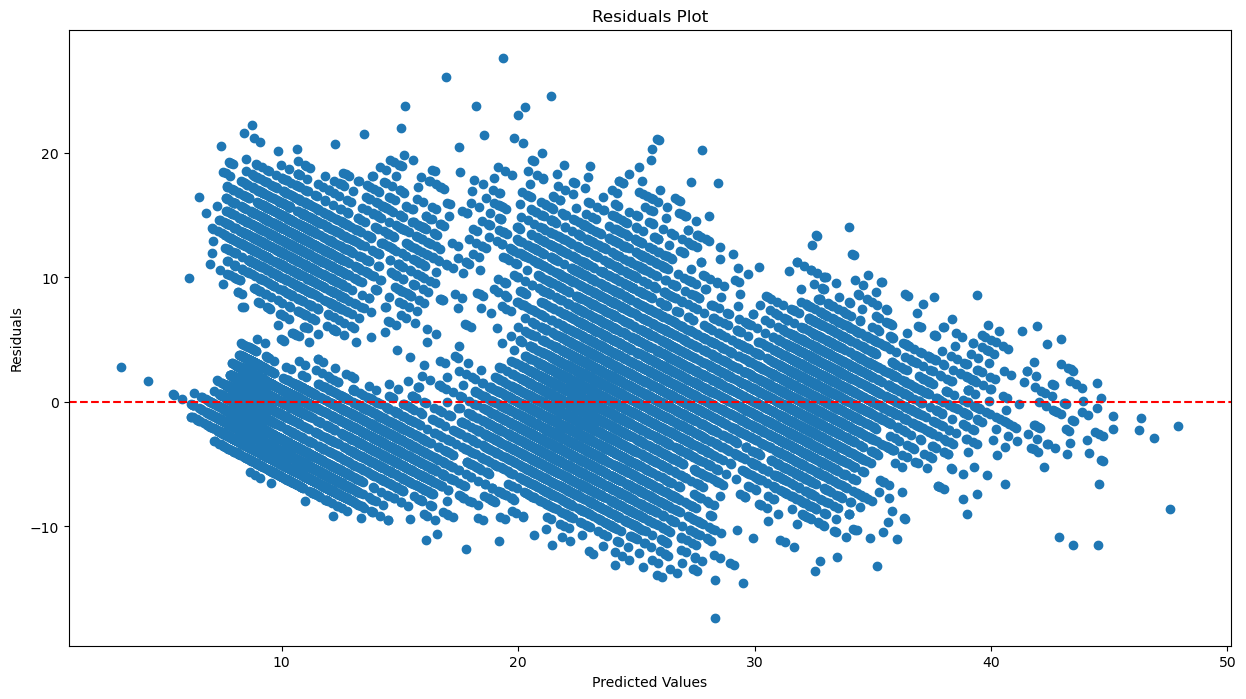

Do you want to save the result? Y/N:  y


In [247]:
model_validation(XGBRegressor(random_state=10), xtrain, ytrain, xtest, ytest)

In [248]:
scorecard

Model  R-squared Train  \
0                                  LinearRegression()         0.541501   
1                        Ridge(alpha=1, max_iter=500)         0.541501   
2                     Lasso(alpha=0.01, max_iter=500)         0.541177   
3   ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4              DecisionTreeRegressor(random_state=10)         0.999999   
5   DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6              RandomForestRegressor(random_state=10)         0.973769   
7   RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                   BaggingRegressor(random_state=10)         0.964796   
9   BaggingRegressor(bootstrap=False, max_samples=...         0.953381   
10                                AdaBoostRegressor()         0.724672   
11  AdaBoostRegressor(learning_rate=0.1, random_st...         0.723700   
12         GradientBoostingRegressor(random_state=10)         0.815393   
13  GradientBoostingRegressor(max_depth=5, min_sam...         0.823425   
14  XGBRegressor(base_score=None, booster=None, ca...         0.839833   

    R-squared Test        MSE      RMSE       MAE      MAPE  
0         0.544529  28.459977  5.334789  3.123672  0.303684  
1         0.544529  28.459992  5.334791  3.123720  0.303686  
2         0.544197  28.480752  5.336736  3.122036  0.303056  
3         0.441277  34.911691  5.908612  3.778581  0.342459  
4         0.670804  20.569729  4.535386  2.129332  0.178965  
5         0.815061  11.555883  3.399394  1.949310  0.164198  
6         0.812438  11.719755  3.423413  1.789791  0.152407  
7         0.824635  10.957657  3.310235  1.817514  0.153362  
8         0.800046  12.494108  3.534700  1.831221  0.155978  
9         0.817469  11.405384  3.377186  1.781295  0.151793  
10        0.724803  17.195612  4.146759  2.535948  0.235850  
11        0.723724  17.263020  4.154879  2.556473  0.231675  
12        0.813162  11.674555  3.416805  2.023307  0.174528  
13        0.819971  11.249055  3.353961  1.940310  0.164558  
14        0.826758  10.824975  3.290133  1.852488  0.156683

R-Squared Train:  0.8232210784432614
R-Squared Test:  0.8200950278131757
Mean squared error:  11.241322346015988
Root mean squared error:  3.3528081284225
Mean absolute error:  1.9382058527520898
Mean absolute percentage error:  0.16430936626562412


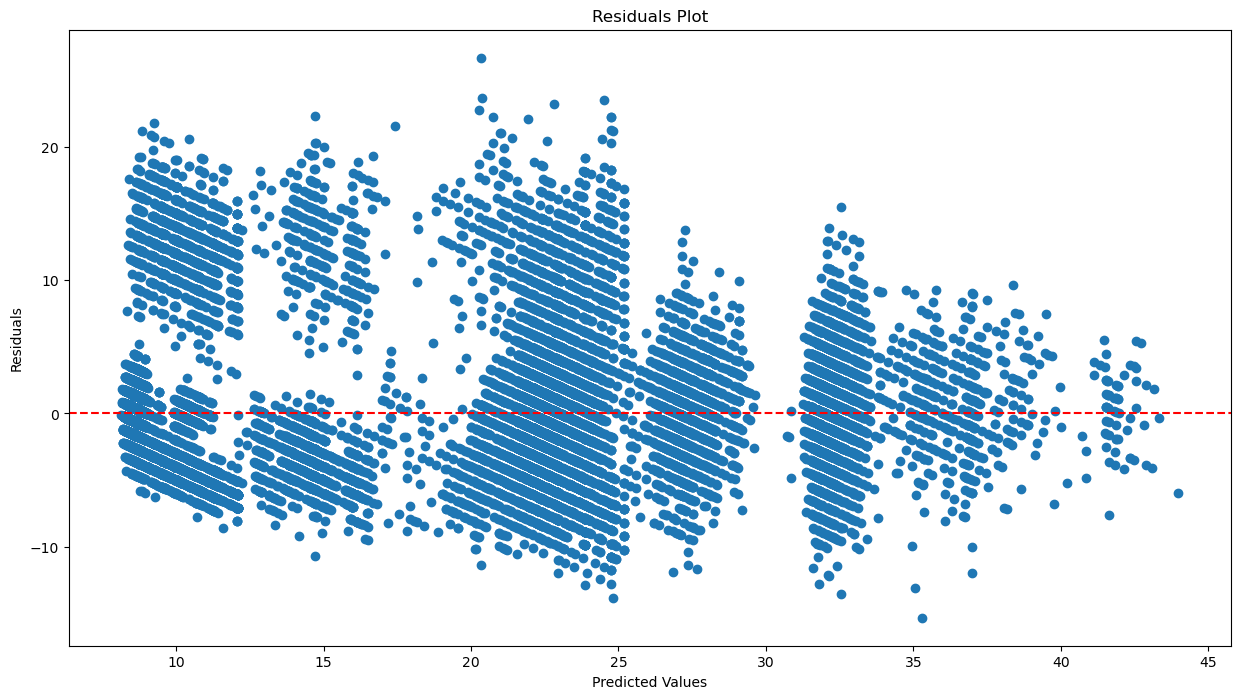

Do you want to save the result? Y/N:  y


In [249]:
model_validation(XGBRegressor(n_estimators = 50,learning_rate = 0.1,max_depth = 5,min_child_weight = 5,
                    subsample = 1.0,colsample_bytree = 1.0,gamma = 0,random_state=10), xtrain, ytrain, xtest, ytest)

In [250]:
scorecard

Model  R-squared Train  \
0                                  LinearRegression()         0.541501   
1                        Ridge(alpha=1, max_iter=500)         0.541501   
2                     Lasso(alpha=0.01, max_iter=500)         0.541177   
3   ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4              DecisionTreeRegressor(random_state=10)         0.999999   
5   DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6              RandomForestRegressor(random_state=10)         0.973769   
7   RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                   BaggingRegressor(random_state=10)         0.964796   
9   BaggingRegressor(bootstrap=False, max_samples=...         0.953381   
10                                AdaBoostRegressor()         0.724672   
11  AdaBoostRegressor(learning_rate=0.1, random_st...         0.723700   
12         GradientBoostingRegressor(random_state=10)         0.815393   
13  GradientBoostingRegressor(max_depth=5, min_sam...         0.823425   
14  XGBRegressor(base_score=None, booster=None, ca...         0.839833   
15  XGBRegressor(base_score=None, booster=None, ca...         0.823221   

    R-squared Test        MSE      RMSE       MAE      MAPE  
0         0.544529  28.459977  5.334789  3.123672  0.303684  
1         0.544529  28.459992  5.334791  3.123720  0.303686  
2         0.544197  28.480752  5.336736  3.122036  0.303056  
3         0.441277  34.911691  5.908612  3.778581  0.342459  
4         0.670804  20.569729  4.535386  2.129332  0.178965  
5         0.815061  11.555883  3.399394  1.949310  0.164198  
6         0.812438  11.719755  3.423413  1.789791  0.152407  
7         0.824635  10.957657  3.310235  1.817514  0.153362  
8         0.800046  12.494108  3.534700  1.831221  0.155978  
9         0.817469  11.405384  3.377186  1.781295  0.151793  
10        0.724803  17.195612  4.146759  2.535948  0.235850  
11        0.723724  17.263020  4.154879  2.556473  0.231675  
12        0.813162  11.674555  3.416805  2.023307  0.174528  
13        0.819971  11.249055  3.353961  1.940310  0.164558  
14        0.826758  10.824975  3.290133  1.852488  0.156683  
15        0.820095  11.241322  3.352808  1.938206  0.164309

R-Squared Train:  0.8147045423992051
R-Squared Test:  0.8126659081611958
Mean squared error:  11.705529242245083
Root mean squared error:  3.4213344242042583
Mean absolute error:  2.0213069301691093
Mean absolute percentage error:  0.17377493432563051


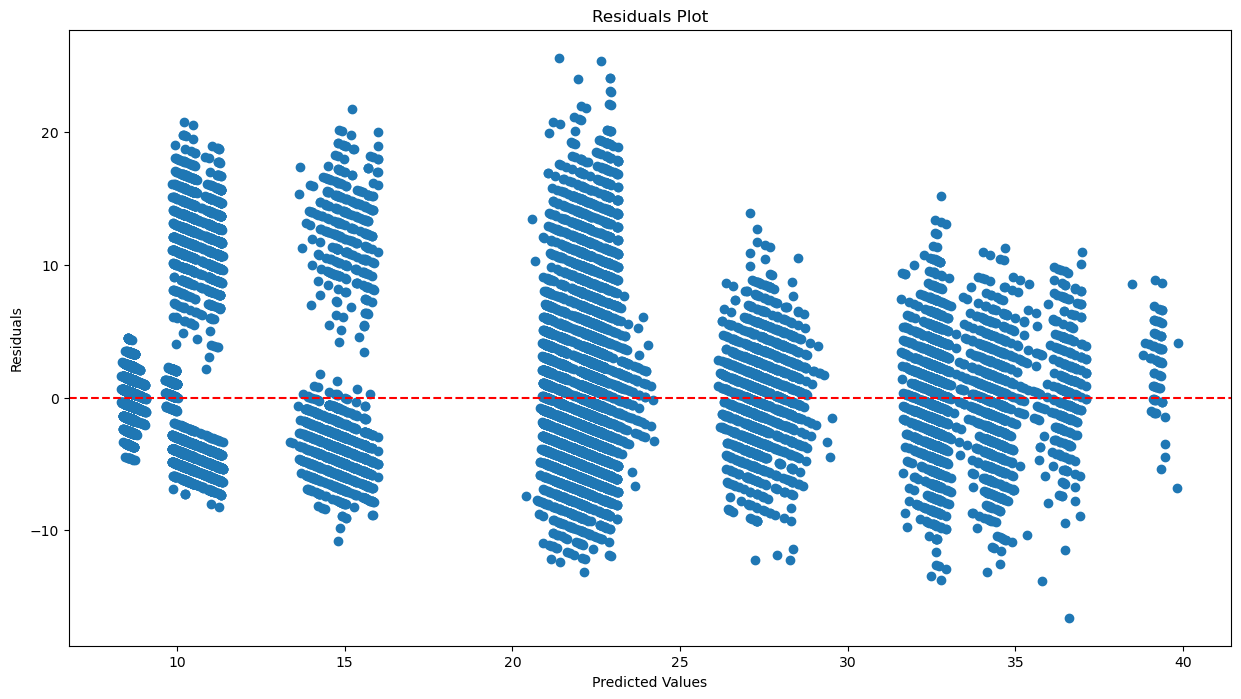

Do you want to save the result? Y/N:  y


In [251]:
model_validation(CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, verbose=0), xtrain, ytrain, xtest, ytest)

In [252]:
scorecard

Model  R-squared Train  \
0                                  LinearRegression()         0.541501   
1                        Ridge(alpha=1, max_iter=500)         0.541501   
2                     Lasso(alpha=0.01, max_iter=500)         0.541177   
3   ElasticNet(alpha=0.1, l1_ratio=0.01, max_iter=...         0.439379   
4              DecisionTreeRegressor(random_state=10)         0.999999   
5   DecisionTreeRegressor(max_depth=10, max_featur...         0.819905   
6              RandomForestRegressor(random_state=10)         0.973769   
7   RandomForestRegressor(max_features='sqrt', min...         0.876472   
8                   BaggingRegressor(random_state=10)         0.964796   
9   BaggingRegressor(bootstrap=False, max_samples=...         0.953381   
10                                AdaBoostRegressor()         0.724672   
11  AdaBoostRegressor(learning_rate=0.1, random_st...         0.723700   
12         GradientBoostingRegressor(random_state=10)         0.815393   
13  GradientBoostingRegressor(max_depth=5, min_sam...         0.823425   
14  XGBRegressor(base_score=None, booster=None, ca...         0.839833   
15  XGBRegressor(base_score=None, booster=None, ca...         0.823221   
16  <catboost.core.CatBoostRegressor object at 0x1...         0.814705   

    R-squared Test        MSE      RMSE       MAE      MAPE  
0         0.544529  28.459977  5.334789  3.123672  0.303684  
1         0.544529  28.459992  5.334791  3.123720  0.303686  
2         0.544197  28.480752  5.336736  3.122036  0.303056  
3         0.441277  34.911691  5.908612  3.778581  0.342459  
4         0.670804  20.569729  4.535386  2.129332  0.178965  
5         0.815061  11.555883  3.399394  1.949310  0.164198  
6         0.812438  11.719755  3.423413  1.789791  0.152407  
7         0.824635  10.957657  3.310235  1.817514  0.153362  
8         0.800046  12.494108  3.534700  1.831221  0.155978  
9         0.817469  11.405384  3.377186  1.781295  0.151793  
10        0.724803  17.195612  4.146759  2.535948  0.235850  
11        0.723724  17.263020  4.154879  2.556473  0.231675  
12        0.813162  11.674555  3.416805  2.023307  0.174528  
13        0.819971  11.249055  3.353961  1.940310  0.164558  
14        0.826758  10.824975  3.290133  1.852488  0.156683  
15        0.820095  11.241322  3.352808  1.938206  0.164309  
16        0.812666  11.705529  3.421334  2.021307  0.173775

**Analysis of the Dataset Using Regression Models for Predicting Hospital Stay Duration**

**Model Performance Overview:**

The evaluation of various regression models for predicting hospital stay duration highlights that the tuned versions of Random Forest Regressor, Gradient Boosting Regressor, and XGBoost Regressor are the top performers. Notably, the tuned Random Forest Regressor achieved an R² score of 82.46% on the test set, with an RMSE of 3.31 and a MAPE of 15.34%. These metrics indicate the model's strong ability to capture the underlying patterns of the target variable while maintaining high prediction accuracy.

**Error Metrics:**

The Root Mean Square Error (RMSE) and Mean Absolute Percentage Error (MAPE) for each model provide insights into prediction accuracy. The tuned XGBoost Regressor recorded the lowest RMSE of 3.29, closely followed by the tuned Random Forest Regressor and Gradient Boosting Regressor, with RMSE values of 3.31 and 3.35, respectively. These low RMSE and MAPE values highlight the effectiveness of ensemble models in minimizing prediction errors.

**Overfitting Insights:**

The Decision Tree Regressor displayed an R² score of 100% on the training set but dropped to 67.08% on the test set, indicating severe overfitting. This significant disparity underscores the model's inability to generalize to unseen data. Ensemble models like Random Forest, Bagging Regressor, and Boosting Regressors proved to be more robust, effectively balancing bias and variance while improving generalization.

**Model Selection:**

Among all evaluated models, the tuned versions of Random Forest, XGBoost, and Gradient Boosting Regressors exhibited the strongest generalization capabilities, with the following performance metrics:

        Tuned Random Forest Regressor:
        R²: 82.46% | RMSE: 3.31 | MAPE: 15.34%

        Tuned XGBoost Regressor:
        R²: 82.68% | RMSE: 3.29 | MAPE: 15.67%

        Tuned Gradient Boosting Regressor:
        R²: 81.99% | RMSE: 3.35 | MAPE: 16.46%

These models deliver competitive performance, making them suitable for further analysis and optimization.

**Hyperparameter Tuning:**

While the current tuning has yielded promising results, further exploration of hyperparameters—such as maximum depth, learning rate, and tree-specific parameters—could enhance predictive performance. Techniques like Randomized Search or Bayesian Optimization could uncover optimal configurations that maximize model accuracy and minimize errors.

**Business Impact:**

Accurately predicting hospital stay durations is critical for efficient resource allocation and planning. Reliable predictions can optimize bed utilization, staff scheduling, and medical resource management. The low RMSE and MAPE values achieved by the ensemble models demonstrate their potential to support hospitals in minimizing costs associated with over- or under-utilization of resources. It is also essential to assess the business implications of prediction errors to align model outcomes with organizational goals effectively.

**Conclusion:**

The analysis indicates that the tuned Random Forest, XGBoost, and Gradient Boosting Regressors provide the best balance between predictive performance and generalization, with XGBoost showing marginally superior results. However, careful evaluation of the models' prediction errors and their alignment with practical application requirements is crucial. Further refinement through hyperparameter tuning and analysis of trade-offs between predictive performance and operational constraints will help achieve optimal outcomes in hospital resource planning and management tasks.